In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tqdm 
import logging
np.set_printoptions(suppress=True)
import logging
logger = logging.getLogger('')
logger.setLevel('INFO')
logger.info('4')

from itertools import combinations


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from simulator import loadBeneficiaryData, getTopk, takeActions, getWhittleIndex
from LP_functions import LP, big_LP, whittle_LP, prob_string_to_prob

In [4]:
# Load ARMAAN Transitions and pre-computed whittle indices
T_data, w, engagement_matrix, cluster_ids = loadBeneficiaryData()

# Load policy dumps
with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestCl

## Get Actions Function
### Contains logic for all policies 
### Policy is numbered 5,6,7,8,9,10

In [5]:
def getActions(states, T,k, cluster_ids, arm_pull_history, policy=0, timestep=None,w=None, sim_length=None, available_arms=None\
               , sleeping_constraint=True):
  w = np.array(w)
  '''
  Computes actions to be taken according to the given policy. 
  See below for more info on policy map

  Inputs: 
    states: A vector of size N with binary values {0,1} respresenting the \
        states of beneficiaries
    T: Transition matrix of size Nx2x2x2 \
        (num_beneficiaries x action x starting_state x ending_state)
    k: Intervention budget. Assumed to be between 0 and num_of_beneficiaries
    policy: Policy to implement. Dictionary: \
        {0: No interventions, 1: intervene on all, 2: random, 3: round-robin,\
        4: myopic, 5: whittle}
    timestep: timestep at which function is called (relevant for round robin)
    w: Array of size Nx2 storing the whittle indices of arms when they are \
      available. Indexed as w[beneficiary_idx, state] with state=0 => NE state.
  available_arms: An array of size N with binary values {0,1}, where 0 denotes\
      sleeping arm and 1 denotes available arm. 
  sleeping_constraint: Boolean indicating whether to impose frequency constraint
  
  Outputs:
    actions: A vector of size N with binary values {0,1} representing action \
    chosen for each beneficiary  
  '''
  logger = logging.getLogger('getAct')
  logger.setLevel(level)
  SOME_LARGE_NUMBER=10000
  
  N= states.shape[0]
  w = np.copy(w)
    
  if policy==2:
    ## select k arms at random
    actions=np.zeros(N)
    if sleeping_constraint:
      actions[np.random.choice(np.where(available_arms)[0],                    \
                          size=min(k,np.sum(available_arms[available_arms>0])),\
                          replace=False)]=1         # with constraint
    else:
      actions[np.random.choice(np.arange(N), size=k, replace=False)]=1         \
                                                    # without constraint
    return actions
  if policy==3:
    ## select k arms in a round robin fashion
    actions=np.zeros(N)
    if sleeping_constraint:
      if np.sum(available_arms)<=k:
        actions[np.where(available_arms)[0]]=1
      else:
        actions[[(timestep*k+i)%N for i in range(k)]]=1
        '''This is assuming that because more arms are available than required,\
        the arms that we would have pulled otherwise would always be available'''
    else:
      actions[[(timestep*k+i)%N for i in range(k)]]=1
    return actions
  
  ## Baseline Whittle Index Policy (No Fairness)
  if policy==5:
    ## select k arms according to whittle indices
    actions=np.zeros(N)
    whittle_indices=w[np.arange(N), states]
    if sleeping_constraint:
      whittle_indices[np.where(1-available_arms)]=-SOME_LARGE_NUMBER 
      ## This is preclude sleeping arms from possibility of selection. 
      ## Setting it to -infty can lead to numerical errors
      top_k_whittle=getTopk(whittle_indices, min(k,int(np.sum(available_arms))))
    else:
      top_k_whittle=getTopk(whittle_indices, k)
    top_k_positive_whittle=np.array([idx for idx in top_k_whittle if \
                                     True])
    ## Pull only arms with positive whittle indices
    if len(top_k_positive_whittle)>0:
      actions[top_k_positive_whittle]=1
    return actions
  
  

In [6]:
policy_names={0:'Nobody',1:'Everybody', 2:'Random', 3:'RR', \
                4:'Myopic', 5:'Whittle', 6:'Fair Whittle Myopic', 7:'Fair Whittle Non-Myopic',
               8:'Baseline Quota', 9:'Big-LP', 9.1:'Big-LP Lump-sum', 10: 'Big-LP-Big-Whittle', 11: 'Dynamic Fair'}
    
    
def runSimulation(args, T=None,w=None, cluster_ids = None, sleeping_constraint=True,\
                  counterExample=False, badf=50):
  '''
  Runs the simulation for the given set of input arguments and returns rewards

  Inputs: 
    args: All simulations settings
    T: Transition matrix if to be used from existing data
    w: Whittle indices corresponding to transition matrix
    sleeping_constraint: If True, imposes frequency constraint
    counterExample: If True and if T is None, then generates T matrix according
                    to adversarial example
    badf: Percentage of non-recoverable beneficiaries in counterExample

  Outputs: 
    simulated_rewards: Matrix of size num_trials X num_policies. Each entry is 
                      total raw reward of a policy for that trial
    state_record: Engagement matrix of size num_trials X policies X N X L \
                indexed as [trial no.][policy][beneficiary idx][timestep]
  '''
  logger = logging.getLogger('runSim')
  logger.setLevel(level)
  E_START_STATE_PROB=0.5
  ##### Unpack arguments
  L=args.simulation_length
  N=args.num_beneficiaries
  k=args.num_resources
  ntr=args.num_trials
  if args.policy<0:
    policies=[2, 3, 5]
  else:
    policies=[args.policy]

  state_record=np.zeros((ntr, len(policies),N,L))  # Store the full state
                                                   # trajectory
  simulated_rewards=np.zeros((ntr, len(policies))) # Store aggregate rewards
  history_dict = {i_pol: [] for i_pol in policies}

  ##### Iterate over number of independent trials to average over
  for tr in range(ntr):
    logger.info('\n\n')
    logger.info('#'*100)
    logger.info(f'Trial: {tr}\n')
    
        
        
    exp_armpull_history = {i_pol:[[0]*N] for i_pol in policies}
    ## Initialize for each trial
    np.random.seed(seed=tr+args.seed_base)
     # Random state \
                                                             #initialization                      
    
    ## For current trial, evaluate all policies
    for pol_idx, pol in enumerate(policies):
      np.random.seed(seed=tr+args.seed_base)
      if args.sigma==-1:
        T_noise = gen_trans(T, seed=tr+args.seed_base)
      else:
        T_noise = add_noise(T, args.sigma, seed=tr+args.seed_base)
#         T_noise = add_noise_subsetted(T, args.sigma,
#                                       seed=tr+args.seed_base, subset_size=10)

#       if pol == 5:
#         print('orig: ', T[0])
#         print('noisy: ', T_noise[0])
#         print('pol: ', pol, ' seed', tr+args.seed_base)
#         print('sigma: ', args.sigma, '\n')
      states=np.random.binomial(1, E_START_STATE_PROB, size=N)
#       T_noise = add_noise(T, args.sigma)
#       w_noise = Parallel(n_jobs=16)(delayed(getWhittleIndex)(T_noise[i]) for i in tqdm(range(len(T_noise))))
      ## Iterate over timesteps. Note that if simulation length is L, 
      ## there are L-1 action decisions to take.
      previous_three_actions=[[],[],[]]          # for tracking sleeping arms
      for timestep in range(L-1):
        ## Put previously pulled arms to sleep
        available_arms=np.ones_like(states)
        for prev_a in previous_three_actions:
          for arm_idx in prev_a:
            available_arms[arm_idx]=0
        
        ## Compute actions
        state_record[tr, pol_idx, :, timestep] = np.copy(states)

        actions=getActions(states=states, T=T, k=k, cluster_ids=cluster_ids,
                           arm_pull_history=exp_armpull_history[pol],
                           policy=pol,
                           timestep=timestep, w=w,\
                           sim_length=L-1,available_arms=available_arms, \
                           sleeping_constraint=sleeping_constraint)
#         assert np.array_equal(T[rand_idx].flatten(), orig_T)
#         assert np.array_equal(w[rand_idx].flatten(), orig_w)

        exp_armpull_history[pol].append(actions)
#         states = np.copy(takeActions(states, T, actions))
        states = np.copy(takeActions(states, T_noise, actions))
        ## Update prev_actions array
        previous_three_actions[timestep%3]=np.where(actions)[0]
      
      simulated_rewards[tr, pol_idx]=np.mean(np.sum(state_record[tr,pol_idx], \
                                                    axis=1))
#       - (T-1)*state_record[tr,pol_idx][:, 0])

      logger.info(f'trial{tr} ', "Reward of policy %s is %s"%(policy_names[pol], \
                            simulated_rewards[tr,policies.index(pol)]))
      history_dict[pol].append(exp_armpull_history[pol])
    


  ##### Print results and plot the output
  for pol in policies: 
    print("Expected reward of policy %s is %s"%(policy_names[pol], \
                            np.mean(simulated_rewards[:,policies.index(pol)])))
  
  return simulated_rewards, state_record, {policy_names[pol]: history_dict[pol] for pol in policies}
  


    


In [7]:
def getSmallBeneficiaryData(seed, T_data, w, cluster_ids, fair_clusters, ppl_per_cluster=20, cluster_subset_counts=10, shuffle_clusters=False):
    np.random.seed(seed)
    if shuffle_clusters:
        cluster_ids = np.copy(cluster_ids)
        np.random.shuffle(cluster_ids)
    
    subset = pd.DataFrame({'cluster_id':cluster_ids, 'id':np.arange(len(cluster_ids))}).sample(frac=10, replace=True)
    
    cluster_val_counts = subset['cluster_id'].value_counts()
    suff_cluster_ids = np.sort(cluster_val_counts[cluster_val_counts>=ppl_per_cluster].index)
    
    cluster_subset = list(np.random.choice([i for i in suff_cluster_ids if i not in fair_clusters],
                                           cluster_subset_counts-len(fair_clusters),
                                           replace=False))+fair_clusters
    
    subset = subset[subset['cluster_id'].isin(cluster_subset)]
    subset = subset.groupby('cluster_id')['id'].head(ppl_per_cluster).values

    return T_data[subset, ...], w[subset, ...], np.array(cluster_ids)[subset]

def get_lambda_g(args, m_G, ppl_per_cluster, FAIR_CLUSTER_IDS, cluster_ids_small, T_data_small):
    cluster_ids_small_o = cluster_ids_small[np.argsort(cluster_ids_small)]
    T_data_small_o = T_data_small[np.argsort(cluster_ids_small)]
    fair_pulls_dict = {i:0 for i in np.unique(cluster_ids_small_o)}
    for FAIR_CLUSTER_ID in FAIR_CLUSTER_IDS:
        fair_pulls_dict[FAIR_CLUSTER_ID] = m_G

    lambda_G = big_LP(m_C=fair_pulls_dict, ppl_per_cluster=ppl_per_cluster, T = args.simulation_length-1,
                      k = args.num_resources,
                      transition_prob=T_data_small_o)
    return lambda_G

def add_noise(two_state_probs, sigma, seed=0, selective_noise=False):
    n = len(two_state_probs)
    orig = np.copy(two_state_probs)
    
    noise = np.random.normal(0, sigma, (n, 2, 2, 1))
    noise = np.clip(noise, -0.5, 0.5)
    
    half = two_state_probs[:, :, :, :1]+noise
    half[half > 1] = two_state_probs[:, :, :, :1][half > 1]-noise[half > 1]
    half[half < 0] = two_state_probs[:, :, :, :1][half < 0]-noise[half < 0]
    
    if not selective_noise:
        return np.concatenate([half, 1-half], axis=3)
    else:
        new = np.concatenate([half, 1-half], axis=3)
        orig[~np.isin(cluster_ids_small, FAIR_CLUSTER_IDS)] = new[~np.isin(cluster_ids_small, FAIR_CLUSTER_IDS)]
        return orig
    
def add_noise(two_state_probs, sigma, seed):
    np.random.seed(seed)
    epsilon = 0.000001
    n = len(two_state_probs)
    orig = np.copy(two_state_probs)
    half = orig[:, :, :, :1]
    half_transformed = np.log((half+epsilon)/(1 + epsilon -half))
    noise = np.random.normal(0, sigma, (n, 2, 2, 1))
    noisy_transformed = half_transformed + noise
    noise_new_half = np.exp(noisy_transformed)/(1+np.exp(noisy_transformed))

    
    if not selective_noise:
        return np.concatenate([noise_new_half, 1-noise_new_half], axis=3)
    else:
        new = np.concatenate([noise_new_half, 1-noise_new_half], axis=3)
        orig[~np.isin(cluster_ids_small, FAIR_CLUSTER_IDS)] = new[~np.isin(cluster_ids_small, FAIR_CLUSTER_IDS)]
        return orig
 
def add_noise_subsetted(two_state_probs, sigma, seed, subset_size):
    np.random.seed(seed)
    subset_clusters = np.random.choice(np.unique(cluster_ids), subset_size)
    epsilon = 0.000001
    n = len(two_state_probs)
    orig = np.copy(two_state_probs)
    half = orig[:, :, :, :1]
    half_transformed = np.log((half+epsilon)/(1 + epsilon -half))
    noise = np.random.normal(0, sigma, (n, 2, 2, 1))
    noisy_transformed = half_transformed + noise
    noise_new_half = np.exp(noisy_transformed)/(1+np.exp(noisy_transformed))

    new = np.concatenate([noise_new_half, 1-noise_new_half], axis=3)
    orig[~np.isin(cluster_ids, subset_clusters)] = new[~np.isin(cluster_ids, subset_clusters)]
    return orig
    
def add_noise(two_state_probs, sigma, seed=0, selective_noise=False):
    epsilon = 0.000001
    n = len(two_state_probs)
    orig = np.copy(two_state_probs)
    half = orig[:, :, :, :1]
    noise = np.random.normal(0, sigma, (n, 2, 2, 1))
    noisy = half + noise
    noisy = np.clip(noisy, 0.0, 1.0)

    
    if not selective_noise:
        return np.concatenate([noisy, 1-noisy], axis=3)
    else:
        new = np.concatenate([noisy, 1-noisy], axis=3)
        orig[~np.isin(cluster_ids_small, FAIR_CLUSTER_IDS)] = new[~np.isin(cluster_ids_small, FAIR_CLUSTER_IDS)]
        return orig

def gen_trans(two_state_probs, seed):
    np.random.seed(seed)
    half = np.random.uniform(0, 1, two_state_probs[:, :, :, :1].shape)
    return np.concatenate([half, 1-half], axis=3)

In [8]:
np.random.choice(np.unique(cluster_ids), 3)


array([10,  3, 16], dtype=int32)

In [9]:
sum([prob_string_to_prob('P(E, A, E)', tr) for tr in T_data]), \
sum([prob_string_to_prob('P(E, A, E)', add_noise(np.array([tr]), 0.2, 100)[0]) for tr in T_data])

(2089.4865769844764, 2335.461455706871)

In [10]:
tr = T_data[0]
prob_string_to_prob('P(E, A, E)', T_data[0]), \
prob_string_to_prob('P(E, A, E)', add_noise(np.array([tr]), 0.2)[0])

(0.7636738906088751, 0.6791981201205233)

In [11]:
sum([prob_string_to_prob('P(E, A, E)', T_data[200]) for i in range(1000)]),\
sum([prob_string_to_prob('P(E, A, E)', add_noise(np.array([T_data[200]]), 0.2)[0])\
     for i in range(1000)])

(284.93788819875806, 289.2716642637037)

In [12]:
T_data[200]

array([[[0.76482158, 0.23517842],
        [0.71506211, 0.28493789]],

       [[0.61111111, 0.38888889],
        [0.22222222, 0.77777778]]])

## Get subsetted transition probs

In [13]:
noise=0
m_G=40
FAIR_CLUSTER_IDS = [10,8]
keep_original_transitions = True
ppl_per_cluster = 10
cluster_subset_counts=20
S_G = ppl_per_cluster
seed = 74

if not keep_original_transitions:
    T_data_small, w_small, cluster_ids_small= getSmallBeneficiaryData(seed, T_data, w, cluster_ids,FAIR_CLUSTER_IDS, 
                                                                      ppl_per_cluster=ppl_per_cluster,
                                                                      cluster_subset_counts=cluster_subset_counts)
else:
    T_data_small, w_small, cluster_ids_small = np.copy(T_data), np.copy(w), np.copy(cluster_ids)

if noise:
    w_noise_small = []
    tr_noise_small = add_noise(T_data_small, noise)
    for trans in tqdm.tqdm(tr_noise_small):
        w_noise_small.append(getWhittleIndex(trans, sleeping_constraint = False, lambda_g=0))
    w_small = np.copy(w_noise_small)
    T_data_small = np.copy(tr_noise_small)
    
print(pd.Series(cluster_ids_small).value_counts())
    


35    2024
10     727
3      432
14     341
0      282
9      269
25     256
23     241
19     241
27     202
18     198
30     182
13     154
33     148
4      142
6      138
16     130
2      130
28     130
21     118
31     117
1      116
29      88
5       84
24      82
11      81
20      80
37      67
39      65
32      60
12      54
22      51
26      51
8       45
7       43
38      40
36      21
34      18
15      15
17       5
dtype: int64


Expected reward of policy Random is 164.37780386019824
Expected reward of policy RR is 164.2722483046427
Expected reward of policy Whittle is 175.03811945748566
Expected reward of policy Random is 194.80936358894107
Expected reward of policy RR is 194.90744653103806
Expected reward of policy Whittle is 202.08661971830983
Expected reward of policy Random is 274.9704616588419
Expected reward of policy RR is 275.1598591549296
Expected reward of policy Whittle is 271.69534428795
Expected reward of policy Random is 350.2055946791862
Expected reward of policy RR is 350.2412754303599
Expected reward of policy Whittle is 349.0562597809077


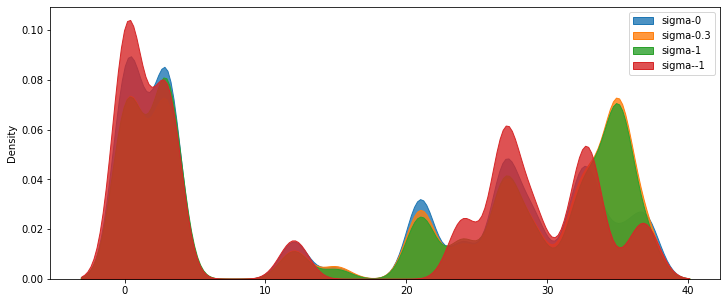

In [25]:
np.set_printoptions(suppress=True)
import logging
import seaborn as sns
logger = logging.getLogger('')
logger.setLevel('INFO')
logger.info('4')
level='WARN'

parser = argparse.ArgumentParser(description='Inputs to engagement simulator module')
parser.add_argument('-N', '--num_beneficiaries', default=7000, type=int, help='Number of Beneficiaries')
parser.add_argument('-k', '--num_resources', default=1400, type=int, help='Number of calls available per day')
parser.add_argument('-L', '--simulation_length', default=40, type=int, help='Number of timesteps of simulation')
parser.add_argument('-ntr', '--num_trials', default=10, type=int, help='Number of independent trials')
parser.add_argument('-s', '--seed_base', default=10, type=int, help='Seedbase for numpy. This is starting seedbase. Simulation will consider the seeds= {seed_base, ... seed_base+ntr-1}')
parser.add_argument('-p', '--policy', default=-1, type=int, help='policy to run. default is all policies')
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
args = parser.parse_args()
args.num_resources=250
args.simulation_length=700
args.num_trials=10
big_whittle_list = []

plt.figure(figsize=(12, 5))
# sns.set_style("whitegrid", {'axes.grid' : True})
# sns.set_palette(sns.color_palette("hls", 4))
# sns.set_palette(sns.color_palette())
# sns.set_palette(sns.color_palette("rocket"))

for sigma in [0, 0.3, 1, -1]:
    args.sigma=sigma

    args.num_beneficiaries=T_data_small.shape[0]

    np.set_printoptions(suppress=True)

    simulated_rewards, state_record, history= runSimulation(args,T= T_data_small , w=w_small, cluster_ids=cluster_ids_small,
                                                  sleeping_constraint=True)
    fair_pull_df = pd.DataFrame({policy: np.array(history[policy]).mean(axis=0).sum(axis=0) 
                             for policy in history.keys()})
    fair_pull_df['cluster_id'] = cluster_ids_small

    fair_pull_df.groupby('cluster_id').sum()
    whittle_list = []
    random_list = []
    rr_list = []
    for cluster in fair_pull_df.groupby('cluster_id').sum().index:
        whittle_list.extend([cluster]*int(fair_pull_df.groupby('cluster_id').sum()['Whittle'].loc[cluster]))
        random_list.extend([cluster]*int(fair_pull_df.groupby('cluster_id').sum()['Random'].loc[cluster]))
        rr_list.extend([cluster]*int(fair_pull_df.groupby('cluster_id').sum()['RR'].loc[cluster]))
    big_whittle_list.append(whittle_list)
#     if len(big_whittle_list)==1:
#         continue
#     plt.figure(figsize=(12, 3))
#     sns.set_style("whitegrid", {'axes.grid' : False})
#     sns.kdeplot(big_whittle_list[0], fill=True, common_norm=True,
#                 label=f'sigma-{0}', alpha=0.3, bw_adjust=1)   
    sns.kdeplot(whittle_list, fill=True, common_norm=True,
                label=f'sigma-{sigma}', alpha=0.8, bw_adjust=0.8)  
#     plt.ylim(0, 0.15)
    plt.legend()
#     plt.show()

In [754]:
np.array(history['Whittle']).shape

(10, 40, 7668)

In [788]:
exp = 0
t = 30
print(state_record[:, 2, ...][exp, :, t:t+4].sum(axis=1)[20:40])
print(np.array(history['Whittle'])[exp, t, :][20:40])

[2. 4. 2. 2. 0. 1. 2. 1. 4. 1. 2. 2. 4. 2. 2. 3. 2. 4. 2. 2.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
for t in range(40-3):
    exp = 0
    actions = np.array(history['Whittle'])[exp, t, :]
    states = state_record[:, 2, ...][exp, :, t:t+4].sum(axis=1)
    intervention_conversion = 

In [795]:
pd.Series(big_whittle_list[3]).value_counts().sort_index()

0     258
1     163
3     195
12     68
24     66
27    282
29    125
32     50
33    166
36     30
37     91
dtype: int64

In [655]:
T_data.shape, len(cluster_ids)

((7668, 2, 2, 2), 7668)

In [701]:
whittle_df = pd.DataFrame({'whittle_E': w[:, 0],
             'whittle_NE': w[:, 1],
             'cluster': cluster_ids}).drop_duplicates()


In [702]:
pd.merge(cluster_transition_probabilities, whittle_df, how='left').loc[3]

cluster           3.000000
count           204.000000
P(E, I, E)        0.250000
P(E, I, NE)       0.750000
P(NE, I, E)       0.157895
P(NE, I, NE)      0.842105
P(E, A, E)        0.000000
P(E, A, NE)       1.000000
P(NE, A, E)       0.180547
P(NE, A, NE)      0.819453
whittle_E        -0.074402
whittle_NE        0.465172
Name: 3, dtype: float64

In [670]:
np.sort(np.unique(w[:, 1]))

array([-0.54520416, -0.46795654, -0.45119476, -0.38793945, -0.22155762,
       -0.21250916, -0.1570282 , -0.08378601, -0.07807922, -0.07689667,
       -0.07536316, -0.03503418, -0.03092957, -0.02336121,  0.00747681,
        0.01118469,  0.02032471,  0.0380249 ,  0.05822754,  0.068367  ,
        0.0785675 ,  0.09329224,  0.10005188,  0.12039185,  0.1348877 ,
        0.13707733,  0.14500427,  0.16575623,  0.2754364 ,  0.28073883,
        0.28222656,  0.32649231,  0.33354187,  0.39415741,  0.41239929,
        0.46517181,  0.46569824,  0.58795166,  0.59016418,  0.63092804])

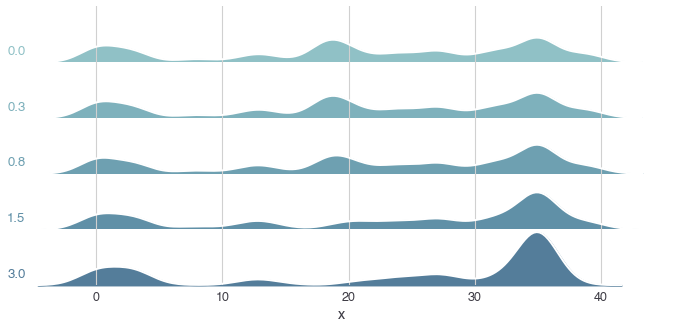

In [302]:
# Create the data
g = np.repeat([0, 0.3, 0.8, 1.5, 3], [len(whittle_list)]*5)
x = np.concatenate(big_whittle_list)
df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=10, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.0005)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [301]:
pd.Series(big_whittle_list[0]).value_counts().sort_index() -\
pd.Series(big_whittle_list[2]).value_counts().sort_index()

0     -179.0
1     -108.0
2        NaN
3     -498.0
7      -58.0
8       23.0
11    -109.0
12     -82.0
13    -100.0
14     -20.0
15      30.0
18    2090.0
19      16.0
20     -21.0
21     -48.0
22     -32.0
24       0.0
25       NaN
27     194.0
29     -75.0
31     -42.0
32       6.0
33    -135.0
35   -1944.0
36     -10.0
37     -12.0
38      35.0
39      -7.0
dtype: float64

In [300]:
pd.Series(big_whittle_list[3]).value_counts()

35    15033
0      4919
3      4649
27     4066
24     3022
13     2499
39     2415
32     2272
31     2004
21     1598
33     1478
1      1454
19     1128
20     1111
29      994
8       959
37      931
12      795
38      706
22      649
11      612
15      425
7       356
14      310
36      215
dtype: int64

<AxesSubplot:xlabel='Whittle', ylabel='Density'>

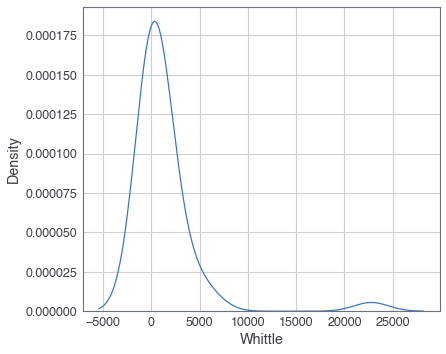

In [185]:
import seaborn as sns
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='grade3')

sns.kdeplot(fair_pull_df.groupby('cluster_id').sum()['Whittle'])


In [174]:
whittle_list = []
random_list = []
rr_list = []
for cluster in fair_pull_df.groupby('cluster_id').sum().index:
    whittle_list.extend([cluster]*int(fair_pull_df.groupby('cluster_id').sum()['Whittle'].loc[cluster]))
    random_list.extend([cluster]*int(fair_pull_df.groupby('cluster_id').sum()['Random'].loc[cluster]))
    rr_list.extend([cluster]*int(fair_pull_df.groupby('cluster_id').sum()['RR'].loc[cluster]))
sns.kdeplot(whittle_list)    
    

<AxesSubplot:ylabel='Density'>

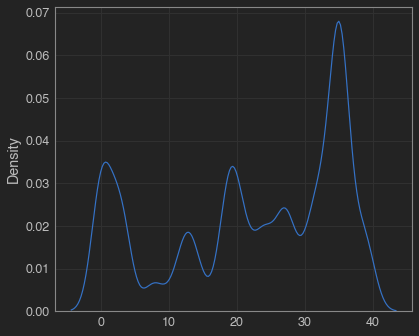

## Print cluster pulls

In [305]:
fair_pull_df = pd.DataFrame({policy: np.array(history[policy]).mean(axis=0).sum(axis=0) 
                             for policy in history.keys()})
fair_pull_df['cluster_id'] = cluster_ids_small

fair_pull_df.groupby('cluster_id').sum()

,Random,RR,Whittle,Baseline Quota,Big-LP,Big-LP Lump-sum
cluster_id,,,,,,
1,20.0,20.0,69.0,69.0,65.0,69.0
3,23.0,23.0,6.0,2.0,0.0,0.0
8,22.0,21.0,0.0,40.0,40.0,43.0
10,21.0,25.0,0.0,40.0,40.0,38.0
13,17.0,22.0,0.0,0.0,0.0,0.0
14,21.0,27.0,0.0,0.0,0.0,0.0
15,31.0,20.0,3.0,1.0,0.0,0.0
17,21.0,20.0,0.0,0.0,0.0,0.0
18,31.0,22.0,0.0,0.0,0.0,0.0


## Run Multi Exps

In [137]:
from itertools import product

m_G_prcnt_exps = [10, 20, 30, 50] # 5
FAIR_CLUSTER_IDS_exps = [[10], [35], [10, 35], [10, 8, 35], [10,23,8,35]] # 6 (adding 28 randomly, we can add anything else)
horizon_exps = [30, 40] #3
resources_exps = [15, 20]
noise_exps = [0] #3
seed_exps = [62, 58, 19, 74, 21, 84, 57, 33 ] #10
ppl_per_cluster_exps = [10]
cluster_subset_counts_exps = [20]

n_exps = len(list(product(m_G_prcnt_exps, FAIR_CLUSTER_IDS_exps,
                                           horizon_exps,
                                           resources_exps,
                                           ppl_per_cluster_exps,
                                           cluster_subset_counts_exps,
                                           noise_exps,
                                           seed_exps)))
print(n_exps, n_exps*6/60/60)

640 1.0666666666666667


In [138]:
tr_noise_small, w_noise_small = np.load('noisy_3_trans.npy'), np.load('noisy_3_whittle.npy')

In [139]:
from itertools import product

N_TRIALS = 10
exp_cols = ["m_G_prcnt", "FAIR_CLUSTER_IDS", "horizon", "resources", "ppl_per_cluster", "cluster_subset_counts", "noise", "seed"]
rew_cols = [f'rew-{i}' for i in ['Random', 'RR', 'Whittle', 'Baseline Quota', 'Big-LP', 'Big-LP-LumpSUM']]

exp_result_df = pd.DataFrame(columns=rew_cols+exp_cols)

exp_id = 0
# exp_id = exp_result_df.index.min()+1

for m_G_prcnt, FAIR_CLUSTER_IDS, horizon, resources, ppl_per_cluster, cluster_subset_counts, noise, seed in \
                                    tqdm.tqdm(product(m_G_prcnt_exps,
                                           FAIR_CLUSTER_IDS_exps,
                                           horizon_exps,
                                           resources_exps,
                                           ppl_per_cluster_exps,
                                           cluster_subset_counts_exps,
                                           noise_exps,
                                           seed_exps)):

        parser = argparse.ArgumentParser(description='Inputs to engagement simulator module')
        parser.add_argument('-N', '--num_beneficiaries', default=7000, type=int, help='Number of Beneficiaries')
        parser.add_argument('-k', '--num_resources', default=1400, type=int, help='Number of calls available per day')
        parser.add_argument('-L', '--simulation_length', default=40, type=int, help='Number of timesteps of simulation')
        parser.add_argument('-ntr', '--num_trials', default=10, type=int, help='Number of independent trials')
        parser.add_argument('-s', '--seed_base', default=100, type=int, help='Seedbase for numpy. This is starting seedbase. Simulation will consider the seeds= {seed_base, ... seed_base+ntr-1}')
        parser.add_argument('-p', '--policy', default=-1, type=int, help='policy to run. default is all policies')
        parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
        args = parser.parse_args()
        args.num_resources=resources
        args.simulation_length=horizon
        args.num_trials=N_TRIALS
        m_G = int(horizon*resources*m_G_prcnt/100/len(FAIR_CLUSTER_IDS))
        
        
        T_data_small, w_small, cluster_ids_small= getSmallBeneficiaryData(seed, T_data, w, cluster_ids,FAIR_CLUSTER_IDS, 
                                                                  ppl_per_cluster=ppl_per_cluster,
                                                                  cluster_subset_counts=cluster_subset_counts)
        
        if noise:
            T_data_small, w_small, cluster_ids_small= getSmallBeneficiaryData(seed, tr_noise_small, w_noise_small,
                                                                              cluster_ids,FAIR_CLUSTER_IDS, 
                                                                              ppl_per_cluster=ppl_per_cluster,
                                                                              cluster_subset_counts=cluster_subset_counts)
            
        args.num_beneficiaries=T_data_small.shape[0]

        print(f'm_g: {m_G},fair clusters: {FAIR_CLUSTER_IDS}, timsteps:{horizon}')
        print(f'k:{resources}, ppl_per_cluster:{ppl_per_cluster}, n_clusters:{cluster_subset_counts}')
        print(f'noise:{noise}, seed:{seed}')
        
        lambda_G = get_lambda_g(args, m_G, ppl_per_cluster, FAIR_CLUSTER_IDS, cluster_ids_small, T_data_small)
        
        simulated_rewards, state_record, history = runSimulation(args,T= T_data_small , w=w_small, cluster_ids=cluster_ids_small,
                                                      sleeping_constraint=False)
        exp_result_df.loc[exp_id] = list(simulated_rewards.mean(axis=0))+\
                                    [m_G_prcnt, FAIR_CLUSTER_IDS, horizon, resources, ppl_per_cluster, cluster_subset_counts, noise, seed]
        exp_id +=1
        exp_result_df.to_csv('fair_exp_res_new.csv')


0it [00:00, ?it/s]

m_g: 45,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


1it [00:06,  6.24s/it]

Expected reward of policy Random is 12.742999999999999
Expected reward of policy RR is 12.437999999999999
Expected reward of policy Whittle is 13.413999999999998
Expected reward of policy Baseline Quota is 13.3255
Expected reward of policy Big-LP is 13.312000000000001
Expected reward of policy Big-LP Lump-sum is 13.312000000000001
m_g: 45,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


2it [00:11,  5.95s/it]

Expected reward of policy Random is 11.491499999999998
Expected reward of policy RR is 11.434500000000002
Expected reward of policy Whittle is 12.621999999999998
Expected reward of policy Baseline Quota is 12.514
Expected reward of policy Big-LP is 12.522
Expected reward of policy Big-LP Lump-sum is 12.522
m_g: 45,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


3it [00:16,  5.72s/it]

Expected reward of policy Random is 11.966
Expected reward of policy RR is 12.046
Expected reward of policy Whittle is 13.5435
Expected reward of policy Baseline Quota is 13.422999999999998
Expected reward of policy Big-LP is 13.4605
Expected reward of policy Big-LP Lump-sum is 13.4605
m_g: 45,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


4it [00:22,  5.61s/it]

Expected reward of policy Random is 11.918000000000001
Expected reward of policy RR is 11.8
Expected reward of policy Whittle is 13.34
Expected reward of policy Baseline Quota is 13.255500000000001
Expected reward of policy Big-LP is 13.269
Expected reward of policy Big-LP Lump-sum is 13.269
m_g: 45,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


5it [00:27,  5.50s/it]

Expected reward of policy Random is 9.856000000000002
Expected reward of policy RR is 9.760499999999999
Expected reward of policy Whittle is 11.006
Expected reward of policy Baseline Quota is 10.878
Expected reward of policy Big-LP is 10.8785
Expected reward of policy Big-LP Lump-sum is 10.8785
m_g: 45,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


6it [00:32,  5.34s/it]

Expected reward of policy Random is 9.7415
Expected reward of policy RR is 9.633
Expected reward of policy Whittle is 10.918000000000001
Expected reward of policy Baseline Quota is 10.809999999999999
Expected reward of policy Big-LP is 10.812999999999999
Expected reward of policy Big-LP Lump-sum is 10.812999999999999
m_g: 45,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


7it [00:37,  5.26s/it]

Expected reward of policy Random is 12.5715
Expected reward of policy RR is 12.5595
Expected reward of policy Whittle is 13.682500000000001
Expected reward of policy Baseline Quota is 13.559500000000003
Expected reward of policy Big-LP is 13.578
Expected reward of policy Big-LP Lump-sum is 13.578
m_g: 45,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


8it [00:42,  5.17s/it]

Expected reward of policy Random is 11.108999999999998
Expected reward of policy RR is 11.110000000000001
Expected reward of policy Whittle is 12.53
Expected reward of policy Baseline Quota is 12.423
Expected reward of policy Big-LP is 12.435500000000001
Expected reward of policy Big-LP Lump-sum is 12.435500000000001
m_g: 60,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


9it [00:47,  5.15s/it]

Expected reward of policy Random is 12.861500000000001
Expected reward of policy RR is 12.5815
Expected reward of policy Whittle is 13.7345
Expected reward of policy Baseline Quota is 13.631499999999999
Expected reward of policy Big-LP is 13.648500000000002
Expected reward of policy Big-LP Lump-sum is 13.648500000000002
m_g: 60,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


10it [00:52,  5.22s/it]

Expected reward of policy Random is 11.649500000000002
Expected reward of policy RR is 11.578
Expected reward of policy Whittle is 13.031
Expected reward of policy Baseline Quota is 12.904
Expected reward of policy Big-LP is 12.907
Expected reward of policy Big-LP Lump-sum is 12.907
m_g: 60,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


11it [00:57,  5.20s/it]

Expected reward of policy Random is 12.1745
Expected reward of policy RR is 12.138
Expected reward of policy Whittle is 13.9585
Expected reward of policy Baseline Quota is 13.870500000000002
Expected reward of policy Big-LP is 13.870500000000002
Expected reward of policy Big-LP Lump-sum is 13.870500000000002
m_g: 60,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


12it [01:03,  5.21s/it]

Expected reward of policy Random is 12.118500000000001
Expected reward of policy RR is 12.1055
Expected reward of policy Whittle is 13.684000000000001
Expected reward of policy Baseline Quota is 13.5655
Expected reward of policy Big-LP is 13.564000000000002
Expected reward of policy Big-LP Lump-sum is 13.564000000000002
m_g: 60,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


13it [01:08,  5.27s/it]

Expected reward of policy Random is 10.007000000000001
Expected reward of policy RR is 9.9695
Expected reward of policy Whittle is 11.4245
Expected reward of policy Baseline Quota is 11.264000000000001
Expected reward of policy Big-LP is 11.2625
Expected reward of policy Big-LP Lump-sum is 11.2625
m_g: 60,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


14it [01:14,  5.40s/it]

Expected reward of policy Random is 9.963999999999999
Expected reward of policy RR is 9.927499999999998
Expected reward of policy Whittle is 11.2765
Expected reward of policy Baseline Quota is 11.194500000000001
Expected reward of policy Big-LP is 11.167
Expected reward of policy Big-LP Lump-sum is 11.167
m_g: 60,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


15it [01:19,  5.45s/it]

Expected reward of policy Random is 12.714000000000002
Expected reward of policy RR is 12.696499999999999
Expected reward of policy Whittle is 14.138499999999999
Expected reward of policy Baseline Quota is 13.994
Expected reward of policy Big-LP is 14.0495
Expected reward of policy Big-LP Lump-sum is 14.0495
m_g: 60,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


16it [01:24,  5.36s/it]

Expected reward of policy Random is 11.237
Expected reward of policy RR is 11.302000000000001
Expected reward of policy Whittle is 12.821000000000002
Expected reward of policy Baseline Quota is 12.725
Expected reward of policy Big-LP is 12.753499999999999
Expected reward of policy Big-LP Lump-sum is 12.753499999999999
m_g: 60,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


17it [01:30,  5.34s/it]

Expected reward of policy Random is 17.014999999999997
Expected reward of policy RR is 16.718000000000004
Expected reward of policy Whittle is 17.987499999999997
Expected reward of policy Baseline Quota is 17.8775
Expected reward of policy Big-LP is 17.8675
Expected reward of policy Big-LP Lump-sum is 17.8675
m_g: 60,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


18it [01:35,  5.36s/it]

Expected reward of policy Random is 15.355499999999997
Expected reward of policy RR is 15.269499999999999
Expected reward of policy Whittle is 16.889000000000003
Expected reward of policy Baseline Quota is 16.7465
Expected reward of policy Big-LP is 16.747
Expected reward of policy Big-LP Lump-sum is 16.747
m_g: 60,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


19it [01:40,  5.28s/it]

Expected reward of policy Random is 16.0205
Expected reward of policy RR is 16.145
Expected reward of policy Whittle is 18.2655
Expected reward of policy Baseline Quota is 18.077499999999997
Expected reward of policy Big-LP is 18.1315
Expected reward of policy Big-LP Lump-sum is 18.1315
m_g: 60,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


20it [01:46,  5.29s/it]

Expected reward of policy Random is 15.959999999999999
Expected reward of policy RR is 15.848500000000001
Expected reward of policy Whittle is 17.929
Expected reward of policy Baseline Quota is 17.825
Expected reward of policy Big-LP is 17.8295
Expected reward of policy Big-LP Lump-sum is 17.8295
m_g: 60,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


21it [01:51,  5.27s/it]

Expected reward of policy Random is 13.227500000000001
Expected reward of policy RR is 13.023
Expected reward of policy Whittle is 14.724
Expected reward of policy Baseline Quota is 14.5525
Expected reward of policy Big-LP is 14.5335
Expected reward of policy Big-LP Lump-sum is 14.5335
m_g: 60,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


22it [01:56,  5.24s/it]

Expected reward of policy Random is 13.055000000000001
Expected reward of policy RR is 12.832500000000001
Expected reward of policy Whittle is 14.597500000000002
Expected reward of policy Baseline Quota is 14.441999999999998
Expected reward of policy Big-LP is 14.4525
Expected reward of policy Big-LP Lump-sum is 14.4525
m_g: 60,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


23it [02:01,  5.23s/it]

Expected reward of policy Random is 16.860500000000002
Expected reward of policy RR is 16.8365
Expected reward of policy Whittle is 18.357
Expected reward of policy Baseline Quota is 18.187
Expected reward of policy Big-LP is 18.187
Expected reward of policy Big-LP Lump-sum is 18.187
m_g: 60,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


24it [02:06,  5.22s/it]

Expected reward of policy Random is 14.892999999999997
Expected reward of policy RR is 14.9445
Expected reward of policy Whittle is 16.8245
Expected reward of policy Baseline Quota is 16.699
Expected reward of policy Big-LP is 16.726499999999998
Expected reward of policy Big-LP Lump-sum is 16.726499999999998
m_g: 80,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


25it [02:12,  5.22s/it]

Expected reward of policy Random is 17.1505
Expected reward of policy RR is 16.8505
Expected reward of policy Whittle is 18.4065
Expected reward of policy Baseline Quota is 18.276999999999997
Expected reward of policy Big-LP is 18.2905
Expected reward of policy Big-LP Lump-sum is 18.2905
m_g: 80,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


26it [02:17,  5.34s/it]

Expected reward of policy Random is 15.5545
Expected reward of policy RR is 15.459
Expected reward of policy Whittle is 17.448
Expected reward of policy Baseline Quota is 17.288999999999998
Expected reward of policy Big-LP is 17.285999999999998
Expected reward of policy Big-LP Lump-sum is 17.285999999999998
m_g: 80,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


27it [02:23,  5.36s/it]

Expected reward of policy Random is 16.2925
Expected reward of policy RR is 16.326999999999998
Expected reward of policy Whittle is 18.839
Expected reward of policy Baseline Quota is 18.704
Expected reward of policy Big-LP is 18.677500000000002
Expected reward of policy Big-LP Lump-sum is 18.677500000000002
m_g: 80,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


28it [02:28,  5.37s/it]

Expected reward of policy Random is 16.2555
Expected reward of policy RR is 16.2265
Expected reward of policy Whittle is 18.405
Expected reward of policy Baseline Quota is 18.2515
Expected reward of policy Big-LP is 18.253999999999998
Expected reward of policy Big-LP Lump-sum is 18.253999999999998
m_g: 80,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


29it [02:34,  5.46s/it]

Expected reward of policy Random is 13.434999999999999
Expected reward of policy RR is 13.2875
Expected reward of policy Whittle is 15.3015
Expected reward of policy Baseline Quota is 15.083000000000002
Expected reward of policy Big-LP is 15.105
Expected reward of policy Big-LP Lump-sum is 15.105
m_g: 80,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


30it [02:39,  5.45s/it]

Expected reward of policy Random is 13.3275
Expected reward of policy RR is 13.3065
Expected reward of policy Whittle is 15.097
Expected reward of policy Baseline Quota is 14.948000000000002
Expected reward of policy Big-LP is 14.941999999999998
Expected reward of policy Big-LP Lump-sum is 14.941999999999998
m_g: 80,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


31it [02:45,  5.46s/it]

Expected reward of policy Random is 17.084500000000002
Expected reward of policy RR is 17.044999999999998
Expected reward of policy Whittle is 18.9865
Expected reward of policy Baseline Quota is 18.788500000000003
Expected reward of policy Big-LP is 18.8485
Expected reward of policy Big-LP Lump-sum is 18.8485
m_g: 80,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


32it [02:50,  5.39s/it]

Expected reward of policy Random is 15.093
Expected reward of policy RR is 15.133499999999998
Expected reward of policy Whittle is 17.2425
Expected reward of policy Baseline Quota is 17.118000000000002
Expected reward of policy Big-LP is 17.139
Expected reward of policy Big-LP Lump-sum is 17.139
m_g: 45,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


33it [02:55,  5.25s/it]

Expected reward of policy Random is 12.386499999999998
Expected reward of policy RR is 12.3105
Expected reward of policy Whittle is 13.315999999999999
Expected reward of policy Baseline Quota is 13.232
Expected reward of policy Big-LP is 13.244
Expected reward of policy Big-LP Lump-sum is 13.244
m_g: 45,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


34it [03:00,  5.15s/it]

Expected reward of policy Random is 11.560999999999998
Expected reward of policy RR is 11.6595
Expected reward of policy Whittle is 12.924000000000001
Expected reward of policy Baseline Quota is 12.844000000000003
Expected reward of policy Big-LP is 12.843
Expected reward of policy Big-LP Lump-sum is 12.843
m_g: 45,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


35it [03:05,  5.14s/it]

Expected reward of policy Random is 12.066
Expected reward of policy RR is 12.1125
Expected reward of policy Whittle is 13.760000000000002
Expected reward of policy Baseline Quota is 13.669
Expected reward of policy Big-LP is 13.6955
Expected reward of policy Big-LP Lump-sum is 13.6955
m_g: 45,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


36it [03:10,  5.07s/it]

Expected reward of policy Random is 12.852500000000001
Expected reward of policy RR is 12.985
Expected reward of policy Whittle is 14.3065
Expected reward of policy Baseline Quota is 14.2025
Expected reward of policy Big-LP is 14.1825
Expected reward of policy Big-LP Lump-sum is 14.1825
m_g: 45,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


37it [03:16,  5.36s/it]

Expected reward of policy Random is 10.8005
Expected reward of policy RR is 10.822
Expected reward of policy Whittle is 12.192499999999999
Expected reward of policy Baseline Quota is 12.1155
Expected reward of policy Big-LP is 12.0995
Expected reward of policy Big-LP Lump-sum is 12.0995
m_g: 45,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


38it [03:21,  5.26s/it]

Expected reward of policy Random is 11.208499999999999
Expected reward of policy RR is 11.1365
Expected reward of policy Whittle is 12.434000000000001
Expected reward of policy Baseline Quota is 12.321000000000002
Expected reward of policy Big-LP is 12.318999999999999
Expected reward of policy Big-LP Lump-sum is 12.318999999999999
m_g: 45,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


39it [03:26,  5.24s/it]

Expected reward of policy Random is 13.879000000000001
Expected reward of policy RR is 13.9055
Expected reward of policy Whittle is 14.967999999999998
Expected reward of policy Baseline Quota is 14.877499999999998
Expected reward of policy Big-LP is 14.892000000000001
Expected reward of policy Big-LP Lump-sum is 14.892000000000001
m_g: 45,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


40it [03:31,  5.16s/it]

Expected reward of policy Random is 12.372
Expected reward of policy RR is 12.314499999999999
Expected reward of policy Whittle is 13.668500000000003
Expected reward of policy Baseline Quota is 13.580000000000002
Expected reward of policy Big-LP is 13.5995
Expected reward of policy Big-LP Lump-sum is 13.5995
m_g: 60,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


41it [03:36,  5.14s/it]

Expected reward of policy Random is 12.493500000000001
Expected reward of policy RR is 12.4085
Expected reward of policy Whittle is 13.6375
Expected reward of policy Baseline Quota is 13.534
Expected reward of policy Big-LP is 13.5575
Expected reward of policy Big-LP Lump-sum is 13.5575
m_g: 60,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


42it [03:41,  5.14s/it]

Expected reward of policy Random is 11.715000000000002
Expected reward of policy RR is 11.7665
Expected reward of policy Whittle is 13.3335
Expected reward of policy Baseline Quota is 13.222
Expected reward of policy Big-LP is 13.208499999999997
Expected reward of policy Big-LP Lump-sum is 13.208499999999997
m_g: 60,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


43it [03:46,  5.16s/it]

Expected reward of policy Random is 12.222
Expected reward of policy RR is 12.237499999999999
Expected reward of policy Whittle is 14.0375
Expected reward of policy Baseline Quota is 13.976999999999999
Expected reward of policy Big-LP is 13.996500000000001
Expected reward of policy Big-LP Lump-sum is 13.996500000000001
m_g: 60,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


44it [03:51,  5.15s/it]

Expected reward of policy Random is 12.9725
Expected reward of policy RR is 13.120999999999999
Expected reward of policy Whittle is 14.617499999999998
Expected reward of policy Baseline Quota is 14.547000000000002
Expected reward of policy Big-LP is 14.559000000000003
Expected reward of policy Big-LP Lump-sum is 14.559000000000003
m_g: 60,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


45it [03:57,  5.17s/it]

Expected reward of policy Random is 10.969
Expected reward of policy RR is 10.918000000000003
Expected reward of policy Whittle is 12.587
Expected reward of policy Baseline Quota is 12.488
Expected reward of policy Big-LP is 12.463000000000001
Expected reward of policy Big-LP Lump-sum is 12.463000000000001
m_g: 60,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


46it [04:02,  5.13s/it]

Expected reward of policy Random is 11.357499999999998
Expected reward of policy RR is 11.2985
Expected reward of policy Whittle is 12.808000000000002
Expected reward of policy Baseline Quota is 12.7175
Expected reward of policy Big-LP is 12.68
Expected reward of policy Big-LP Lump-sum is 12.68
m_g: 60,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


47it [04:07,  5.16s/it]

Expected reward of policy Random is 13.998
Expected reward of policy RR is 14.078999999999999
Expected reward of policy Whittle is 15.383500000000002
Expected reward of policy Baseline Quota is 15.241
Expected reward of policy Big-LP is 15.238499999999998
Expected reward of policy Big-LP Lump-sum is 15.238499999999998
m_g: 60,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


48it [04:12,  5.13s/it]

Expected reward of policy Random is 12.514500000000002
Expected reward of policy RR is 12.516499999999999
Expected reward of policy Whittle is 14.016499999999999
Expected reward of policy Baseline Quota is 13.936000000000002
Expected reward of policy Big-LP is 13.9425
Expected reward of policy Big-LP Lump-sum is 13.9425
m_g: 60,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


49it [04:17,  5.12s/it]

Expected reward of policy Random is 16.576
Expected reward of policy RR is 16.55
Expected reward of policy Whittle is 17.8945
Expected reward of policy Baseline Quota is 17.789499999999997
Expected reward of policy Big-LP is 17.8215
Expected reward of policy Big-LP Lump-sum is 17.8215
m_g: 60,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


50it [04:22,  5.11s/it]

Expected reward of policy Random is 15.478500000000002
Expected reward of policy RR is 15.550500000000003
Expected reward of policy Whittle is 17.249999999999996
Expected reward of policy Baseline Quota is 17.159499999999998
Expected reward of policy Big-LP is 17.133
Expected reward of policy Big-LP Lump-sum is 17.133
m_g: 60,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


51it [04:27,  5.14s/it]

Expected reward of policy Random is 16.125499999999995
Expected reward of policy RR is 16.241000000000003
Expected reward of policy Whittle is 18.4775
Expected reward of policy Baseline Quota is 18.3595
Expected reward of policy Big-LP is 18.404999999999998
Expected reward of policy Big-LP Lump-sum is 18.404999999999998
m_g: 60,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


52it [04:33,  5.14s/it]

Expected reward of policy Random is 17.258999999999997
Expected reward of policy RR is 17.4195
Expected reward of policy Whittle is 19.2345
Expected reward of policy Baseline Quota is 19.094
Expected reward of policy Big-LP is 19.083999999999996
Expected reward of policy Big-LP Lump-sum is 19.083999999999996
m_g: 60,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


53it [04:38,  5.21s/it]

Expected reward of policy Random is 14.483999999999998
Expected reward of policy RR is 14.538000000000002
Expected reward of policy Whittle is 16.4255
Expected reward of policy Baseline Quota is 16.306
Expected reward of policy Big-LP is 16.271499999999996
Expected reward of policy Big-LP Lump-sum is 16.271499999999996
m_g: 60,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


54it [04:43,  5.17s/it]

Expected reward of policy Random is 14.972999999999995
Expected reward of policy RR is 14.804499999999999
Expected reward of policy Whittle is 16.704500000000003
Expected reward of policy Baseline Quota is 16.553000000000004
Expected reward of policy Big-LP is 16.538500000000003
Expected reward of policy Big-LP Lump-sum is 16.538500000000003
m_g: 60,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


55it [04:48,  5.19s/it]

Expected reward of policy Random is 18.714
Expected reward of policy RR is 18.7815
Expected reward of policy Whittle is 20.1725
Expected reward of policy Baseline Quota is 20.0435
Expected reward of policy Big-LP is 20.068
Expected reward of policy Big-LP Lump-sum is 20.068
m_g: 60,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


56it [04:53,  5.17s/it]

Expected reward of policy Random is 16.601000000000003
Expected reward of policy RR is 16.5685
Expected reward of policy Whittle is 18.381999999999998
Expected reward of policy Baseline Quota is 18.284999999999997
Expected reward of policy Big-LP is 18.297
Expected reward of policy Big-LP Lump-sum is 18.297
m_g: 80,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


57it [04:59,  5.18s/it]

Expected reward of policy Random is 16.740000000000002
Expected reward of policy RR is 16.689999999999998
Expected reward of policy Whittle is 18.3275
Expected reward of policy Baseline Quota is 18.2045
Expected reward of policy Big-LP is 18.226
Expected reward of policy Big-LP Lump-sum is 18.226
m_g: 80,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


58it [05:04,  5.25s/it]

Expected reward of policy Random is 15.6805
Expected reward of policy RR is 15.722
Expected reward of policy Whittle is 17.811
Expected reward of policy Baseline Quota is 17.650499999999997
Expected reward of policy Big-LP is 17.631500000000003
Expected reward of policy Big-LP Lump-sum is 17.631500000000003
m_g: 80,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


59it [05:09,  5.24s/it]

Expected reward of policy Random is 16.3525
Expected reward of policy RR is 16.396
Expected reward of policy Whittle is 18.8545
Expected reward of policy Baseline Quota is 18.7755
Expected reward of policy Big-LP is 18.799500000000002
Expected reward of policy Big-LP Lump-sum is 18.799500000000002
m_g: 80,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


60it [05:15,  5.50s/it]

Expected reward of policy Random is 17.436
Expected reward of policy RR is 17.602
Expected reward of policy Whittle is 19.656000000000002
Expected reward of policy Baseline Quota is 19.572
Expected reward of policy Big-LP is 19.610999999999997
Expected reward of policy Big-LP Lump-sum is 19.610999999999997
m_g: 80,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


61it [05:21,  5.50s/it]

Expected reward of policy Random is 14.7105
Expected reward of policy RR is 14.647499999999999
Expected reward of policy Whittle is 16.959000000000003
Expected reward of policy Baseline Quota is 16.825
Expected reward of policy Big-LP is 16.787
Expected reward of policy Big-LP Lump-sum is 16.787
m_g: 80,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


62it [05:26,  5.44s/it]

Expected reward of policy Random is 15.180000000000001
Expected reward of policy RR is 15.1435
Expected reward of policy Whittle is 17.213
Expected reward of policy Baseline Quota is 17.080999999999996
Expected reward of policy Big-LP is 17.0525
Expected reward of policy Big-LP Lump-sum is 17.0525
m_g: 80,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


63it [05:32,  5.43s/it]

Expected reward of policy Random is 18.878499999999995
Expected reward of policy RR is 18.991
Expected reward of policy Whittle is 20.7305
Expected reward of policy Baseline Quota is 20.541999999999998
Expected reward of policy Big-LP is 20.5255
Expected reward of policy Big-LP Lump-sum is 20.5255
m_g: 80,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


64it [05:37,  5.40s/it]

Expected reward of policy Random is 16.791
Expected reward of policy RR is 16.817
Expected reward of policy Whittle is 18.883999999999997
Expected reward of policy Baseline Quota is 18.773500000000002
Expected reward of policy Big-LP is 18.779000000000003
Expected reward of policy Big-LP Lump-sum is 18.779000000000003
m_g: 22,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


65it [05:42,  5.33s/it]

Expected reward of policy Random is 12.2655
Expected reward of policy RR is 12.174999999999999
Expected reward of policy Whittle is 13.2125
Expected reward of policy Baseline Quota is 13.132
Expected reward of policy Big-LP is 13.127
Expected reward of policy Big-LP Lump-sum is 13.129
m_g: 22,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


66it [05:47,  5.23s/it]

Expected reward of policy Random is 11.5915
Expected reward of policy RR is 11.471
Expected reward of policy Whittle is 12.544999999999998
Expected reward of policy Baseline Quota is 12.471
Expected reward of policy Big-LP is 12.505500000000001
Expected reward of policy Big-LP Lump-sum is 12.4965
m_g: 22,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


67it [05:52,  5.15s/it]

Expected reward of policy Random is 11.764
Expected reward of policy RR is 11.6035
Expected reward of policy Whittle is 13.116999999999999
Expected reward of policy Baseline Quota is 13.0345
Expected reward of policy Big-LP is 13.022
Expected reward of policy Big-LP Lump-sum is 13.019499999999999
m_g: 22,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


68it [05:57,  5.23s/it]

Expected reward of policy Random is 10.944500000000001
Expected reward of policy RR is 10.888499999999999
Expected reward of policy Whittle is 12.4375
Expected reward of policy Baseline Quota is 12.352
Expected reward of policy Big-LP is 12.3185
Expected reward of policy Big-LP Lump-sum is 12.3515
m_g: 22,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


69it [06:03,  5.27s/it]

Expected reward of policy Random is 10.182500000000001
Expected reward of policy RR is 10.193500000000002
Expected reward of policy Whittle is 10.82
Expected reward of policy Baseline Quota is 10.7865
Expected reward of policy Big-LP is 10.7835
Expected reward of policy Big-LP Lump-sum is 10.7785
m_g: 22,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


70it [06:08,  5.21s/it]

Expected reward of policy Random is 10.104000000000003
Expected reward of policy RR is 10.1435
Expected reward of policy Whittle is 11.1845
Expected reward of policy Baseline Quota is 11.1135
Expected reward of policy Big-LP is 11.133
Expected reward of policy Big-LP Lump-sum is 11.1265
m_g: 22,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


71it [06:13,  5.19s/it]

Expected reward of policy Random is 13.0755
Expected reward of policy RR is 12.8845
Expected reward of policy Whittle is 14.4165
Expected reward of policy Baseline Quota is 14.282499999999999
Expected reward of policy Big-LP is 14.291
Expected reward of policy Big-LP Lump-sum is 14.3
m_g: 22,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


72it [06:18,  5.16s/it]

Expected reward of policy Random is 11.4845
Expected reward of policy RR is 11.5625
Expected reward of policy Whittle is 12.9695
Expected reward of policy Baseline Quota is 12.9225
Expected reward of policy Big-LP is 12.925999999999998
Expected reward of policy Big-LP Lump-sum is 12.9265
m_g: 30,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


73it [06:23,  5.17s/it]

Expected reward of policy Random is 12.4085
Expected reward of policy RR is 12.3815
Expected reward of policy Whittle is 13.5365
Expected reward of policy Baseline Quota is 13.459
Expected reward of policy Big-LP is 13.457999999999998
Expected reward of policy Big-LP Lump-sum is 13.444999999999999
m_g: 30,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


74it [06:28,  5.19s/it]

Expected reward of policy Random is 11.747
Expected reward of policy RR is 11.708000000000002
Expected reward of policy Whittle is 12.9355
Expected reward of policy Baseline Quota is 12.804999999999998
Expected reward of policy Big-LP is 12.8285
Expected reward of policy Big-LP Lump-sum is 12.828999999999999
m_g: 30,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


75it [06:34,  5.22s/it]

Expected reward of policy Random is 11.95
Expected reward of policy RR is 11.749
Expected reward of policy Whittle is 13.641000000000002
Expected reward of policy Baseline Quota is 13.494
Expected reward of policy Big-LP is 13.513499999999999
Expected reward of policy Big-LP Lump-sum is 13.514000000000001
m_g: 30,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


76it [06:39,  5.27s/it]

Expected reward of policy Random is 11.1165
Expected reward of policy RR is 11.187999999999999
Expected reward of policy Whittle is 12.791
Expected reward of policy Baseline Quota is 12.734000000000002
Expected reward of policy Big-LP is 12.7355
Expected reward of policy Big-LP Lump-sum is 12.7075
m_g: 30,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


77it [06:45,  5.30s/it]

Expected reward of policy Random is 10.2825
Expected reward of policy RR is 10.2985
Expected reward of policy Whittle is 11.114
Expected reward of policy Baseline Quota is 11.017000000000001
Expected reward of policy Big-LP is 11.047
Expected reward of policy Big-LP Lump-sum is 11.041
m_g: 30,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


78it [06:50,  5.24s/it]

Expected reward of policy Random is 10.2135
Expected reward of policy RR is 10.4065
Expected reward of policy Whittle is 11.522
Expected reward of policy Baseline Quota is 11.4195
Expected reward of policy Big-LP is 11.441999999999998
Expected reward of policy Big-LP Lump-sum is 11.4375
m_g: 30,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


79it [06:55,  5.27s/it]

Expected reward of policy Random is 13.2005
Expected reward of policy RR is 12.991999999999999
Expected reward of policy Whittle is 14.776499999999999
Expected reward of policy Baseline Quota is 14.639000000000001
Expected reward of policy Big-LP is 14.666
Expected reward of policy Big-LP Lump-sum is 14.6945
m_g: 30,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


80it [07:00,  5.25s/it]

Expected reward of policy Random is 11.617
Expected reward of policy RR is 11.727
Expected reward of policy Whittle is 13.2005
Expected reward of policy Baseline Quota is 13.148000000000001
Expected reward of policy Big-LP is 13.1765
Expected reward of policy Big-LP Lump-sum is 13.158999999999997
m_g: 30,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


81it [07:06,  5.30s/it]

Expected reward of policy Random is 16.4615
Expected reward of policy RR is 16.4115
Expected reward of policy Whittle is 17.7075
Expected reward of policy Baseline Quota is 17.6005
Expected reward of policy Big-LP is 17.6035
Expected reward of policy Big-LP Lump-sum is 17.601000000000003
m_g: 30,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


82it [07:11,  5.27s/it]

Expected reward of policy Random is 15.49
Expected reward of policy RR is 15.360000000000003
Expected reward of policy Whittle is 16.823
Expected reward of policy Baseline Quota is 16.7265
Expected reward of policy Big-LP is 16.752500000000005
Expected reward of policy Big-LP Lump-sum is 16.744999999999997
m_g: 30,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


83it [07:16,  5.28s/it]

Expected reward of policy Random is 15.688999999999998
Expected reward of policy RR is 15.607500000000002
Expected reward of policy Whittle is 17.6905
Expected reward of policy Baseline Quota is 17.506
Expected reward of policy Big-LP is 17.557499999999997
Expected reward of policy Big-LP Lump-sum is 17.5315
m_g: 30,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


84it [07:22,  5.41s/it]

Expected reward of policy Random is 14.689000000000002
Expected reward of policy RR is 14.559999999999999
Expected reward of policy Whittle is 16.705000000000002
Expected reward of policy Baseline Quota is 16.561500000000002
Expected reward of policy Big-LP is 16.563
Expected reward of policy Big-LP Lump-sum is 16.5725
m_g: 30,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


85it [07:27,  5.44s/it]

Expected reward of policy Random is 13.5935
Expected reward of policy RR is 13.625
Expected reward of policy Whittle is 14.481
Expected reward of policy Baseline Quota is 14.4305
Expected reward of policy Big-LP is 14.429000000000002
Expected reward of policy Big-LP Lump-sum is 14.4285
m_g: 30,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


86it [07:33,  5.40s/it]

Expected reward of policy Random is 13.516499999999999
Expected reward of policy RR is 13.584
Expected reward of policy Whittle is 14.975999999999999
Expected reward of policy Baseline Quota is 14.860499999999998
Expected reward of policy Big-LP is 14.895999999999997
Expected reward of policy Big-LP Lump-sum is 14.886000000000001
m_g: 30,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


87it [07:38,  5.44s/it]

Expected reward of policy Random is 17.523500000000002
Expected reward of policy RR is 17.286499999999997
Expected reward of policy Whittle is 19.374000000000002
Expected reward of policy Baseline Quota is 19.2055
Expected reward of policy Big-LP is 19.240000000000002
Expected reward of policy Big-LP Lump-sum is 19.244
m_g: 30,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


88it [07:44,  5.43s/it]

Expected reward of policy Random is 15.393
Expected reward of policy RR is 15.497499999999999
Expected reward of policy Whittle is 17.387
Expected reward of policy Baseline Quota is 17.3255
Expected reward of policy Big-LP is 17.3195
Expected reward of policy Big-LP Lump-sum is 17.333499999999997
m_g: 40,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


89it [07:49,  5.44s/it]

Expected reward of policy Random is 16.6385
Expected reward of policy RR is 16.609499999999997
Expected reward of policy Whittle is 18.151
Expected reward of policy Baseline Quota is 18.0375
Expected reward of policy Big-LP is 18.042499999999997
Expected reward of policy Big-LP Lump-sum is 18.024
m_g: 40,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


90it [07:55,  5.47s/it]

Expected reward of policy Random is 15.7185
Expected reward of policy RR is 15.6865
Expected reward of policy Whittle is 17.3515
Expected reward of policy Baseline Quota is 17.180000000000003
Expected reward of policy Big-LP is 17.205000000000002
Expected reward of policy Big-LP Lump-sum is 17.213
m_g: 40,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


91it [08:00,  5.47s/it]

Expected reward of policy Random is 15.925999999999998
Expected reward of policy RR is 15.814499999999999
Expected reward of policy Whittle is 18.3875
Expected reward of policy Baseline Quota is 18.175
Expected reward of policy Big-LP is 18.2345
Expected reward of policy Big-LP Lump-sum is 18.215999999999998
m_g: 40,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


92it [08:06,  5.54s/it]

Expected reward of policy Random is 14.910500000000003
Expected reward of policy RR is 14.972
Expected reward of policy Whittle is 17.240000000000002
Expected reward of policy Baseline Quota is 17.121499999999997
Expected reward of policy Big-LP is 17.110999999999997
Expected reward of policy Big-LP Lump-sum is 17.1125
m_g: 40,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


93it [08:11,  5.56s/it]

Expected reward of policy Random is 13.74
Expected reward of policy RR is 13.781
Expected reward of policy Whittle is 14.914999999999997
Expected reward of policy Baseline Quota is 14.757500000000002
Expected reward of policy Big-LP is 14.783499999999998
Expected reward of policy Big-LP Lump-sum is 14.7975
m_g: 40,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


94it [08:17,  5.52s/it]

Expected reward of policy Random is 13.6715
Expected reward of policy RR is 13.897499999999999
Expected reward of policy Whittle is 15.4275
Expected reward of policy Baseline Quota is 15.291
Expected reward of policy Big-LP is 15.2965
Expected reward of policy Big-LP Lump-sum is 15.308499999999999
m_g: 40,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


95it [08:22,  5.54s/it]

Expected reward of policy Random is 17.684500000000003
Expected reward of policy RR is 17.4955
Expected reward of policy Whittle is 19.905499999999996
Expected reward of policy Baseline Quota is 19.732
Expected reward of policy Big-LP is 19.737
Expected reward of policy Big-LP Lump-sum is 19.773500000000002
m_g: 40,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


96it [08:28,  5.51s/it]

Expected reward of policy Random is 15.588
Expected reward of policy RR is 15.701999999999998
Expected reward of policy Whittle is 17.711
Expected reward of policy Baseline Quota is 17.651
Expected reward of policy Big-LP is 17.680500000000002
Expected reward of policy Big-LP Lump-sum is 17.659
m_g: 15,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


97it [08:33,  5.41s/it]

Expected reward of policy Random is 10.350000000000001
Expected reward of policy RR is 10.2805
Expected reward of policy Whittle is 11.4255
Expected reward of policy Baseline Quota is 11.349
Expected reward of policy Big-LP is 11.378000000000002
Expected reward of policy Big-LP Lump-sum is 11.341000000000001
m_g: 15,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


98it [08:38,  5.38s/it]

Expected reward of policy Random is 12.658
Expected reward of policy RR is 12.6665
Expected reward of policy Whittle is 13.544
Expected reward of policy Baseline Quota is 13.503
Expected reward of policy Big-LP is 13.527000000000001
Expected reward of policy Big-LP Lump-sum is 13.522499999999999
m_g: 15,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


99it [08:44,  5.42s/it]

Expected reward of policy Random is 10.557
Expected reward of policy RR is 10.3965
Expected reward of policy Whittle is 11.805499999999999
Expected reward of policy Baseline Quota is 11.6975
Expected reward of policy Big-LP is 11.713999999999999
Expected reward of policy Big-LP Lump-sum is 11.707500000000001
m_g: 15,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


100it [08:49,  5.42s/it]

Expected reward of policy Random is 10.410500000000003
Expected reward of policy RR is 10.44
Expected reward of policy Whittle is 11.704999999999998
Expected reward of policy Baseline Quota is 11.6375
Expected reward of policy Big-LP is 11.6735
Expected reward of policy Big-LP Lump-sum is 11.684000000000001
m_g: 15,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


101it [08:54,  5.32s/it]

Expected reward of policy Random is 12.023
Expected reward of policy RR is 11.976500000000001
Expected reward of policy Whittle is 12.833000000000002
Expected reward of policy Baseline Quota is 12.7625
Expected reward of policy Big-LP is 12.782
Expected reward of policy Big-LP Lump-sum is 12.759000000000002
m_g: 15,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


102it [09:00,  5.31s/it]

Expected reward of policy Random is 11.1255
Expected reward of policy RR is 11.099
Expected reward of policy Whittle is 12.5725
Expected reward of policy Baseline Quota is 12.490999999999998
Expected reward of policy Big-LP is 12.509
Expected reward of policy Big-LP Lump-sum is 12.484
m_g: 15,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


103it [09:05,  5.36s/it]

Expected reward of policy Random is 11.996500000000001
Expected reward of policy RR is 11.9405
Expected reward of policy Whittle is 13.304000000000002
Expected reward of policy Baseline Quota is 13.210000000000003
Expected reward of policy Big-LP is 13.2315
Expected reward of policy Big-LP Lump-sum is 13.2195
m_g: 15,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


104it [09:10,  5.33s/it]

Expected reward of policy Random is 9.822500000000002
Expected reward of policy RR is 9.8035
Expected reward of policy Whittle is 11.325500000000002
Expected reward of policy Baseline Quota is 11.234
Expected reward of policy Big-LP is 11.2825
Expected reward of policy Big-LP Lump-sum is 11.2675
m_g: 20,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


105it [09:17,  5.60s/it]

Expected reward of policy Random is 10.513000000000002
Expected reward of policy RR is 10.466000000000001
Expected reward of policy Whittle is 11.782999999999998
Expected reward of policy Baseline Quota is 11.694999999999999
Expected reward of policy Big-LP is 11.7115
Expected reward of policy Big-LP Lump-sum is 11.693
m_g: 20,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


106it [09:22,  5.60s/it]

Expected reward of policy Random is 12.782
Expected reward of policy RR is 12.786
Expected reward of policy Whittle is 13.728
Expected reward of policy Baseline Quota is 13.687999999999999
Expected reward of policy Big-LP is 13.6855
Expected reward of policy Big-LP Lump-sum is 13.700999999999999
m_g: 20,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


107it [09:28,  5.65s/it]

Expected reward of policy Random is 10.722
Expected reward of policy RR is 10.5355
Expected reward of policy Whittle is 12.149500000000002
Expected reward of policy Baseline Quota is 12.084999999999999
Expected reward of policy Big-LP is 12.081
Expected reward of policy Big-LP Lump-sum is 12.069
m_g: 20,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


108it [09:33,  5.58s/it]

Expected reward of policy Random is 10.581
Expected reward of policy RR is 10.6005
Expected reward of policy Whittle is 12.048000000000002
Expected reward of policy Baseline Quota is 11.9615
Expected reward of policy Big-LP is 12.003499999999999
Expected reward of policy Big-LP Lump-sum is 11.999500000000001
m_g: 20,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


109it [09:39,  5.49s/it]

Expected reward of policy Random is 12.188500000000001
Expected reward of policy RR is 12.052499999999998
Expected reward of policy Whittle is 13.185500000000001
Expected reward of policy Baseline Quota is 13.103
Expected reward of policy Big-LP is 13.092499999999998
Expected reward of policy Big-LP Lump-sum is 13.0965
m_g: 20,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


110it [09:44,  5.47s/it]

Expected reward of policy Random is 11.257499999999999
Expected reward of policy RR is 11.306999999999999
Expected reward of policy Whittle is 12.977
Expected reward of policy Baseline Quota is 12.852499999999997
Expected reward of policy Big-LP is 12.837
Expected reward of policy Big-LP Lump-sum is 12.8495
m_g: 20,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


111it [09:49,  5.45s/it]

Expected reward of policy Random is 12.139
Expected reward of policy RR is 12.111
Expected reward of policy Whittle is 13.5255
Expected reward of policy Baseline Quota is 13.500499999999999
Expected reward of policy Big-LP is 13.520000000000001
Expected reward of policy Big-LP Lump-sum is 13.502
m_g: 20,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


112it [09:55,  5.45s/it]

Expected reward of policy Random is 9.998999999999999
Expected reward of policy RR is 9.985
Expected reward of policy Whittle is 11.648500000000002
Expected reward of policy Baseline Quota is 11.542
Expected reward of policy Big-LP is 11.5865
Expected reward of policy Big-LP Lump-sum is 11.5725
m_g: 20,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


113it [10:00,  5.43s/it]

Expected reward of policy Random is 13.858500000000001
Expected reward of policy RR is 13.7815
Expected reward of policy Whittle is 15.3275
Expected reward of policy Baseline Quota is 15.214000000000002
Expected reward of policy Big-LP is 15.214000000000002
Expected reward of policy Big-LP Lump-sum is 15.2075
m_g: 20,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


114it [10:06,  5.48s/it]

Expected reward of policy Random is 17.016
Expected reward of policy RR is 16.987000000000002
Expected reward of policy Whittle is 18.157000000000004
Expected reward of policy Baseline Quota is 18.127000000000002
Expected reward of policy Big-LP is 18.131999999999998
Expected reward of policy Big-LP Lump-sum is 18.127999999999997
m_g: 20,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


115it [10:12,  5.57s/it]

Expected reward of policy Random is 14.1965
Expected reward of policy RR is 13.959
Expected reward of policy Whittle is 15.933000000000002
Expected reward of policy Baseline Quota is 15.781
Expected reward of policy Big-LP is 15.767
Expected reward of policy Big-LP Lump-sum is 15.745
m_g: 20,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


116it [10:17,  5.59s/it]

Expected reward of policy Random is 13.947999999999999
Expected reward of policy RR is 13.9495
Expected reward of policy Whittle is 15.6935
Expected reward of policy Baseline Quota is 15.5735
Expected reward of policy Big-LP is 15.649000000000001
Expected reward of policy Big-LP Lump-sum is 15.644499999999999
m_g: 20,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


117it [10:23,  5.52s/it]

Expected reward of policy Random is 16.1485
Expected reward of policy RR is 16.0595
Expected reward of policy Whittle is 17.217000000000002
Expected reward of policy Baseline Quota is 17.1145
Expected reward of policy Big-LP is 17.130000000000003
Expected reward of policy Big-LP Lump-sum is 17.104000000000003
m_g: 20,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


118it [10:28,  5.51s/it]

Expected reward of policy Random is 14.836499999999997
Expected reward of policy RR is 14.871
Expected reward of policy Whittle is 16.833000000000002
Expected reward of policy Baseline Quota is 16.731500000000004
Expected reward of policy Big-LP is 16.741999999999997
Expected reward of policy Big-LP Lump-sum is 16.704500000000003
m_g: 20,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


119it [10:34,  5.57s/it]

Expected reward of policy Random is 16.059500000000003
Expected reward of policy RR is 16.017500000000002
Expected reward of policy Whittle is 17.85
Expected reward of policy Baseline Quota is 17.753
Expected reward of policy Big-LP is 17.752000000000002
Expected reward of policy Big-LP Lump-sum is 17.7295
m_g: 20,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


120it [10:39,  5.57s/it]

Expected reward of policy Random is 13.1615
Expected reward of policy RR is 13.098500000000001
Expected reward of policy Whittle is 15.2075
Expected reward of policy Baseline Quota is 15.061999999999998
Expected reward of policy Big-LP is 15.136499999999998
Expected reward of policy Big-LP Lump-sum is 15.138
m_g: 26,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


121it [10:45,  5.58s/it]

Expected reward of policy Random is 14.095499999999998
Expected reward of policy RR is 13.980500000000001
Expected reward of policy Whittle is 15.8085
Expected reward of policy Baseline Quota is 15.695500000000001
Expected reward of policy Big-LP is 15.6925
Expected reward of policy Big-LP Lump-sum is 15.698999999999998
m_g: 26,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


122it [10:51,  5.64s/it]

Expected reward of policy Random is 17.187500000000004
Expected reward of policy RR is 17.1235
Expected reward of policy Whittle is 18.4095
Expected reward of policy Baseline Quota is 18.355000000000004
Expected reward of policy Big-LP is 18.35
Expected reward of policy Big-LP Lump-sum is 18.3705
m_g: 26,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


123it [10:57,  5.70s/it]

Expected reward of policy Random is 14.407999999999998
Expected reward of policy RR is 14.1565
Expected reward of policy Whittle is 16.4035
Expected reward of policy Baseline Quota is 16.278
Expected reward of policy Big-LP is 16.285000000000004
Expected reward of policy Big-LP Lump-sum is 16.305
m_g: 26,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


124it [11:02,  5.71s/it]

Expected reward of policy Random is 14.1695
Expected reward of policy RR is 14.1375
Expected reward of policy Whittle is 16.115
Expected reward of policy Baseline Quota is 16.020500000000002
Expected reward of policy Big-LP is 16.05
Expected reward of policy Big-LP Lump-sum is 16.066000000000003
m_g: 26,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


125it [11:08,  5.67s/it]

Expected reward of policy Random is 16.3425
Expected reward of policy RR is 16.1515
Expected reward of policy Whittle is 17.700499999999998
Expected reward of policy Baseline Quota is 17.561500000000002
Expected reward of policy Big-LP is 17.538999999999998
Expected reward of policy Big-LP Lump-sum is 17.544000000000004
m_g: 26,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


126it [11:14,  5.83s/it]

Expected reward of policy Random is 15.021
Expected reward of policy RR is 15.126
Expected reward of policy Whittle is 17.4105
Expected reward of policy Baseline Quota is 17.2175
Expected reward of policy Big-LP is 17.21
Expected reward of policy Big-LP Lump-sum is 17.240000000000002
m_g: 26,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


127it [11:20,  5.85s/it]

Expected reward of policy Random is 16.287
Expected reward of policy RR is 16.237000000000002
Expected reward of policy Whittle is 18.163000000000004
Expected reward of policy Baseline Quota is 18.130000000000003
Expected reward of policy Big-LP is 18.149
Expected reward of policy Big-LP Lump-sum is 18.1385
m_g: 26,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


128it [11:26,  5.87s/it]

Expected reward of policy Random is 13.381
Expected reward of policy RR is 13.355
Expected reward of policy Whittle is 15.638
Expected reward of policy Baseline Quota is 15.507
Expected reward of policy Big-LP is 15.5555
Expected reward of policy Big-LP Lump-sum is 15.543000000000001
m_g: 11,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


129it [11:31,  5.71s/it]

Expected reward of policy Random is 11.262500000000001
Expected reward of policy RR is 11.247499999999999
Expected reward of policy Whittle is 12.702000000000002
Expected reward of policy Baseline Quota is 12.626500000000002
Expected reward of policy Big-LP is 12.658000000000001
Expected reward of policy Big-LP Lump-sum is 12.6455
m_g: 11,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


130it [11:37,  5.61s/it]

Expected reward of policy Random is 12.995
Expected reward of policy RR is 12.912
Expected reward of policy Whittle is 14.035
Expected reward of policy Baseline Quota is 13.976500000000001
Expected reward of policy Big-LP is 14.007500000000002
Expected reward of policy Big-LP Lump-sum is 14.005500000000001
m_g: 11,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


131it [11:42,  5.61s/it]

Expected reward of policy Random is 9.4445
Expected reward of policy RR is 9.4625
Expected reward of policy Whittle is 10.8055
Expected reward of policy Baseline Quota is 10.742500000000001
Expected reward of policy Big-LP is 10.723499999999998
Expected reward of policy Big-LP Lump-sum is 10.722999999999999
m_g: 11,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


132it [11:48,  5.57s/it]

Expected reward of policy Random is 11.035
Expected reward of policy RR is 11.078500000000002
Expected reward of policy Whittle is 12.1125
Expected reward of policy Baseline Quota is 12.076999999999998
Expected reward of policy Big-LP is 12.0995
Expected reward of policy Big-LP Lump-sum is 12.081000000000001
m_g: 11,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


133it [11:53,  5.48s/it]

Expected reward of policy Random is 11.753499999999999
Expected reward of policy RR is 11.4905
Expected reward of policy Whittle is 12.421000000000003
Expected reward of policy Baseline Quota is 12.3425
Expected reward of policy Big-LP is 12.3505
Expected reward of policy Big-LP Lump-sum is 12.345000000000002
m_g: 11,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


134it [11:59,  5.48s/it]

Expected reward of policy Random is 10.008500000000002
Expected reward of policy RR is 10.011
Expected reward of policy Whittle is 11.272
Expected reward of policy Baseline Quota is 11.183499999999999
Expected reward of policy Big-LP is 11.243
Expected reward of policy Big-LP Lump-sum is 11.222
m_g: 11,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


135it [12:04,  5.50s/it]

Expected reward of policy Random is 11.892999999999999
Expected reward of policy RR is 11.769499999999999
Expected reward of policy Whittle is 12.5075
Expected reward of policy Baseline Quota is 12.482500000000002
Expected reward of policy Big-LP is 12.493
Expected reward of policy Big-LP Lump-sum is 12.489500000000001
m_g: 11,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


136it [12:09,  5.46s/it]

Expected reward of policy Random is 10.22
Expected reward of policy RR is 10.1305
Expected reward of policy Whittle is 11.6255
Expected reward of policy Baseline Quota is 11.513499999999999
Expected reward of policy Big-LP is 11.519
Expected reward of policy Big-LP Lump-sum is 11.467000000000002
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


137it [12:15,  5.52s/it]

Expected reward of policy Random is 11.4345
Expected reward of policy RR is 11.368
Expected reward of policy Whittle is 13.0605
Expected reward of policy Baseline Quota is 12.9585
Expected reward of policy Big-LP is 12.963
Expected reward of policy Big-LP Lump-sum is 12.9575
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


138it [12:21,  5.50s/it]

Expected reward of policy Random is 13.116000000000003
Expected reward of policy RR is 13.0395
Expected reward of policy Whittle is 14.2375
Expected reward of policy Baseline Quota is 14.217500000000001
Expected reward of policy Big-LP is 14.226999999999999
Expected reward of policy Big-LP Lump-sum is 14.220500000000001
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


139it [12:26,  5.61s/it]

Expected reward of policy Random is 9.5995
Expected reward of policy RR is 9.595000000000002
Expected reward of policy Whittle is 11.174999999999999
Expected reward of policy Baseline Quota is 11.060999999999998
Expected reward of policy Big-LP is 11.092
Expected reward of policy Big-LP Lump-sum is 11.072500000000002
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


140it [12:32,  5.63s/it]

Expected reward of policy Random is 11.1875
Expected reward of policy RR is 11.26
Expected reward of policy Whittle is 12.3065
Expected reward of policy Baseline Quota is 12.267999999999999
Expected reward of policy Big-LP is 12.2545
Expected reward of policy Big-LP Lump-sum is 12.286
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


141it [12:38,  5.63s/it]

Expected reward of policy Random is 11.904
Expected reward of policy RR is 11.7025
Expected reward of policy Whittle is 12.7645
Expected reward of policy Baseline Quota is 12.6755
Expected reward of policy Big-LP is 12.679999999999998
Expected reward of policy Big-LP Lump-sum is 12.655999999999999
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


142it [12:43,  5.62s/it]

Expected reward of policy Random is 10.172
Expected reward of policy RR is 10.220500000000003
Expected reward of policy Whittle is 11.4845
Expected reward of policy Baseline Quota is 11.4325
Expected reward of policy Big-LP is 11.4615
Expected reward of policy Big-LP Lump-sum is 11.4585
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


143it [12:49,  5.64s/it]

Expected reward of policy Random is 12.007000000000001
Expected reward of policy RR is 11.818499999999998
Expected reward of policy Whittle is 12.718
Expected reward of policy Baseline Quota is 12.658999999999999
Expected reward of policy Big-LP is 12.6755
Expected reward of policy Big-LP Lump-sum is 12.669
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


144it [12:54,  5.59s/it]

Expected reward of policy Random is 10.389999999999999
Expected reward of policy RR is 10.375499999999999
Expected reward of policy Whittle is 12.024000000000001
Expected reward of policy Baseline Quota is 11.880500000000001
Expected reward of policy Big-LP is 11.9145
Expected reward of policy Big-LP Lump-sum is 11.916500000000001
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


145it [13:00,  5.58s/it]

Expected reward of policy Random is 15.1595
Expected reward of policy RR is 15.076500000000001
Expected reward of policy Whittle is 17.052
Expected reward of policy Baseline Quota is 16.97
Expected reward of policy Big-LP is 16.9795
Expected reward of policy Big-LP Lump-sum is 16.979999999999997
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


146it [13:06,  5.60s/it]

Expected reward of policy Random is 17.444
Expected reward of policy RR is 17.335
Expected reward of policy Whittle is 18.845499999999998
Expected reward of policy Baseline Quota is 18.774
Expected reward of policy Big-LP is 18.814500000000002
Expected reward of policy Big-LP Lump-sum is 18.813
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


147it [13:12,  5.75s/it]

Expected reward of policy Random is 12.6425
Expected reward of policy RR is 12.629999999999999
Expected reward of policy Whittle is 14.462500000000002
Expected reward of policy Baseline Quota is 14.354999999999999
Expected reward of policy Big-LP is 14.341999999999999
Expected reward of policy Big-LP Lump-sum is 14.303
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


148it [13:18,  5.90s/it]

Expected reward of policy Random is 14.810999999999998
Expected reward of policy RR is 14.795499999999999
Expected reward of policy Whittle is 16.228
Expected reward of policy Baseline Quota is 16.1655
Expected reward of policy Big-LP is 16.197000000000003
Expected reward of policy Big-LP Lump-sum is 16.187500000000004
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


149it [13:24,  5.80s/it]

Expected reward of policy Random is 15.803999999999998
Expected reward of policy RR is 15.378499999999999
Expected reward of policy Whittle is 16.641
Expected reward of policy Baseline Quota is 16.542
Expected reward of policy Big-LP is 16.528000000000002
Expected reward of policy Big-LP Lump-sum is 16.5425
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


150it [13:29,  5.74s/it]

Expected reward of policy Random is 13.377
Expected reward of policy RR is 13.372499999999999
Expected reward of policy Whittle is 15.0685
Expected reward of policy Baseline Quota is 14.9465
Expected reward of policy Big-LP is 15.015
Expected reward of policy Big-LP Lump-sum is 15.017
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


151it [13:35,  5.76s/it]

Expected reward of policy Random is 15.889
Expected reward of policy RR is 15.782999999999998
Expected reward of policy Whittle is 16.791500000000003
Expected reward of policy Baseline Quota is 16.7355
Expected reward of policy Big-LP is 16.7685
Expected reward of policy Big-LP Lump-sum is 16.7595
m_g: 15,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


152it [13:41,  5.68s/it]

Expected reward of policy Random is 13.744
Expected reward of policy RR is 13.523000000000001
Expected reward of policy Whittle is 15.602500000000001
Expected reward of policy Baseline Quota is 15.437999999999999
Expected reward of policy Big-LP is 15.484499999999997
Expected reward of policy Big-LP Lump-sum is 15.4455
m_g: 20,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


153it [13:46,  5.73s/it]

Expected reward of policy Random is 15.386000000000001
Expected reward of policy RR is 15.249
Expected reward of policy Whittle is 17.547
Expected reward of policy Baseline Quota is 17.410000000000004
Expected reward of policy Big-LP is 17.3955
Expected reward of policy Big-LP Lump-sum is 17.406
m_g: 20,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


154it [13:52,  5.72s/it]

Expected reward of policy Random is 17.603
Expected reward of policy RR is 17.458499999999997
Expected reward of policy Whittle is 19.116500000000002
Expected reward of policy Baseline Quota is 19.074999999999996
Expected reward of policy Big-LP is 19.109500000000004
Expected reward of policy Big-LP Lump-sum is 19.104
m_g: 20,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


155it [13:58,  5.86s/it]

Expected reward of policy Random is 12.847
Expected reward of policy RR is 12.787999999999998
Expected reward of policy Whittle is 14.944999999999999
Expected reward of policy Baseline Quota is 14.782500000000002
Expected reward of policy Big-LP is 14.845499999999998
Expected reward of policy Big-LP Lump-sum is 14.810999999999998
m_g: 20,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


156it [14:04,  5.88s/it]

Expected reward of policy Random is 15.008000000000001
Expected reward of policy RR is 15.007000000000001
Expected reward of policy Whittle is 16.487000000000002
Expected reward of policy Baseline Quota is 16.428500000000003
Expected reward of policy Big-LP is 16.43
Expected reward of policy Big-LP Lump-sum is 16.4515
m_g: 20,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


157it [14:10,  5.83s/it]

Expected reward of policy Random is 15.982
Expected reward of policy RR is 15.627500000000001
Expected reward of policy Whittle is 17.127499999999998
Expected reward of policy Baseline Quota is 16.988500000000002
Expected reward of policy Big-LP is 16.9785
Expected reward of policy Big-LP Lump-sum is 16.98
m_g: 20,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


158it [14:16,  5.82s/it]

Expected reward of policy Random is 13.580000000000002
Expected reward of policy RR is 13.666999999999998
Expected reward of policy Whittle is 15.357499999999998
Expected reward of policy Baseline Quota is 15.305999999999997
Expected reward of policy Big-LP is 15.325
Expected reward of policy Big-LP Lump-sum is 15.3185
m_g: 20,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


159it [14:22,  5.86s/it]

Expected reward of policy Random is 16.0445
Expected reward of policy RR is 15.904499999999999
Expected reward of policy Whittle is 17.0875
Expected reward of policy Baseline Quota is 17.0075
Expected reward of policy Big-LP is 17.036
Expected reward of policy Big-LP Lump-sum is 17.0365
m_g: 20,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


160it [14:27,  5.83s/it]

Expected reward of policy Random is 13.98
Expected reward of policy RR is 13.865
Expected reward of policy Whittle is 16.140499999999996
Expected reward of policy Baseline Quota is 15.976500000000001
Expected reward of policy Big-LP is 16.008499999999998
Expected reward of policy Big-LP Lump-sum is 15.988499999999998
m_g: 90,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


161it [14:32,  5.61s/it]

Expected reward of policy Random is 12.742999999999999
Expected reward of policy RR is 12.437999999999999
Expected reward of policy Whittle is 13.413999999999998
Expected reward of policy Baseline Quota is 13.237
Expected reward of policy Big-LP is 13.23
Expected reward of policy Big-LP Lump-sum is 13.23
m_g: 90,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


162it [14:38,  5.52s/it]

Expected reward of policy Random is 11.491499999999998
Expected reward of policy RR is 11.434500000000002
Expected reward of policy Whittle is 12.621999999999998
Expected reward of policy Baseline Quota is 12.410499999999999
Expected reward of policy Big-LP is 12.3965
Expected reward of policy Big-LP Lump-sum is 12.3965
m_g: 90,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


163it [14:43,  5.39s/it]

Expected reward of policy Random is 11.966
Expected reward of policy RR is 12.046
Expected reward of policy Whittle is 13.5435
Expected reward of policy Baseline Quota is 13.298999999999998
Expected reward of policy Big-LP is 13.3405
Expected reward of policy Big-LP Lump-sum is 13.3405
m_g: 90,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


164it [14:48,  5.34s/it]

Expected reward of policy Random is 11.918000000000001
Expected reward of policy RR is 11.8
Expected reward of policy Whittle is 13.34
Expected reward of policy Baseline Quota is 13.195000000000002
Expected reward of policy Big-LP is 13.164499999999999
Expected reward of policy Big-LP Lump-sum is 13.164499999999999
m_g: 90,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


165it [14:53,  5.30s/it]

Expected reward of policy Random is 9.856000000000002
Expected reward of policy RR is 9.760499999999999
Expected reward of policy Whittle is 11.006
Expected reward of policy Baseline Quota is 10.745500000000002
Expected reward of policy Big-LP is 10.742500000000001
Expected reward of policy Big-LP Lump-sum is 10.742500000000001
m_g: 90,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


166it [14:58,  5.22s/it]

Expected reward of policy Random is 9.7415
Expected reward of policy RR is 9.633
Expected reward of policy Whittle is 10.918000000000001
Expected reward of policy Baseline Quota is 10.714499999999997
Expected reward of policy Big-LP is 10.700000000000001
Expected reward of policy Big-LP Lump-sum is 10.700000000000001
m_g: 90,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


167it [15:04,  5.21s/it]

Expected reward of policy Random is 12.5715
Expected reward of policy RR is 12.5595
Expected reward of policy Whittle is 13.682500000000001
Expected reward of policy Baseline Quota is 13.440999999999999
Expected reward of policy Big-LP is 13.458999999999998
Expected reward of policy Big-LP Lump-sum is 13.458999999999998
m_g: 90,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


168it [15:09,  5.18s/it]

Expected reward of policy Random is 11.108999999999998
Expected reward of policy RR is 11.110000000000001
Expected reward of policy Whittle is 12.53
Expected reward of policy Baseline Quota is 12.3475
Expected reward of policy Big-LP is 12.366
Expected reward of policy Big-LP Lump-sum is 12.366
m_g: 120,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


169it [15:14,  5.36s/it]

Expected reward of policy Random is 12.861500000000001
Expected reward of policy RR is 12.5815
Expected reward of policy Whittle is 13.7345
Expected reward of policy Baseline Quota is 13.541500000000003
Expected reward of policy Big-LP is 13.557999999999998
Expected reward of policy Big-LP Lump-sum is 13.557999999999998
m_g: 120,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


170it [15:20,  5.42s/it]

Expected reward of policy Random is 11.649500000000002
Expected reward of policy RR is 11.578
Expected reward of policy Whittle is 13.031
Expected reward of policy Baseline Quota is 12.800999999999998
Expected reward of policy Big-LP is 12.7835
Expected reward of policy Big-LP Lump-sum is 12.7835
m_g: 120,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


171it [15:25,  5.38s/it]

Expected reward of policy Random is 12.1745
Expected reward of policy RR is 12.138
Expected reward of policy Whittle is 13.9585
Expected reward of policy Baseline Quota is 13.716000000000003
Expected reward of policy Big-LP is 13.7255
Expected reward of policy Big-LP Lump-sum is 13.7255
m_g: 120,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


172it [15:31,  5.35s/it]

Expected reward of policy Random is 12.118500000000001
Expected reward of policy RR is 12.1055
Expected reward of policy Whittle is 13.684000000000001
Expected reward of policy Baseline Quota is 13.469500000000002
Expected reward of policy Big-LP is 13.469
Expected reward of policy Big-LP Lump-sum is 13.469
m_g: 120,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


173it [15:36,  5.40s/it]

Expected reward of policy Random is 10.007000000000001
Expected reward of policy RR is 9.9695
Expected reward of policy Whittle is 11.4245
Expected reward of policy Baseline Quota is 11.123500000000002
Expected reward of policy Big-LP is 11.139500000000002
Expected reward of policy Big-LP Lump-sum is 11.139500000000002
m_g: 120,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


174it [15:41,  5.32s/it]

Expected reward of policy Random is 9.963999999999999
Expected reward of policy RR is 9.927499999999998
Expected reward of policy Whittle is 11.2765
Expected reward of policy Baseline Quota is 11.0505
Expected reward of policy Big-LP is 11.0445
Expected reward of policy Big-LP Lump-sum is 11.0445
m_g: 120,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


175it [15:47,  5.34s/it]

Expected reward of policy Random is 12.714000000000002
Expected reward of policy RR is 12.696499999999999
Expected reward of policy Whittle is 14.138499999999999
Expected reward of policy Baseline Quota is 13.813000000000002
Expected reward of policy Big-LP is 13.8405
Expected reward of policy Big-LP Lump-sum is 13.8405
m_g: 120,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


176it [15:52,  5.29s/it]

Expected reward of policy Random is 11.237
Expected reward of policy RR is 11.302000000000001
Expected reward of policy Whittle is 12.821000000000002
Expected reward of policy Baseline Quota is 12.6465
Expected reward of policy Big-LP is 12.659500000000001
Expected reward of policy Big-LP Lump-sum is 12.659500000000001
m_g: 120,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


177it [15:57,  5.30s/it]

Expected reward of policy Random is 17.014999999999997
Expected reward of policy RR is 16.718000000000004
Expected reward of policy Whittle is 17.987499999999997
Expected reward of policy Baseline Quota is 17.741000000000003
Expected reward of policy Big-LP is 17.749000000000002
Expected reward of policy Big-LP Lump-sum is 17.749000000000002
m_g: 120,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


178it [16:03,  5.36s/it]

Expected reward of policy Random is 15.355499999999997
Expected reward of policy RR is 15.269499999999999
Expected reward of policy Whittle is 16.889000000000003
Expected reward of policy Baseline Quota is 16.6035
Expected reward of policy Big-LP is 16.566499999999998
Expected reward of policy Big-LP Lump-sum is 16.566499999999998
m_g: 120,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


179it [16:08,  5.34s/it]

Expected reward of policy Random is 16.0205
Expected reward of policy RR is 16.145
Expected reward of policy Whittle is 18.2655
Expected reward of policy Baseline Quota is 17.923000000000002
Expected reward of policy Big-LP is 17.919999999999998
Expected reward of policy Big-LP Lump-sum is 17.919999999999998
m_g: 120,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


180it [16:13,  5.37s/it]

Expected reward of policy Random is 15.959999999999999
Expected reward of policy RR is 15.848500000000001
Expected reward of policy Whittle is 17.929
Expected reward of policy Baseline Quota is 17.73
Expected reward of policy Big-LP is 17.713
Expected reward of policy Big-LP Lump-sum is 17.713
m_g: 120,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


181it [16:19,  5.38s/it]

Expected reward of policy Random is 13.227500000000001
Expected reward of policy RR is 13.023
Expected reward of policy Whittle is 14.724
Expected reward of policy Baseline Quota is 14.351500000000001
Expected reward of policy Big-LP is 14.3475
Expected reward of policy Big-LP Lump-sum is 14.3475
m_g: 120,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


182it [16:24,  5.30s/it]

Expected reward of policy Random is 13.055000000000001
Expected reward of policy RR is 12.832500000000001
Expected reward of policy Whittle is 14.597500000000002
Expected reward of policy Baseline Quota is 14.3225
Expected reward of policy Big-LP is 14.322
Expected reward of policy Big-LP Lump-sum is 14.322
m_g: 120,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


183it [16:29,  5.33s/it]

Expected reward of policy Random is 16.860500000000002
Expected reward of policy RR is 16.8365
Expected reward of policy Whittle is 18.357
Expected reward of policy Baseline Quota is 18.0385
Expected reward of policy Big-LP is 18.053
Expected reward of policy Big-LP Lump-sum is 18.053
m_g: 120,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


184it [16:35,  5.33s/it]

Expected reward of policy Random is 14.892999999999997
Expected reward of policy RR is 14.9445
Expected reward of policy Whittle is 16.8245
Expected reward of policy Baseline Quota is 16.594
Expected reward of policy Big-LP is 16.602
Expected reward of policy Big-LP Lump-sum is 16.602
m_g: 160,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


185it [16:40,  5.37s/it]

Expected reward of policy Random is 17.1505
Expected reward of policy RR is 16.8505
Expected reward of policy Whittle is 18.4065
Expected reward of policy Baseline Quota is 18.1685
Expected reward of policy Big-LP is 18.168
Expected reward of policy Big-LP Lump-sum is 18.168
m_g: 160,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


186it [16:46,  5.46s/it]

Expected reward of policy Random is 15.5545
Expected reward of policy RR is 15.459
Expected reward of policy Whittle is 17.448
Expected reward of policy Baseline Quota is 17.125500000000002
Expected reward of policy Big-LP is 17.103
Expected reward of policy Big-LP Lump-sum is 17.103
m_g: 160,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


187it [16:51,  5.48s/it]

Expected reward of policy Random is 16.2925
Expected reward of policy RR is 16.326999999999998
Expected reward of policy Whittle is 18.839
Expected reward of policy Baseline Quota is 18.503999999999998
Expected reward of policy Big-LP is 18.5075
Expected reward of policy Big-LP Lump-sum is 18.5075
m_g: 160,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


188it [16:57,  5.53s/it]

Expected reward of policy Random is 16.2555
Expected reward of policy RR is 16.2265
Expected reward of policy Whittle is 18.405
Expected reward of policy Baseline Quota is 18.103499999999997
Expected reward of policy Big-LP is 18.106
Expected reward of policy Big-LP Lump-sum is 18.106
m_g: 160,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


189it [17:03,  5.68s/it]

Expected reward of policy Random is 13.434999999999999
Expected reward of policy RR is 13.2875
Expected reward of policy Whittle is 15.3015
Expected reward of policy Baseline Quota is 14.879
Expected reward of policy Big-LP is 14.931999999999997
Expected reward of policy Big-LP Lump-sum is 14.931999999999997
m_g: 160,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


190it [17:09,  5.67s/it]

Expected reward of policy Random is 13.3275
Expected reward of policy RR is 13.3065
Expected reward of policy Whittle is 15.097
Expected reward of policy Baseline Quota is 14.790499999999998
Expected reward of policy Big-LP is 14.773999999999997
Expected reward of policy Big-LP Lump-sum is 14.773999999999997
m_g: 160,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


191it [17:15,  5.95s/it]

Expected reward of policy Random is 17.084500000000002
Expected reward of policy RR is 17.044999999999998
Expected reward of policy Whittle is 18.9865
Expected reward of policy Baseline Quota is 18.554499999999997
Expected reward of policy Big-LP is 18.560499999999998
Expected reward of policy Big-LP Lump-sum is 18.560499999999998
m_g: 160,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


192it [17:21,  5.95s/it]

Expected reward of policy Random is 15.093
Expected reward of policy RR is 15.133499999999998
Expected reward of policy Whittle is 17.2425
Expected reward of policy Baseline Quota is 16.998
Expected reward of policy Big-LP is 17.000999999999998
Expected reward of policy Big-LP Lump-sum is 17.000999999999998
m_g: 90,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


193it [17:27,  5.81s/it]

Expected reward of policy Random is 12.386499999999998
Expected reward of policy RR is 12.3105
Expected reward of policy Whittle is 13.315999999999999
Expected reward of policy Baseline Quota is 13.163500000000003
Expected reward of policy Big-LP is 13.1535
Expected reward of policy Big-LP Lump-sum is 13.1535
m_g: 90,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


194it [17:32,  5.64s/it]

Expected reward of policy Random is 11.560999999999998
Expected reward of policy RR is 11.6595
Expected reward of policy Whittle is 12.924000000000001
Expected reward of policy Baseline Quota is 12.7535
Expected reward of policy Big-LP is 12.749500000000001
Expected reward of policy Big-LP Lump-sum is 12.749500000000001
m_g: 90,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


195it [17:37,  5.56s/it]

Expected reward of policy Random is 12.066
Expected reward of policy RR is 12.1125
Expected reward of policy Whittle is 13.760000000000002
Expected reward of policy Baseline Quota is 13.550999999999998
Expected reward of policy Big-LP is 13.553999999999998
Expected reward of policy Big-LP Lump-sum is 13.553999999999998
m_g: 90,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


196it [17:43,  5.51s/it]

Expected reward of policy Random is 12.852500000000001
Expected reward of policy RR is 12.985
Expected reward of policy Whittle is 14.3065
Expected reward of policy Baseline Quota is 14.0435
Expected reward of policy Big-LP is 14.0995
Expected reward of policy Big-LP Lump-sum is 14.0995
m_g: 90,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


197it [17:48,  5.45s/it]

Expected reward of policy Random is 10.8005
Expected reward of policy RR is 10.822
Expected reward of policy Whittle is 12.192499999999999
Expected reward of policy Baseline Quota is 11.9765
Expected reward of policy Big-LP is 11.9695
Expected reward of policy Big-LP Lump-sum is 11.9695
m_g: 90,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


198it [17:53,  5.38s/it]

Expected reward of policy Random is 11.208499999999999
Expected reward of policy RR is 11.1365
Expected reward of policy Whittle is 12.434000000000001
Expected reward of policy Baseline Quota is 12.2035
Expected reward of policy Big-LP is 12.1635
Expected reward of policy Big-LP Lump-sum is 12.1635
m_g: 90,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


199it [17:58,  5.36s/it]

Expected reward of policy Random is 13.879000000000001
Expected reward of policy RR is 13.9055
Expected reward of policy Whittle is 14.967999999999998
Expected reward of policy Baseline Quota is 14.802000000000001
Expected reward of policy Big-LP is 14.785
Expected reward of policy Big-LP Lump-sum is 14.785
m_g: 90,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


200it [18:04,  5.35s/it]

Expected reward of policy Random is 12.372
Expected reward of policy RR is 12.314499999999999
Expected reward of policy Whittle is 13.668500000000003
Expected reward of policy Baseline Quota is 13.487
Expected reward of policy Big-LP is 13.4875
Expected reward of policy Big-LP Lump-sum is 13.4875
m_g: 120,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


201it [18:09,  5.35s/it]

Expected reward of policy Random is 12.493500000000001
Expected reward of policy RR is 12.4085
Expected reward of policy Whittle is 13.6375
Expected reward of policy Baseline Quota is 13.4275
Expected reward of policy Big-LP is 13.445000000000002
Expected reward of policy Big-LP Lump-sum is 13.445000000000002
m_g: 120,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


202it [18:14,  5.33s/it]

Expected reward of policy Random is 11.715000000000002
Expected reward of policy RR is 11.7665
Expected reward of policy Whittle is 13.3335
Expected reward of policy Baseline Quota is 13.072
Expected reward of policy Big-LP is 13.061499999999999
Expected reward of policy Big-LP Lump-sum is 13.061499999999999
m_g: 120,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


203it [18:20,  5.34s/it]

Expected reward of policy Random is 12.222
Expected reward of policy RR is 12.237499999999999
Expected reward of policy Whittle is 14.0375
Expected reward of policy Baseline Quota is 13.911999999999997
Expected reward of policy Big-LP is 13.923000000000002
Expected reward of policy Big-LP Lump-sum is 13.923000000000002
m_g: 120,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


204it [18:25,  5.37s/it]

Expected reward of policy Random is 12.9725
Expected reward of policy RR is 13.120999999999999
Expected reward of policy Whittle is 14.617499999999998
Expected reward of policy Baseline Quota is 14.448500000000001
Expected reward of policy Big-LP is 14.4375
Expected reward of policy Big-LP Lump-sum is 14.4375
m_g: 120,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


205it [18:31,  5.40s/it]

Expected reward of policy Random is 10.969
Expected reward of policy RR is 10.918000000000003
Expected reward of policy Whittle is 12.587
Expected reward of policy Baseline Quota is 12.3365
Expected reward of policy Big-LP is 12.3155
Expected reward of policy Big-LP Lump-sum is 12.3155
m_g: 120,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


206it [18:36,  5.37s/it]

Expected reward of policy Random is 11.357499999999998
Expected reward of policy RR is 11.2985
Expected reward of policy Whittle is 12.808000000000002
Expected reward of policy Baseline Quota is 12.5675
Expected reward of policy Big-LP is 12.5955
Expected reward of policy Big-LP Lump-sum is 12.5955
m_g: 120,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


207it [18:41,  5.42s/it]

Expected reward of policy Random is 13.998
Expected reward of policy RR is 14.078999999999999
Expected reward of policy Whittle is 15.383500000000002
Expected reward of policy Baseline Quota is 15.091999999999999
Expected reward of policy Big-LP is 15.081999999999999
Expected reward of policy Big-LP Lump-sum is 15.081999999999999
m_g: 120,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


208it [18:47,  5.42s/it]

Expected reward of policy Random is 12.514500000000002
Expected reward of policy RR is 12.516499999999999
Expected reward of policy Whittle is 14.016499999999999
Expected reward of policy Baseline Quota is 13.816500000000001
Expected reward of policy Big-LP is 13.803999999999998
Expected reward of policy Big-LP Lump-sum is 13.803999999999998
m_g: 120,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


209it [18:52,  5.45s/it]

Expected reward of policy Random is 16.576
Expected reward of policy RR is 16.55
Expected reward of policy Whittle is 17.8945
Expected reward of policy Baseline Quota is 17.699999999999996
Expected reward of policy Big-LP is 17.697
Expected reward of policy Big-LP Lump-sum is 17.697
m_g: 120,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


210it [18:58,  5.47s/it]

Expected reward of policy Random is 15.478500000000002
Expected reward of policy RR is 15.550500000000003
Expected reward of policy Whittle is 17.249999999999996
Expected reward of policy Baseline Quota is 17.0385
Expected reward of policy Big-LP is 17.019
Expected reward of policy Big-LP Lump-sum is 17.019
m_g: 120,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


211it [19:04,  5.52s/it]

Expected reward of policy Random is 16.125499999999995
Expected reward of policy RR is 16.241000000000003
Expected reward of policy Whittle is 18.4775
Expected reward of policy Baseline Quota is 18.222
Expected reward of policy Big-LP is 18.241500000000002
Expected reward of policy Big-LP Lump-sum is 18.241500000000002
m_g: 120,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


212it [19:09,  5.54s/it]

Expected reward of policy Random is 17.258999999999997
Expected reward of policy RR is 17.4195
Expected reward of policy Whittle is 19.2345
Expected reward of policy Baseline Quota is 18.86
Expected reward of policy Big-LP is 18.946999999999996
Expected reward of policy Big-LP Lump-sum is 18.946999999999996
m_g: 120,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


213it [19:16,  5.80s/it]

Expected reward of policy Random is 14.483999999999998
Expected reward of policy RR is 14.538000000000002
Expected reward of policy Whittle is 16.4255
Expected reward of policy Baseline Quota is 16.0935
Expected reward of policy Big-LP is 16.078
Expected reward of policy Big-LP Lump-sum is 16.078
m_g: 120,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


214it [19:21,  5.75s/it]

Expected reward of policy Random is 14.972999999999995
Expected reward of policy RR is 14.804499999999999
Expected reward of policy Whittle is 16.704500000000003
Expected reward of policy Baseline Quota is 16.3515
Expected reward of policy Big-LP is 16.343
Expected reward of policy Big-LP Lump-sum is 16.343
m_g: 120,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


215it [19:27,  5.77s/it]

Expected reward of policy Random is 18.714
Expected reward of policy RR is 18.7815
Expected reward of policy Whittle is 20.1725
Expected reward of policy Baseline Quota is 19.945
Expected reward of policy Big-LP is 19.933
Expected reward of policy Big-LP Lump-sum is 19.933
m_g: 120,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


216it [19:32,  5.67s/it]

Expected reward of policy Random is 16.601000000000003
Expected reward of policy RR is 16.5685
Expected reward of policy Whittle is 18.381999999999998
Expected reward of policy Baseline Quota is 18.148500000000002
Expected reward of policy Big-LP is 18.143
Expected reward of policy Big-LP Lump-sum is 18.143
m_g: 160,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


217it [19:38,  5.66s/it]

Expected reward of policy Random is 16.740000000000002
Expected reward of policy RR is 16.689999999999998
Expected reward of policy Whittle is 18.3275
Expected reward of policy Baseline Quota is 18.07
Expected reward of policy Big-LP is 18.0805
Expected reward of policy Big-LP Lump-sum is 18.0805
m_g: 160,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


218it [19:44,  5.64s/it]

Expected reward of policy Random is 15.6805
Expected reward of policy RR is 15.722
Expected reward of policy Whittle is 17.811
Expected reward of policy Baseline Quota is 17.445999999999998
Expected reward of policy Big-LP is 17.43
Expected reward of policy Big-LP Lump-sum is 17.43
m_g: 160,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


219it [19:49,  5.69s/it]

Expected reward of policy Random is 16.3525
Expected reward of policy RR is 16.396
Expected reward of policy Whittle is 18.8545
Expected reward of policy Baseline Quota is 18.688
Expected reward of policy Big-LP is 18.6945
Expected reward of policy Big-LP Lump-sum is 18.6945
m_g: 160,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


220it [19:55,  5.67s/it]

Expected reward of policy Random is 17.436
Expected reward of policy RR is 17.602
Expected reward of policy Whittle is 19.656000000000002
Expected reward of policy Baseline Quota is 19.424
Expected reward of policy Big-LP is 19.445
Expected reward of policy Big-LP Lump-sum is 19.445
m_g: 160,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


221it [20:01,  5.72s/it]

Expected reward of policy Random is 14.7105
Expected reward of policy RR is 14.647499999999999
Expected reward of policy Whittle is 16.959000000000003
Expected reward of policy Baseline Quota is 16.612000000000002
Expected reward of policy Big-LP is 16.599
Expected reward of policy Big-LP Lump-sum is 16.599
m_g: 160,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


222it [20:07,  5.68s/it]

Expected reward of policy Random is 15.180000000000001
Expected reward of policy RR is 15.1435
Expected reward of policy Whittle is 17.213
Expected reward of policy Baseline Quota is 16.8855
Expected reward of policy Big-LP is 16.905
Expected reward of policy Big-LP Lump-sum is 16.905
m_g: 160,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


223it [20:12,  5.72s/it]

Expected reward of policy Random is 18.878499999999995
Expected reward of policy RR is 18.991
Expected reward of policy Whittle is 20.7305
Expected reward of policy Baseline Quota is 20.3355
Expected reward of policy Big-LP is 20.3335
Expected reward of policy Big-LP Lump-sum is 20.3335
m_g: 160,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


224it [20:18,  5.73s/it]

Expected reward of policy Random is 16.791
Expected reward of policy RR is 16.817
Expected reward of policy Whittle is 18.883999999999997
Expected reward of policy Baseline Quota is 18.5965
Expected reward of policy Big-LP is 18.575
Expected reward of policy Big-LP Lump-sum is 18.575
m_g: 45,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


225it [20:24,  5.66s/it]

Expected reward of policy Random is 12.2655
Expected reward of policy RR is 12.174999999999999
Expected reward of policy Whittle is 13.2125
Expected reward of policy Baseline Quota is 13.029000000000002
Expected reward of policy Big-LP is 13.035499999999999
Expected reward of policy Big-LP Lump-sum is 13.0215
m_g: 45,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


226it [20:29,  5.57s/it]

Expected reward of policy Random is 11.5915
Expected reward of policy RR is 11.471
Expected reward of policy Whittle is 12.544999999999998
Expected reward of policy Baseline Quota is 12.3845
Expected reward of policy Big-LP is 12.4045
Expected reward of policy Big-LP Lump-sum is 12.386500000000002
m_g: 45,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


227it [20:34,  5.53s/it]

Expected reward of policy Random is 11.764
Expected reward of policy RR is 11.6035
Expected reward of policy Whittle is 13.116999999999999
Expected reward of policy Baseline Quota is 12.885000000000002
Expected reward of policy Big-LP is 12.874500000000001
Expected reward of policy Big-LP Lump-sum is 12.861
m_g: 45,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


228it [20:40,  5.59s/it]

Expected reward of policy Random is 10.944500000000001
Expected reward of policy RR is 10.888499999999999
Expected reward of policy Whittle is 12.4375
Expected reward of policy Baseline Quota is 12.2215
Expected reward of policy Big-LP is 12.1805
Expected reward of policy Big-LP Lump-sum is 12.185
m_g: 45,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


229it [20:46,  5.64s/it]

Expected reward of policy Random is 10.182500000000001
Expected reward of policy RR is 10.193500000000002
Expected reward of policy Whittle is 10.82
Expected reward of policy Baseline Quota is 10.747000000000002
Expected reward of policy Big-LP is 10.771
Expected reward of policy Big-LP Lump-sum is 10.762
m_g: 45,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


230it [20:51,  5.56s/it]

Expected reward of policy Random is 10.104000000000003
Expected reward of policy RR is 10.1435
Expected reward of policy Whittle is 11.1845
Expected reward of policy Baseline Quota is 11.037
Expected reward of policy Big-LP is 11.060500000000001
Expected reward of policy Big-LP Lump-sum is 11.0325
m_g: 45,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


231it [20:57,  5.60s/it]

Expected reward of policy Random is 13.0755
Expected reward of policy RR is 12.8845
Expected reward of policy Whittle is 14.4165
Expected reward of policy Baseline Quota is 14.166
Expected reward of policy Big-LP is 14.1825
Expected reward of policy Big-LP Lump-sum is 14.228
m_g: 45,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


232it [21:03,  5.62s/it]

Expected reward of policy Random is 11.4845
Expected reward of policy RR is 11.5625
Expected reward of policy Whittle is 12.9695
Expected reward of policy Baseline Quota is 12.8025
Expected reward of policy Big-LP is 12.838
Expected reward of policy Big-LP Lump-sum is 12.829999999999998
m_g: 60,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


233it [21:08,  5.63s/it]

Expected reward of policy Random is 12.4085
Expected reward of policy RR is 12.3815
Expected reward of policy Whittle is 13.5365
Expected reward of policy Baseline Quota is 13.326999999999998
Expected reward of policy Big-LP is 13.358
Expected reward of policy Big-LP Lump-sum is 13.341
m_g: 60,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


234it [21:15,  5.83s/it]

Expected reward of policy Random is 11.747
Expected reward of policy RR is 11.708000000000002
Expected reward of policy Whittle is 12.9355
Expected reward of policy Baseline Quota is 12.687999999999999
Expected reward of policy Big-LP is 12.7135
Expected reward of policy Big-LP Lump-sum is 12.699
m_g: 60,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


235it [21:21,  5.91s/it]

Expected reward of policy Random is 11.95
Expected reward of policy RR is 11.749
Expected reward of policy Whittle is 13.641000000000002
Expected reward of policy Baseline Quota is 13.347
Expected reward of policy Big-LP is 13.335999999999999
Expected reward of policy Big-LP Lump-sum is 13.3215
m_g: 60,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


236it [21:27,  6.07s/it]

Expected reward of policy Random is 11.1165
Expected reward of policy RR is 11.187999999999999
Expected reward of policy Whittle is 12.791
Expected reward of policy Baseline Quota is 12.611500000000001
Expected reward of policy Big-LP is 12.557
Expected reward of policy Big-LP Lump-sum is 12.555
m_g: 60,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


237it [21:33,  6.16s/it]

Expected reward of policy Random is 10.2825
Expected reward of policy RR is 10.2985
Expected reward of policy Whittle is 11.114
Expected reward of policy Baseline Quota is 10.9265
Expected reward of policy Big-LP is 10.973499999999998
Expected reward of policy Big-LP Lump-sum is 10.9525
m_g: 60,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


238it [21:40,  6.14s/it]

Expected reward of policy Random is 10.2135
Expected reward of policy RR is 10.4065
Expected reward of policy Whittle is 11.522
Expected reward of policy Baseline Quota is 11.299999999999999
Expected reward of policy Big-LP is 11.34
Expected reward of policy Big-LP Lump-sum is 11.306999999999999
m_g: 60,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


239it [21:46,  6.15s/it]

Expected reward of policy Random is 13.2005
Expected reward of policy RR is 12.991999999999999
Expected reward of policy Whittle is 14.776499999999999
Expected reward of policy Baseline Quota is 14.5215
Expected reward of policy Big-LP is 14.559999999999999
Expected reward of policy Big-LP Lump-sum is 14.5585
m_g: 60,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


240it [21:52,  6.15s/it]

Expected reward of policy Random is 11.617
Expected reward of policy RR is 11.727
Expected reward of policy Whittle is 13.2005
Expected reward of policy Baseline Quota is 13.100999999999999
Expected reward of policy Big-LP is 13.103
Expected reward of policy Big-LP Lump-sum is 13.114
m_g: 60,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


241it [21:58,  6.16s/it]

Expected reward of policy Random is 16.4615
Expected reward of policy RR is 16.4115
Expected reward of policy Whittle is 17.7075
Expected reward of policy Baseline Quota is 17.485
Expected reward of policy Big-LP is 17.4745
Expected reward of policy Big-LP Lump-sum is 17.4775
m_g: 60,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


242it [22:04,  6.12s/it]

Expected reward of policy Random is 15.49
Expected reward of policy RR is 15.360000000000003
Expected reward of policy Whittle is 16.823
Expected reward of policy Baseline Quota is 16.6125
Expected reward of policy Big-LP is 16.625
Expected reward of policy Big-LP Lump-sum is 16.595
m_g: 60,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


243it [22:10,  6.10s/it]

Expected reward of policy Random is 15.688999999999998
Expected reward of policy RR is 15.607500000000002
Expected reward of policy Whittle is 17.6905
Expected reward of policy Baseline Quota is 17.3855
Expected reward of policy Big-LP is 17.353
Expected reward of policy Big-LP Lump-sum is 17.3425
m_g: 60,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


244it [22:17,  6.18s/it]

Expected reward of policy Random is 14.689000000000002
Expected reward of policy RR is 14.559999999999999
Expected reward of policy Whittle is 16.705000000000002
Expected reward of policy Baseline Quota is 16.392500000000002
Expected reward of policy Big-LP is 16.3635
Expected reward of policy Big-LP Lump-sum is 16.3645
m_g: 60,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


245it [22:23,  6.23s/it]

Expected reward of policy Random is 13.5935
Expected reward of policy RR is 13.625
Expected reward of policy Whittle is 14.481
Expected reward of policy Baseline Quota is 14.3495
Expected reward of policy Big-LP is 14.388
Expected reward of policy Big-LP Lump-sum is 14.388
m_g: 60,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


246it [22:29,  6.14s/it]

Expected reward of policy Random is 13.516499999999999
Expected reward of policy RR is 13.584
Expected reward of policy Whittle is 14.975999999999999
Expected reward of policy Baseline Quota is 14.807999999999998
Expected reward of policy Big-LP is 14.811000000000002
Expected reward of policy Big-LP Lump-sum is 14.7975
m_g: 60,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


247it [22:35,  6.14s/it]

Expected reward of policy Random is 17.523500000000002
Expected reward of policy RR is 17.286499999999997
Expected reward of policy Whittle is 19.374000000000002
Expected reward of policy Baseline Quota is 19.055500000000002
Expected reward of policy Big-LP is 19.065
Expected reward of policy Big-LP Lump-sum is 19.102999999999998
m_g: 60,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


248it [22:41,  6.11s/it]

Expected reward of policy Random is 15.393
Expected reward of policy RR is 15.497499999999999
Expected reward of policy Whittle is 17.387
Expected reward of policy Baseline Quota is 17.1915
Expected reward of policy Big-LP is 17.2035
Expected reward of policy Big-LP Lump-sum is 17.2085
m_g: 80,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


249it [22:47,  6.12s/it]

Expected reward of policy Random is 16.6385
Expected reward of policy RR is 16.609499999999997
Expected reward of policy Whittle is 18.151
Expected reward of policy Baseline Quota is 17.876
Expected reward of policy Big-LP is 17.889999999999997
Expected reward of policy Big-LP Lump-sum is 17.886499999999998
m_g: 80,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


250it [22:53,  6.12s/it]

Expected reward of policy Random is 15.7185
Expected reward of policy RR is 15.6865
Expected reward of policy Whittle is 17.3515
Expected reward of policy Baseline Quota is 17.0215
Expected reward of policy Big-LP is 17.0375
Expected reward of policy Big-LP Lump-sum is 17.034
m_g: 80,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


251it [22:59,  6.15s/it]

Expected reward of policy Random is 15.925999999999998
Expected reward of policy RR is 15.814499999999999
Expected reward of policy Whittle is 18.3875
Expected reward of policy Baseline Quota is 17.9765
Expected reward of policy Big-LP is 17.966
Expected reward of policy Big-LP Lump-sum is 17.9695
m_g: 80,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


252it [23:06,  6.21s/it]

Expected reward of policy Random is 14.910500000000003
Expected reward of policy RR is 14.972
Expected reward of policy Whittle is 17.240000000000002
Expected reward of policy Baseline Quota is 16.9435
Expected reward of policy Big-LP is 16.8935
Expected reward of policy Big-LP Lump-sum is 16.872
m_g: 80,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


253it [23:13,  6.38s/it]

Expected reward of policy Random is 13.74
Expected reward of policy RR is 13.781
Expected reward of policy Whittle is 14.914999999999997
Expected reward of policy Baseline Quota is 14.628499999999999
Expected reward of policy Big-LP is 14.6775
Expected reward of policy Big-LP Lump-sum is 14.657499999999999
m_g: 80,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


254it [23:19,  6.43s/it]

Expected reward of policy Random is 13.6715
Expected reward of policy RR is 13.897499999999999
Expected reward of policy Whittle is 15.4275
Expected reward of policy Baseline Quota is 15.135
Expected reward of policy Big-LP is 15.1535
Expected reward of policy Big-LP Lump-sum is 15.139000000000001
m_g: 80,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


255it [23:26,  6.51s/it]

Expected reward of policy Random is 17.684500000000003
Expected reward of policy RR is 17.4955
Expected reward of policy Whittle is 19.905499999999996
Expected reward of policy Baseline Quota is 19.539499999999997
Expected reward of policy Big-LP is 19.560499999999998
Expected reward of policy Big-LP Lump-sum is 19.585
m_g: 80,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


256it [23:32,  6.51s/it]

Expected reward of policy Random is 15.588
Expected reward of policy RR is 15.701999999999998
Expected reward of policy Whittle is 17.711
Expected reward of policy Baseline Quota is 17.573500000000003
Expected reward of policy Big-LP is 17.5885
Expected reward of policy Big-LP Lump-sum is 17.5755
m_g: 30,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


257it [23:38,  6.37s/it]

Expected reward of policy Random is 10.350000000000001
Expected reward of policy RR is 10.2805
Expected reward of policy Whittle is 11.4255
Expected reward of policy Baseline Quota is 11.2865
Expected reward of policy Big-LP is 11.285
Expected reward of policy Big-LP Lump-sum is 11.278499999999998
m_g: 30,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


258it [23:45,  6.33s/it]

Expected reward of policy Random is 12.658
Expected reward of policy RR is 12.6665
Expected reward of policy Whittle is 13.544
Expected reward of policy Baseline Quota is 13.494
Expected reward of policy Big-LP is 13.489500000000001
Expected reward of policy Big-LP Lump-sum is 13.497000000000003
m_g: 30,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


259it [23:51,  6.37s/it]

Expected reward of policy Random is 10.557
Expected reward of policy RR is 10.3965
Expected reward of policy Whittle is 11.805499999999999
Expected reward of policy Baseline Quota is 11.602
Expected reward of policy Big-LP is 11.602
Expected reward of policy Big-LP Lump-sum is 11.570500000000001
m_g: 30,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


260it [23:57,  6.33s/it]

Expected reward of policy Random is 10.410500000000003
Expected reward of policy RR is 10.44
Expected reward of policy Whittle is 11.704999999999998
Expected reward of policy Baseline Quota is 11.568
Expected reward of policy Big-LP is 11.628000000000002
Expected reward of policy Big-LP Lump-sum is 11.577
m_g: 30,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


261it [24:03,  6.21s/it]

Expected reward of policy Random is 12.023
Expected reward of policy RR is 11.976500000000001
Expected reward of policy Whittle is 12.833000000000002
Expected reward of policy Baseline Quota is 12.693000000000001
Expected reward of policy Big-LP is 12.695500000000001
Expected reward of policy Big-LP Lump-sum is 12.718499999999999
m_g: 30,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


262it [24:09,  6.18s/it]

Expected reward of policy Random is 11.1255
Expected reward of policy RR is 11.099
Expected reward of policy Whittle is 12.5725
Expected reward of policy Baseline Quota is 12.4045
Expected reward of policy Big-LP is 12.4265
Expected reward of policy Big-LP Lump-sum is 12.397
m_g: 30,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


263it [24:16,  6.18s/it]

Expected reward of policy Random is 11.996500000000001
Expected reward of policy RR is 11.9405
Expected reward of policy Whittle is 13.304000000000002
Expected reward of policy Baseline Quota is 13.136499999999998
Expected reward of policy Big-LP is 13.139500000000002
Expected reward of policy Big-LP Lump-sum is 13.0845
m_g: 30,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


264it [24:22,  6.12s/it]

Expected reward of policy Random is 9.822500000000002
Expected reward of policy RR is 9.8035
Expected reward of policy Whittle is 11.325500000000002
Expected reward of policy Baseline Quota is 11.169
Expected reward of policy Big-LP is 11.2135
Expected reward of policy Big-LP Lump-sum is 11.2265
m_g: 40,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


265it [24:28,  6.15s/it]

Expected reward of policy Random is 10.513000000000002
Expected reward of policy RR is 10.466000000000001
Expected reward of policy Whittle is 11.782999999999998
Expected reward of policy Baseline Quota is 11.617500000000001
Expected reward of policy Big-LP is 11.594000000000001
Expected reward of policy Big-LP Lump-sum is 11.5825
m_g: 40,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


266it [24:34,  6.15s/it]

Expected reward of policy Random is 12.782
Expected reward of policy RR is 12.786
Expected reward of policy Whittle is 13.728
Expected reward of policy Baseline Quota is 13.677000000000001
Expected reward of policy Big-LP is 13.6685
Expected reward of policy Big-LP Lump-sum is 13.667499999999999
m_g: 40,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


267it [24:40,  6.28s/it]

Expected reward of policy Random is 10.722
Expected reward of policy RR is 10.5355
Expected reward of policy Whittle is 12.149500000000002
Expected reward of policy Baseline Quota is 11.9845
Expected reward of policy Big-LP is 11.954
Expected reward of policy Big-LP Lump-sum is 11.93
m_g: 40,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


268it [24:47,  6.28s/it]

Expected reward of policy Random is 10.581
Expected reward of policy RR is 10.6005
Expected reward of policy Whittle is 12.048000000000002
Expected reward of policy Baseline Quota is 11.874
Expected reward of policy Big-LP is 11.901
Expected reward of policy Big-LP Lump-sum is 11.89
m_g: 40,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


269it [24:53,  6.20s/it]

Expected reward of policy Random is 12.188500000000001
Expected reward of policy RR is 12.052499999999998
Expected reward of policy Whittle is 13.185500000000001
Expected reward of policy Baseline Quota is 12.998500000000002
Expected reward of policy Big-LP is 13.005500000000001
Expected reward of policy Big-LP Lump-sum is 12.9905
m_g: 40,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


270it [24:59,  6.20s/it]

Expected reward of policy Random is 11.257499999999999
Expected reward of policy RR is 11.306999999999999
Expected reward of policy Whittle is 12.977
Expected reward of policy Baseline Quota is 12.7335
Expected reward of policy Big-LP is 12.7425
Expected reward of policy Big-LP Lump-sum is 12.727500000000001
m_g: 40,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


271it [25:05,  6.25s/it]

Expected reward of policy Random is 12.139
Expected reward of policy RR is 12.111
Expected reward of policy Whittle is 13.5255
Expected reward of policy Baseline Quota is 13.467499999999998
Expected reward of policy Big-LP is 13.45
Expected reward of policy Big-LP Lump-sum is 13.388500000000002
m_g: 40,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


272it [25:12,  6.27s/it]

Expected reward of policy Random is 9.998999999999999
Expected reward of policy RR is 9.985
Expected reward of policy Whittle is 11.648500000000002
Expected reward of policy Baseline Quota is 11.4645
Expected reward of policy Big-LP is 11.4675
Expected reward of policy Big-LP Lump-sum is 11.486
m_g: 40,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


273it [25:18,  6.43s/it]

Expected reward of policy Random is 13.858500000000001
Expected reward of policy RR is 13.7815
Expected reward of policy Whittle is 15.3275
Expected reward of policy Baseline Quota is 15.13
Expected reward of policy Big-LP is 15.128
Expected reward of policy Big-LP Lump-sum is 15.0725
m_g: 40,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


274it [25:25,  6.57s/it]

Expected reward of policy Random is 17.016
Expected reward of policy RR is 16.987000000000002
Expected reward of policy Whittle is 18.157000000000004
Expected reward of policy Baseline Quota is 18.092000000000002
Expected reward of policy Big-LP is 18.091
Expected reward of policy Big-LP Lump-sum is 18.097500000000004
m_g: 40,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


275it [25:32,  6.69s/it]

Expected reward of policy Random is 14.1965
Expected reward of policy RR is 13.959
Expected reward of policy Whittle is 15.933000000000002
Expected reward of policy Baseline Quota is 15.639
Expected reward of policy Big-LP is 15.6375
Expected reward of policy Big-LP Lump-sum is 15.607000000000003
m_g: 40,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


276it [25:39,  6.69s/it]

Expected reward of policy Random is 13.947999999999999
Expected reward of policy RR is 13.9495
Expected reward of policy Whittle is 15.6935
Expected reward of policy Baseline Quota is 15.498000000000001
Expected reward of policy Big-LP is 15.547000000000002
Expected reward of policy Big-LP Lump-sum is 15.522000000000002
m_g: 40,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


277it [25:45,  6.58s/it]

Expected reward of policy Random is 16.1485
Expected reward of policy RR is 16.0595
Expected reward of policy Whittle is 17.217000000000002
Expected reward of policy Baseline Quota is 17.014
Expected reward of policy Big-LP is 17.0265
Expected reward of policy Big-LP Lump-sum is 17.050000000000004
m_g: 40,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


278it [25:52,  6.52s/it]

Expected reward of policy Random is 14.836499999999997
Expected reward of policy RR is 14.871
Expected reward of policy Whittle is 16.833000000000002
Expected reward of policy Baseline Quota is 16.613
Expected reward of policy Big-LP is 16.615
Expected reward of policy Big-LP Lump-sum is 16.609
m_g: 40,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


279it [25:58,  6.49s/it]

Expected reward of policy Random is 16.059500000000003
Expected reward of policy RR is 16.017500000000002
Expected reward of policy Whittle is 17.85
Expected reward of policy Baseline Quota is 17.627
Expected reward of policy Big-LP is 17.6245
Expected reward of policy Big-LP Lump-sum is 17.570500000000003
m_g: 40,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


280it [26:04,  6.44s/it]

Expected reward of policy Random is 13.1615
Expected reward of policy RR is 13.098500000000001
Expected reward of policy Whittle is 15.2075
Expected reward of policy Baseline Quota is 14.992500000000001
Expected reward of policy Big-LP is 15.059000000000001
Expected reward of policy Big-LP Lump-sum is 15.0415
m_g: 53,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


281it [26:11,  6.46s/it]

Expected reward of policy Random is 14.095499999999998
Expected reward of policy RR is 13.980500000000001
Expected reward of policy Whittle is 15.8085
Expected reward of policy Baseline Quota is 15.568999999999999
Expected reward of policy Big-LP is 15.547000000000002
Expected reward of policy Big-LP Lump-sum is 15.555000000000001
m_g: 53,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


282it [26:17,  6.48s/it]

Expected reward of policy Random is 17.187500000000004
Expected reward of policy RR is 17.1235
Expected reward of policy Whittle is 18.4095
Expected reward of policy Baseline Quota is 18.322
Expected reward of policy Big-LP is 18.312499999999996
Expected reward of policy Big-LP Lump-sum is 18.318
m_g: 53,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


283it [26:24,  6.60s/it]

Expected reward of policy Random is 14.407999999999998
Expected reward of policy RR is 14.1565
Expected reward of policy Whittle is 16.4035
Expected reward of policy Baseline Quota is 16.131
Expected reward of policy Big-LP is 16.1355
Expected reward of policy Big-LP Lump-sum is 16.0895
m_g: 53,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


284it [26:31,  6.59s/it]

Expected reward of policy Random is 14.1695
Expected reward of policy RR is 14.1375
Expected reward of policy Whittle is 16.115
Expected reward of policy Baseline Quota is 15.912
Expected reward of policy Big-LP is 15.9635
Expected reward of policy Big-LP Lump-sum is 15.927000000000001
m_g: 53,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


285it [26:37,  6.55s/it]

Expected reward of policy Random is 16.3425
Expected reward of policy RR is 16.1515
Expected reward of policy Whittle is 17.700499999999998
Expected reward of policy Baseline Quota is 17.445500000000003
Expected reward of policy Big-LP is 17.436500000000002
Expected reward of policy Big-LP Lump-sum is 17.4295
m_g: 53,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


286it [26:44,  6.55s/it]

Expected reward of policy Random is 15.021
Expected reward of policy RR is 15.126
Expected reward of policy Whittle is 17.4105
Expected reward of policy Baseline Quota is 17.0315
Expected reward of policy Big-LP is 17.058500000000002
Expected reward of policy Big-LP Lump-sum is 17.0505
m_g: 53,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


287it [26:51,  6.59s/it]

Expected reward of policy Random is 16.287
Expected reward of policy RR is 16.237000000000002
Expected reward of policy Whittle is 18.163000000000004
Expected reward of policy Baseline Quota is 18.065499999999997
Expected reward of policy Big-LP is 18.0875
Expected reward of policy Big-LP Lump-sum is 17.9985
m_g: 53,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


288it [26:57,  6.61s/it]

Expected reward of policy Random is 13.381
Expected reward of policy RR is 13.355
Expected reward of policy Whittle is 15.638
Expected reward of policy Baseline Quota is 15.3905
Expected reward of policy Big-LP is 15.432500000000001
Expected reward of policy Big-LP Lump-sum is 15.4395
m_g: 22,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


289it [27:03,  6.42s/it]

Expected reward of policy Random is 11.262500000000001
Expected reward of policy RR is 11.247499999999999
Expected reward of policy Whittle is 12.702000000000002
Expected reward of policy Baseline Quota is 12.568999999999999
Expected reward of policy Big-LP is 12.564499999999999
Expected reward of policy Big-LP Lump-sum is 12.541999999999998
m_g: 22,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


290it [27:09,  6.32s/it]

Expected reward of policy Random is 12.995
Expected reward of policy RR is 12.912
Expected reward of policy Whittle is 14.035
Expected reward of policy Baseline Quota is 13.924000000000001
Expected reward of policy Big-LP is 13.9655
Expected reward of policy Big-LP Lump-sum is 13.947999999999999
m_g: 22,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


291it [27:17,  6.58s/it]

Expected reward of policy Random is 9.4445
Expected reward of policy RR is 9.4625
Expected reward of policy Whittle is 10.8055
Expected reward of policy Baseline Quota is 10.638500000000002
Expected reward of policy Big-LP is 10.6395
Expected reward of policy Big-LP Lump-sum is 10.560500000000001
m_g: 22,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


292it [27:23,  6.48s/it]

Expected reward of policy Random is 11.035
Expected reward of policy RR is 11.078500000000002
Expected reward of policy Whittle is 12.1125
Expected reward of policy Baseline Quota is 12.032499999999999
Expected reward of policy Big-LP is 12.043499999999998
Expected reward of policy Big-LP Lump-sum is 12.01
m_g: 22,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


293it [27:29,  6.39s/it]

Expected reward of policy Random is 11.753499999999999
Expected reward of policy RR is 11.4905
Expected reward of policy Whittle is 12.421000000000003
Expected reward of policy Baseline Quota is 12.289
Expected reward of policy Big-LP is 12.273
Expected reward of policy Big-LP Lump-sum is 12.261000000000001
m_g: 22,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


294it [27:35,  6.33s/it]

Expected reward of policy Random is 10.008500000000002
Expected reward of policy RR is 10.011
Expected reward of policy Whittle is 11.272
Expected reward of policy Baseline Quota is 11.1235
Expected reward of policy Big-LP is 11.1725
Expected reward of policy Big-LP Lump-sum is 11.13
m_g: 22,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


295it [27:42,  6.36s/it]

Expected reward of policy Random is 11.892999999999999
Expected reward of policy RR is 11.769499999999999
Expected reward of policy Whittle is 12.5075
Expected reward of policy Baseline Quota is 12.449000000000002
Expected reward of policy Big-LP is 12.4635
Expected reward of policy Big-LP Lump-sum is 12.4515
m_g: 22,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


296it [27:48,  6.32s/it]

Expected reward of policy Random is 10.22
Expected reward of policy RR is 10.1305
Expected reward of policy Whittle is 11.6255
Expected reward of policy Baseline Quota is 11.3675
Expected reward of policy Big-LP is 11.3555
Expected reward of policy Big-LP Lump-sum is 11.310500000000001
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


297it [27:54,  6.37s/it]

Expected reward of policy Random is 11.4345
Expected reward of policy RR is 11.368
Expected reward of policy Whittle is 13.0605
Expected reward of policy Baseline Quota is 12.881
Expected reward of policy Big-LP is 12.8845
Expected reward of policy Big-LP Lump-sum is 12.848000000000003
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


298it [28:01,  6.39s/it]

Expected reward of policy Random is 13.116000000000003
Expected reward of policy RR is 13.0395
Expected reward of policy Whittle is 14.2375
Expected reward of policy Baseline Quota is 14.177000000000001
Expected reward of policy Big-LP is 14.206
Expected reward of policy Big-LP Lump-sum is 14.160499999999999
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


299it [28:08,  6.56s/it]

Expected reward of policy Random is 9.5995
Expected reward of policy RR is 9.595000000000002
Expected reward of policy Whittle is 11.174999999999999
Expected reward of policy Baseline Quota is 11.013
Expected reward of policy Big-LP is 10.998999999999999
Expected reward of policy Big-LP Lump-sum is 10.94
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


300it [28:14,  6.58s/it]

Expected reward of policy Random is 11.1875
Expected reward of policy RR is 11.26
Expected reward of policy Whittle is 12.3065
Expected reward of policy Baseline Quota is 12.246
Expected reward of policy Big-LP is 12.2765
Expected reward of policy Big-LP Lump-sum is 12.254
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


301it [28:21,  6.54s/it]

Expected reward of policy Random is 11.904
Expected reward of policy RR is 11.7025
Expected reward of policy Whittle is 12.7645
Expected reward of policy Baseline Quota is 12.567
Expected reward of policy Big-LP is 12.578
Expected reward of policy Big-LP Lump-sum is 12.5485
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


302it [28:27,  6.52s/it]

Expected reward of policy Random is 10.172
Expected reward of policy RR is 10.220500000000003
Expected reward of policy Whittle is 11.4845
Expected reward of policy Baseline Quota is 11.404499999999999
Expected reward of policy Big-LP is 11.430499999999999
Expected reward of policy Big-LP Lump-sum is 11.419
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


303it [28:34,  6.52s/it]

Expected reward of policy Random is 12.007000000000001
Expected reward of policy RR is 11.818499999999998
Expected reward of policy Whittle is 12.718
Expected reward of policy Baseline Quota is 12.631499999999999
Expected reward of policy Big-LP is 12.642999999999999
Expected reward of policy Big-LP Lump-sum is 12.630500000000001
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


304it [28:40,  6.46s/it]

Expected reward of policy Random is 10.389999999999999
Expected reward of policy RR is 10.375499999999999
Expected reward of policy Whittle is 12.024000000000001
Expected reward of policy Baseline Quota is 11.8085
Expected reward of policy Big-LP is 11.816
Expected reward of policy Big-LP Lump-sum is 11.747499999999999
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


305it [28:47,  6.47s/it]

Expected reward of policy Random is 15.1595
Expected reward of policy RR is 15.076500000000001
Expected reward of policy Whittle is 17.052
Expected reward of policy Baseline Quota is 16.886000000000003
Expected reward of policy Big-LP is 16.890499999999996
Expected reward of policy Big-LP Lump-sum is 16.8665
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


306it [28:53,  6.49s/it]

Expected reward of policy Random is 17.444
Expected reward of policy RR is 17.335
Expected reward of policy Whittle is 18.845499999999998
Expected reward of policy Baseline Quota is 18.673499999999997
Expected reward of policy Big-LP is 18.749000000000002
Expected reward of policy Big-LP Lump-sum is 18.7345
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


307it [29:00,  6.57s/it]

Expected reward of policy Random is 12.6425
Expected reward of policy RR is 12.629999999999999
Expected reward of policy Whittle is 14.462500000000002
Expected reward of policy Baseline Quota is 14.189000000000002
Expected reward of policy Big-LP is 14.2015
Expected reward of policy Big-LP Lump-sum is 14.162
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


308it [29:07,  6.60s/it]

Expected reward of policy Random is 14.810999999999998
Expected reward of policy RR is 14.795499999999999
Expected reward of policy Whittle is 16.228
Expected reward of policy Baseline Quota is 16.099500000000003
Expected reward of policy Big-LP is 16.1175
Expected reward of policy Big-LP Lump-sum is 16.098
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


309it [29:13,  6.61s/it]

Expected reward of policy Random is 15.803999999999998
Expected reward of policy RR is 15.378499999999999
Expected reward of policy Whittle is 16.641
Expected reward of policy Baseline Quota is 16.433
Expected reward of policy Big-LP is 16.4485
Expected reward of policy Big-LP Lump-sum is 16.4355
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


310it [29:20,  6.67s/it]

Expected reward of policy Random is 13.377
Expected reward of policy RR is 13.372499999999999
Expected reward of policy Whittle is 15.0685
Expected reward of policy Baseline Quota is 14.870999999999999
Expected reward of policy Big-LP is 14.916500000000003
Expected reward of policy Big-LP Lump-sum is 14.885500000000002
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


311it [29:27,  6.82s/it]

Expected reward of policy Random is 15.889
Expected reward of policy RR is 15.782999999999998
Expected reward of policy Whittle is 16.791500000000003
Expected reward of policy Baseline Quota is 16.71
Expected reward of policy Big-LP is 16.7265
Expected reward of policy Big-LP Lump-sum is 16.713500000000003
m_g: 30,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


312it [29:34,  6.79s/it]

Expected reward of policy Random is 13.744
Expected reward of policy RR is 13.523000000000001
Expected reward of policy Whittle is 15.602500000000001
Expected reward of policy Baseline Quota is 15.2945
Expected reward of policy Big-LP is 15.302000000000001
Expected reward of policy Big-LP Lump-sum is 15.277000000000001
m_g: 40,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


313it [29:41,  6.86s/it]

Expected reward of policy Random is 15.386000000000001
Expected reward of policy RR is 15.249
Expected reward of policy Whittle is 17.547
Expected reward of policy Baseline Quota is 17.3095
Expected reward of policy Big-LP is 17.280499999999996
Expected reward of policy Big-LP Lump-sum is 17.2445
m_g: 40,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


314it [29:48,  6.87s/it]

Expected reward of policy Random is 17.603
Expected reward of policy RR is 17.458499999999997
Expected reward of policy Whittle is 19.116500000000002
Expected reward of policy Baseline Quota is 19.0335
Expected reward of policy Big-LP is 19.0815
Expected reward of policy Big-LP Lump-sum is 19.0225
m_g: 40,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


315it [29:55,  6.99s/it]

Expected reward of policy Random is 12.847
Expected reward of policy RR is 12.787999999999998
Expected reward of policy Whittle is 14.944999999999999
Expected reward of policy Baseline Quota is 14.713999999999999
Expected reward of policy Big-LP is 14.713000000000003
Expected reward of policy Big-LP Lump-sum is 14.6615
m_g: 40,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


316it [30:02,  6.96s/it]

Expected reward of policy Random is 15.008000000000001
Expected reward of policy RR is 15.007000000000001
Expected reward of policy Whittle is 16.487000000000002
Expected reward of policy Baseline Quota is 16.41
Expected reward of policy Big-LP is 16.429000000000002
Expected reward of policy Big-LP Lump-sum is 16.4135
m_g: 40,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


317it [30:09,  6.90s/it]

Expected reward of policy Random is 15.982
Expected reward of policy RR is 15.627500000000001
Expected reward of policy Whittle is 17.127499999999998
Expected reward of policy Baseline Quota is 16.8415
Expected reward of policy Big-LP is 16.8705
Expected reward of policy Big-LP Lump-sum is 16.837
m_g: 40,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


318it [30:16,  6.87s/it]

Expected reward of policy Random is 13.580000000000002
Expected reward of policy RR is 13.666999999999998
Expected reward of policy Whittle is 15.357499999999998
Expected reward of policy Baseline Quota is 15.267000000000001
Expected reward of policy Big-LP is 15.279499999999999
Expected reward of policy Big-LP Lump-sum is 15.267999999999997
m_g: 40,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


319it [30:22,  6.87s/it]

Expected reward of policy Random is 16.0445
Expected reward of policy RR is 15.904499999999999
Expected reward of policy Whittle is 17.0875
Expected reward of policy Baseline Quota is 16.964499999999997
Expected reward of policy Big-LP is 16.975
Expected reward of policy Big-LP Lump-sum is 16.969
m_g: 40,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


320it [30:29,  6.81s/it]

Expected reward of policy Random is 13.98
Expected reward of policy RR is 13.865
Expected reward of policy Whittle is 16.140499999999996
Expected reward of policy Baseline Quota is 15.864
Expected reward of policy Big-LP is 15.864
Expected reward of policy Big-LP Lump-sum is 15.843
m_g: 135,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


321it [30:35,  6.49s/it]

Expected reward of policy Random is 12.742999999999999
Expected reward of policy RR is 12.437999999999999
Expected reward of policy Whittle is 13.413999999999998
Expected reward of policy Baseline Quota is 13.135500000000002
Expected reward of policy Big-LP is 13.111500000000001
Expected reward of policy Big-LP Lump-sum is 13.111500000000001
m_g: 135,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


322it [30:41,  6.29s/it]

Expected reward of policy Random is 11.491499999999998
Expected reward of policy RR is 11.434500000000002
Expected reward of policy Whittle is 12.621999999999998
Expected reward of policy Baseline Quota is 12.3145
Expected reward of policy Big-LP is 12.281
Expected reward of policy Big-LP Lump-sum is 12.281
m_g: 135,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


323it [30:46,  6.15s/it]

Expected reward of policy Random is 11.966
Expected reward of policy RR is 12.046
Expected reward of policy Whittle is 13.5435
Expected reward of policy Baseline Quota is 13.196000000000002
Expected reward of policy Big-LP is 13.169500000000003
Expected reward of policy Big-LP Lump-sum is 13.169500000000003
m_g: 135,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


324it [30:52,  6.07s/it]

Expected reward of policy Random is 11.918000000000001
Expected reward of policy RR is 11.8
Expected reward of policy Whittle is 13.34
Expected reward of policy Baseline Quota is 13.0305
Expected reward of policy Big-LP is 13.077000000000002
Expected reward of policy Big-LP Lump-sum is 13.077000000000002
m_g: 135,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


325it [30:58,  6.01s/it]

Expected reward of policy Random is 9.856000000000002
Expected reward of policy RR is 9.760499999999999
Expected reward of policy Whittle is 11.006
Expected reward of policy Baseline Quota is 10.665
Expected reward of policy Big-LP is 10.647
Expected reward of policy Big-LP Lump-sum is 10.647
m_g: 135,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


326it [31:04,  5.92s/it]

Expected reward of policy Random is 9.7415
Expected reward of policy RR is 9.633
Expected reward of policy Whittle is 10.918000000000001
Expected reward of policy Baseline Quota is 10.633499999999998
Expected reward of policy Big-LP is 10.5965
Expected reward of policy Big-LP Lump-sum is 10.5965
m_g: 135,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


327it [31:10,  5.95s/it]

Expected reward of policy Random is 12.5715
Expected reward of policy RR is 12.5595
Expected reward of policy Whittle is 13.682500000000001
Expected reward of policy Baseline Quota is 13.368500000000001
Expected reward of policy Big-LP is 13.358
Expected reward of policy Big-LP Lump-sum is 13.358
m_g: 135,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


328it [31:17,  6.21s/it]

Expected reward of policy Random is 11.108999999999998
Expected reward of policy RR is 11.110000000000001
Expected reward of policy Whittle is 12.53
Expected reward of policy Baseline Quota is 12.254
Expected reward of policy Big-LP is 12.267
Expected reward of policy Big-LP Lump-sum is 12.267
m_g: 180,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


329it [31:23,  6.32s/it]

Expected reward of policy Random is 12.861500000000001
Expected reward of policy RR is 12.5815
Expected reward of policy Whittle is 13.7345
Expected reward of policy Baseline Quota is 13.4365
Expected reward of policy Big-LP is 13.437000000000001
Expected reward of policy Big-LP Lump-sum is 13.437000000000001
m_g: 180,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


330it [31:30,  6.44s/it]

Expected reward of policy Random is 11.649500000000002
Expected reward of policy RR is 11.578
Expected reward of policy Whittle is 13.031
Expected reward of policy Baseline Quota is 12.64
Expected reward of policy Big-LP is 12.628
Expected reward of policy Big-LP Lump-sum is 12.628
m_g: 180,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


331it [31:36,  6.42s/it]

Expected reward of policy Random is 12.1745
Expected reward of policy RR is 12.138
Expected reward of policy Whittle is 13.9585
Expected reward of policy Baseline Quota is 13.537
Expected reward of policy Big-LP is 13.578999999999999
Expected reward of policy Big-LP Lump-sum is 13.578999999999999
m_g: 180,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


332it [31:43,  6.42s/it]

Expected reward of policy Random is 12.118500000000001
Expected reward of policy RR is 12.1055
Expected reward of policy Whittle is 13.684000000000001
Expected reward of policy Baseline Quota is 13.368500000000001
Expected reward of policy Big-LP is 13.363499999999998
Expected reward of policy Big-LP Lump-sum is 13.363499999999998
m_g: 180,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


333it [31:49,  6.42s/it]

Expected reward of policy Random is 10.007000000000001
Expected reward of policy RR is 9.9695
Expected reward of policy Whittle is 11.4245
Expected reward of policy Baseline Quota is 10.9815
Expected reward of policy Big-LP is 10.9405
Expected reward of policy Big-LP Lump-sum is 10.9405
m_g: 180,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


334it [31:55,  6.30s/it]

Expected reward of policy Random is 9.963999999999999
Expected reward of policy RR is 9.927499999999998
Expected reward of policy Whittle is 11.2765
Expected reward of policy Baseline Quota is 10.914499999999999
Expected reward of policy Big-LP is 10.8865
Expected reward of policy Big-LP Lump-sum is 10.8865
m_g: 180,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


335it [32:02,  6.27s/it]

Expected reward of policy Random is 12.714000000000002
Expected reward of policy RR is 12.696499999999999
Expected reward of policy Whittle is 14.138499999999999
Expected reward of policy Baseline Quota is 13.679999999999998
Expected reward of policy Big-LP is 13.651499999999999
Expected reward of policy Big-LP Lump-sum is 13.651499999999999
m_g: 180,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


336it [32:08,  6.21s/it]

Expected reward of policy Random is 11.237
Expected reward of policy RR is 11.302000000000001
Expected reward of policy Whittle is 12.821000000000002
Expected reward of policy Baseline Quota is 12.534
Expected reward of policy Big-LP is 12.5695
Expected reward of policy Big-LP Lump-sum is 12.5695
m_g: 180,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


337it [32:14,  6.23s/it]

Expected reward of policy Random is 17.014999999999997
Expected reward of policy RR is 16.718000000000004
Expected reward of policy Whittle is 17.987499999999997
Expected reward of policy Baseline Quota is 17.624000000000002
Expected reward of policy Big-LP is 17.5985
Expected reward of policy Big-LP Lump-sum is 17.5985
m_g: 180,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


338it [32:20,  6.25s/it]

Expected reward of policy Random is 15.355499999999997
Expected reward of policy RR is 15.269499999999999
Expected reward of policy Whittle is 16.889000000000003
Expected reward of policy Baseline Quota is 16.484500000000004
Expected reward of policy Big-LP is 16.448999999999995
Expected reward of policy Big-LP Lump-sum is 16.448999999999995
m_g: 180,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


339it [32:26,  6.26s/it]

Expected reward of policy Random is 16.0205
Expected reward of policy RR is 16.145
Expected reward of policy Whittle is 18.2655
Expected reward of policy Baseline Quota is 17.75
Expected reward of policy Big-LP is 17.7495
Expected reward of policy Big-LP Lump-sum is 17.7495
m_g: 180,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


340it [32:33,  6.30s/it]

Expected reward of policy Random is 15.959999999999999
Expected reward of policy RR is 15.848500000000001
Expected reward of policy Whittle is 17.929
Expected reward of policy Baseline Quota is 17.55
Expected reward of policy Big-LP is 17.5855
Expected reward of policy Big-LP Lump-sum is 17.5855
m_g: 180,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


341it [32:39,  6.32s/it]

Expected reward of policy Random is 13.227500000000001
Expected reward of policy RR is 13.023
Expected reward of policy Whittle is 14.724
Expected reward of policy Baseline Quota is 14.1955
Expected reward of policy Big-LP is 14.227999999999998
Expected reward of policy Big-LP Lump-sum is 14.227999999999998
m_g: 180,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


342it [32:45,  6.25s/it]

Expected reward of policy Random is 13.055000000000001
Expected reward of policy RR is 12.832500000000001
Expected reward of policy Whittle is 14.597500000000002
Expected reward of policy Baseline Quota is 14.223500000000001
Expected reward of policy Big-LP is 14.175999999999998
Expected reward of policy Big-LP Lump-sum is 14.175999999999998
m_g: 180,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


343it [32:52,  6.26s/it]

Expected reward of policy Random is 16.860500000000002
Expected reward of policy RR is 16.8365
Expected reward of policy Whittle is 18.357
Expected reward of policy Baseline Quota is 17.916999999999998
Expected reward of policy Big-LP is 17.91
Expected reward of policy Big-LP Lump-sum is 17.91
m_g: 180,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


344it [32:58,  6.20s/it]

Expected reward of policy Random is 14.892999999999997
Expected reward of policy RR is 14.9445
Expected reward of policy Whittle is 16.8245
Expected reward of policy Baseline Quota is 16.464000000000002
Expected reward of policy Big-LP is 16.463
Expected reward of policy Big-LP Lump-sum is 16.463
m_g: 240,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


345it [33:04,  6.25s/it]

Expected reward of policy Random is 17.1505
Expected reward of policy RR is 16.8505
Expected reward of policy Whittle is 18.4065
Expected reward of policy Baseline Quota is 18.019000000000002
Expected reward of policy Big-LP is 18.028
Expected reward of policy Big-LP Lump-sum is 18.028
m_g: 240,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


346it [33:11,  6.34s/it]

Expected reward of policy Random is 15.5545
Expected reward of policy RR is 15.459
Expected reward of policy Whittle is 17.448
Expected reward of policy Baseline Quota is 16.9235
Expected reward of policy Big-LP is 16.8735
Expected reward of policy Big-LP Lump-sum is 16.8735
m_g: 240,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


347it [33:18,  6.55s/it]

Expected reward of policy Random is 16.2925
Expected reward of policy RR is 16.326999999999998
Expected reward of policy Whittle is 18.839
Expected reward of policy Baseline Quota is 18.270000000000003
Expected reward of policy Big-LP is 18.2915
Expected reward of policy Big-LP Lump-sum is 18.2915
m_g: 240,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


348it [33:24,  6.60s/it]

Expected reward of policy Random is 16.2555
Expected reward of policy RR is 16.2265
Expected reward of policy Whittle is 18.405
Expected reward of policy Baseline Quota is 17.964499999999997
Expected reward of policy Big-LP is 17.974999999999998
Expected reward of policy Big-LP Lump-sum is 17.974999999999998
m_g: 240,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


349it [33:31,  6.69s/it]

Expected reward of policy Random is 13.434999999999999
Expected reward of policy RR is 13.2875
Expected reward of policy Whittle is 15.3015
Expected reward of policy Baseline Quota is 14.682999999999998
Expected reward of policy Big-LP is 14.663499999999999
Expected reward of policy Big-LP Lump-sum is 14.663499999999999
m_g: 240,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


350it [33:38,  6.68s/it]

Expected reward of policy Random is 13.3275
Expected reward of policy RR is 13.3065
Expected reward of policy Whittle is 15.097
Expected reward of policy Baseline Quota is 14.6095
Expected reward of policy Big-LP is 14.571000000000002
Expected reward of policy Big-LP Lump-sum is 14.571000000000002
m_g: 240,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


351it [33:45,  6.69s/it]

Expected reward of policy Random is 17.084500000000002
Expected reward of policy RR is 17.044999999999998
Expected reward of policy Whittle is 18.9865
Expected reward of policy Baseline Quota is 18.3495
Expected reward of policy Big-LP is 18.3385
Expected reward of policy Big-LP Lump-sum is 18.3385
m_g: 240,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


352it [33:51,  6.67s/it]

Expected reward of policy Random is 15.093
Expected reward of policy RR is 15.133499999999998
Expected reward of policy Whittle is 17.2425
Expected reward of policy Baseline Quota is 16.841
Expected reward of policy Big-LP is 16.892500000000002
Expected reward of policy Big-LP Lump-sum is 16.892500000000002
m_g: 135,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


353it [33:57,  6.47s/it]

Expected reward of policy Random is 12.386499999999998
Expected reward of policy RR is 12.3105
Expected reward of policy Whittle is 13.315999999999999
Expected reward of policy Baseline Quota is 13.026
Expected reward of policy Big-LP is 13.01
Expected reward of policy Big-LP Lump-sum is 13.01
m_g: 135,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


354it [34:03,  6.35s/it]

Expected reward of policy Random is 11.560999999999998
Expected reward of policy RR is 11.6595
Expected reward of policy Whittle is 12.924000000000001
Expected reward of policy Baseline Quota is 12.6535
Expected reward of policy Big-LP is 12.632499999999999
Expected reward of policy Big-LP Lump-sum is 12.632499999999999
m_g: 135,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


355it [34:10,  6.34s/it]

Expected reward of policy Random is 12.066
Expected reward of policy RR is 12.1125
Expected reward of policy Whittle is 13.760000000000002
Expected reward of policy Baseline Quota is 13.398499999999999
Expected reward of policy Big-LP is 13.3095
Expected reward of policy Big-LP Lump-sum is 13.3095
m_g: 135,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


356it [34:16,  6.28s/it]

Expected reward of policy Random is 12.852500000000001
Expected reward of policy RR is 12.985
Expected reward of policy Whittle is 14.3065
Expected reward of policy Baseline Quota is 13.914000000000001
Expected reward of policy Big-LP is 13.902000000000001
Expected reward of policy Big-LP Lump-sum is 13.902000000000001
m_g: 135,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


357it [34:22,  6.27s/it]

Expected reward of policy Random is 10.8005
Expected reward of policy RR is 10.822
Expected reward of policy Whittle is 12.192499999999999
Expected reward of policy Baseline Quota is 11.807500000000001
Expected reward of policy Big-LP is 11.798
Expected reward of policy Big-LP Lump-sum is 11.798
m_g: 135,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


358it [34:28,  6.19s/it]

Expected reward of policy Random is 11.208499999999999
Expected reward of policy RR is 11.1365
Expected reward of policy Whittle is 12.434000000000001
Expected reward of policy Baseline Quota is 12.02
Expected reward of policy Big-LP is 12.065000000000001
Expected reward of policy Big-LP Lump-sum is 12.065000000000001
m_g: 135,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


359it [34:34,  6.21s/it]

Expected reward of policy Random is 13.879000000000001
Expected reward of policy RR is 13.9055
Expected reward of policy Whittle is 14.967999999999998
Expected reward of policy Baseline Quota is 14.704500000000001
Expected reward of policy Big-LP is 14.6755
Expected reward of policy Big-LP Lump-sum is 14.6755
m_g: 135,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


360it [34:40,  6.17s/it]

Expected reward of policy Random is 12.372
Expected reward of policy RR is 12.314499999999999
Expected reward of policy Whittle is 13.668500000000003
Expected reward of policy Baseline Quota is 13.389
Expected reward of policy Big-LP is 13.395999999999997
Expected reward of policy Big-LP Lump-sum is 13.395999999999997
m_g: 180,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


361it [34:47,  6.21s/it]

Expected reward of policy Random is 12.493500000000001
Expected reward of policy RR is 12.4085
Expected reward of policy Whittle is 13.6375
Expected reward of policy Baseline Quota is 13.3125
Expected reward of policy Big-LP is 13.321000000000002
Expected reward of policy Big-LP Lump-sum is 13.321000000000002
m_g: 180,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


362it [34:53,  6.23s/it]

Expected reward of policy Random is 11.715000000000002
Expected reward of policy RR is 11.7665
Expected reward of policy Whittle is 13.3335
Expected reward of policy Baseline Quota is 12.9085
Expected reward of policy Big-LP is 12.893
Expected reward of policy Big-LP Lump-sum is 12.893
m_g: 180,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


363it [34:59,  6.28s/it]

Expected reward of policy Random is 12.222
Expected reward of policy RR is 12.237499999999999
Expected reward of policy Whittle is 14.0375
Expected reward of policy Baseline Quota is 13.7715
Expected reward of policy Big-LP is 13.7815
Expected reward of policy Big-LP Lump-sum is 13.7815
m_g: 180,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


364it [35:06,  6.31s/it]

Expected reward of policy Random is 12.9725
Expected reward of policy RR is 13.120999999999999
Expected reward of policy Whittle is 14.617499999999998
Expected reward of policy Baseline Quota is 14.287
Expected reward of policy Big-LP is 14.264999999999997
Expected reward of policy Big-LP Lump-sum is 14.264999999999997
m_g: 180,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


365it [35:12,  6.41s/it]

Expected reward of policy Random is 10.969
Expected reward of policy RR is 10.918000000000003
Expected reward of policy Whittle is 12.587
Expected reward of policy Baseline Quota is 12.1735
Expected reward of policy Big-LP is 12.1455
Expected reward of policy Big-LP Lump-sum is 12.1455
m_g: 180,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


366it [35:19,  6.58s/it]

Expected reward of policy Random is 11.357499999999998
Expected reward of policy RR is 11.2985
Expected reward of policy Whittle is 12.808000000000002
Expected reward of policy Baseline Quota is 12.399
Expected reward of policy Big-LP is 12.412
Expected reward of policy Big-LP Lump-sum is 12.412
m_g: 180,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


367it [35:26,  6.65s/it]

Expected reward of policy Random is 13.998
Expected reward of policy RR is 14.078999999999999
Expected reward of policy Whittle is 15.383500000000002
Expected reward of policy Baseline Quota is 14.9475
Expected reward of policy Big-LP is 14.921000000000001
Expected reward of policy Big-LP Lump-sum is 14.921000000000001
m_g: 180,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


368it [35:33,  6.65s/it]

Expected reward of policy Random is 12.514500000000002
Expected reward of policy RR is 12.516499999999999
Expected reward of policy Whittle is 14.016499999999999
Expected reward of policy Baseline Quota is 13.661499999999998
Expected reward of policy Big-LP is 13.668499999999998
Expected reward of policy Big-LP Lump-sum is 13.668499999999998
m_g: 180,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


369it [35:39,  6.67s/it]

Expected reward of policy Random is 16.576
Expected reward of policy RR is 16.55
Expected reward of policy Whittle is 17.8945
Expected reward of policy Baseline Quota is 17.539499999999997
Expected reward of policy Big-LP is 17.5375
Expected reward of policy Big-LP Lump-sum is 17.5375
m_g: 180,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


370it [35:46,  6.67s/it]

Expected reward of policy Random is 15.478500000000002
Expected reward of policy RR is 15.550500000000003
Expected reward of policy Whittle is 17.249999999999996
Expected reward of policy Baseline Quota is 16.887
Expected reward of policy Big-LP is 16.869500000000002
Expected reward of policy Big-LP Lump-sum is 16.869500000000002
m_g: 180,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


371it [35:53,  6.68s/it]

Expected reward of policy Random is 16.125499999999995
Expected reward of policy RR is 16.241000000000003
Expected reward of policy Whittle is 18.4775
Expected reward of policy Baseline Quota is 17.994
Expected reward of policy Big-LP is 17.8935
Expected reward of policy Big-LP Lump-sum is 17.8935
m_g: 180,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


372it [35:59,  6.64s/it]

Expected reward of policy Random is 17.258999999999997
Expected reward of policy RR is 17.4195
Expected reward of policy Whittle is 19.2345
Expected reward of policy Baseline Quota is 18.7205
Expected reward of policy Big-LP is 18.712
Expected reward of policy Big-LP Lump-sum is 18.712
m_g: 180,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


373it [36:06,  6.61s/it]

Expected reward of policy Random is 14.483999999999998
Expected reward of policy RR is 14.538000000000002
Expected reward of policy Whittle is 16.4255
Expected reward of policy Baseline Quota is 15.906
Expected reward of policy Big-LP is 15.877
Expected reward of policy Big-LP Lump-sum is 15.877
m_g: 180,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


374it [36:12,  6.52s/it]

Expected reward of policy Random is 14.972999999999995
Expected reward of policy RR is 14.804499999999999
Expected reward of policy Whittle is 16.704500000000003
Expected reward of policy Baseline Quota is 16.118000000000002
Expected reward of policy Big-LP is 16.127000000000002
Expected reward of policy Big-LP Lump-sum is 16.127000000000002
m_g: 180,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


375it [36:19,  6.51s/it]

Expected reward of policy Random is 18.714
Expected reward of policy RR is 18.7815
Expected reward of policy Whittle is 20.1725
Expected reward of policy Baseline Quota is 19.825999999999997
Expected reward of policy Big-LP is 19.799500000000002
Expected reward of policy Big-LP Lump-sum is 19.799500000000002
m_g: 180,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


376it [36:25,  6.42s/it]

Expected reward of policy Random is 16.601000000000003
Expected reward of policy RR is 16.5685
Expected reward of policy Whittle is 18.381999999999998
Expected reward of policy Baseline Quota is 18.0185
Expected reward of policy Big-LP is 18.0125
Expected reward of policy Big-LP Lump-sum is 18.0125
m_g: 240,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


377it [36:31,  6.40s/it]

Expected reward of policy Random is 16.740000000000002
Expected reward of policy RR is 16.689999999999998
Expected reward of policy Whittle is 18.3275
Expected reward of policy Baseline Quota is 17.9065
Expected reward of policy Big-LP is 17.926499999999997
Expected reward of policy Big-LP Lump-sum is 17.926499999999997
m_g: 240,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


378it [36:38,  6.38s/it]

Expected reward of policy Random is 15.6805
Expected reward of policy RR is 15.722
Expected reward of policy Whittle is 17.811
Expected reward of policy Baseline Quota is 17.25
Expected reward of policy Big-LP is 17.2205
Expected reward of policy Big-LP Lump-sum is 17.2205
m_g: 240,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


379it [36:44,  6.42s/it]

Expected reward of policy Random is 16.3525
Expected reward of policy RR is 16.396
Expected reward of policy Whittle is 18.8545
Expected reward of policy Baseline Quota is 18.5125
Expected reward of policy Big-LP is 18.506999999999998
Expected reward of policy Big-LP Lump-sum is 18.506999999999998
m_g: 240,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


380it [36:51,  6.42s/it]

Expected reward of policy Random is 17.436
Expected reward of policy RR is 17.602
Expected reward of policy Whittle is 19.656000000000002
Expected reward of policy Baseline Quota is 19.22
Expected reward of policy Big-LP is 19.1885
Expected reward of policy Big-LP Lump-sum is 19.1885
m_g: 240,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


381it [36:57,  6.42s/it]

Expected reward of policy Random is 14.7105
Expected reward of policy RR is 14.647499999999999
Expected reward of policy Whittle is 16.959000000000003
Expected reward of policy Baseline Quota is 16.3995
Expected reward of policy Big-LP is 16.362499999999997
Expected reward of policy Big-LP Lump-sum is 16.362499999999997
m_g: 240,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


382it [37:03,  6.36s/it]

Expected reward of policy Random is 15.180000000000001
Expected reward of policy RR is 15.1435
Expected reward of policy Whittle is 17.213
Expected reward of policy Baseline Quota is 16.645999999999997
Expected reward of policy Big-LP is 16.618
Expected reward of policy Big-LP Lump-sum is 16.618
m_g: 240,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


383it [37:10,  6.38s/it]

Expected reward of policy Random is 18.878499999999995
Expected reward of policy RR is 18.991
Expected reward of policy Whittle is 20.7305
Expected reward of policy Baseline Quota is 20.144
Expected reward of policy Big-LP is 20.1405
Expected reward of policy Big-LP Lump-sum is 20.1405
m_g: 240,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


384it [37:17,  6.65s/it]

Expected reward of policy Random is 16.791
Expected reward of policy RR is 16.817
Expected reward of policy Whittle is 18.883999999999997
Expected reward of policy Baseline Quota is 18.391
Expected reward of policy Big-LP is 18.404000000000003
Expected reward of policy Big-LP Lump-sum is 18.404000000000003
m_g: 67,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


385it [37:23,  6.50s/it]

Expected reward of policy Random is 12.2655
Expected reward of policy RR is 12.174999999999999
Expected reward of policy Whittle is 13.2125
Expected reward of policy Baseline Quota is 12.9565
Expected reward of policy Big-LP is 12.9475
Expected reward of policy Big-LP Lump-sum is 12.924000000000001
m_g: 67,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


386it [37:29,  6.45s/it]

Expected reward of policy Random is 11.5915
Expected reward of policy RR is 11.471
Expected reward of policy Whittle is 12.544999999999998
Expected reward of policy Baseline Quota is 12.300500000000001
Expected reward of policy Big-LP is 12.315000000000001
Expected reward of policy Big-LP Lump-sum is 12.3155
m_g: 67,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


387it [37:36,  6.39s/it]

Expected reward of policy Random is 11.764
Expected reward of policy RR is 11.6035
Expected reward of policy Whittle is 13.116999999999999
Expected reward of policy Baseline Quota is 12.753
Expected reward of policy Big-LP is 12.7195
Expected reward of policy Big-LP Lump-sum is 12.6885
m_g: 67,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


388it [37:42,  6.39s/it]

Expected reward of policy Random is 10.944500000000001
Expected reward of policy RR is 10.888499999999999
Expected reward of policy Whittle is 12.4375
Expected reward of policy Baseline Quota is 12.072
Expected reward of policy Big-LP is 12.013499999999999
Expected reward of policy Big-LP Lump-sum is 12.008
m_g: 67,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


389it [37:48,  6.34s/it]

Expected reward of policy Random is 10.182500000000001
Expected reward of policy RR is 10.193500000000002
Expected reward of policy Whittle is 10.82
Expected reward of policy Baseline Quota is 10.697000000000001
Expected reward of policy Big-LP is 10.7045
Expected reward of policy Big-LP Lump-sum is 10.701999999999998
m_g: 67,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


390it [37:54,  6.21s/it]

Expected reward of policy Random is 10.104000000000003
Expected reward of policy RR is 10.1435
Expected reward of policy Whittle is 11.1845
Expected reward of policy Baseline Quota is 10.967000000000002
Expected reward of policy Big-LP is 10.9535
Expected reward of policy Big-LP Lump-sum is 10.953
m_g: 67,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


391it [38:00,  6.19s/it]

Expected reward of policy Random is 13.0755
Expected reward of policy RR is 12.8845
Expected reward of policy Whittle is 14.4165
Expected reward of policy Baseline Quota is 14.071000000000002
Expected reward of policy Big-LP is 14.0635
Expected reward of policy Big-LP Lump-sum is 14.05
m_g: 67,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


392it [38:06,  6.19s/it]

Expected reward of policy Random is 11.4845
Expected reward of policy RR is 11.5625
Expected reward of policy Whittle is 12.9695
Expected reward of policy Baseline Quota is 12.716
Expected reward of policy Big-LP is 12.761500000000002
Expected reward of policy Big-LP Lump-sum is 12.7515
m_g: 90,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


393it [38:13,  6.19s/it]

Expected reward of policy Random is 12.4085
Expected reward of policy RR is 12.3815
Expected reward of policy Whittle is 13.5365
Expected reward of policy Baseline Quota is 13.236999999999998
Expected reward of policy Big-LP is 13.216
Expected reward of policy Big-LP Lump-sum is 13.220499999999998
m_g: 90,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


394it [38:19,  6.19s/it]

Expected reward of policy Random is 11.747
Expected reward of policy RR is 11.708000000000002
Expected reward of policy Whittle is 12.9355
Expected reward of policy Baseline Quota is 12.582
Expected reward of policy Big-LP is 12.586500000000001
Expected reward of policy Big-LP Lump-sum is 12.5855
m_g: 90,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


395it [38:25,  6.17s/it]

Expected reward of policy Random is 11.95
Expected reward of policy RR is 11.749
Expected reward of policy Whittle is 13.641000000000002
Expected reward of policy Baseline Quota is 13.14
Expected reward of policy Big-LP is 13.122
Expected reward of policy Big-LP Lump-sum is 13.105
m_g: 90,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


396it [38:31,  6.27s/it]

Expected reward of policy Random is 11.1165
Expected reward of policy RR is 11.187999999999999
Expected reward of policy Whittle is 12.791
Expected reward of policy Baseline Quota is 12.443999999999999
Expected reward of policy Big-LP is 12.3595
Expected reward of policy Big-LP Lump-sum is 12.345
m_g: 90,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


397it [38:38,  6.36s/it]

Expected reward of policy Random is 10.2825
Expected reward of policy RR is 10.2985
Expected reward of policy Whittle is 11.114
Expected reward of policy Baseline Quota is 10.8535
Expected reward of policy Big-LP is 10.9015
Expected reward of policy Big-LP Lump-sum is 10.869499999999999
m_g: 90,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


398it [38:44,  6.33s/it]

Expected reward of policy Random is 10.2135
Expected reward of policy RR is 10.4065
Expected reward of policy Whittle is 11.522
Expected reward of policy Baseline Quota is 11.189
Expected reward of policy Big-LP is 11.2
Expected reward of policy Big-LP Lump-sum is 11.209
m_g: 90,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


399it [38:51,  6.33s/it]

Expected reward of policy Random is 13.2005
Expected reward of policy RR is 12.991999999999999
Expected reward of policy Whittle is 14.776499999999999
Expected reward of policy Baseline Quota is 14.387500000000003
Expected reward of policy Big-LP is 14.401
Expected reward of policy Big-LP Lump-sum is 14.396
m_g: 90,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


400it [38:57,  6.32s/it]

Expected reward of policy Random is 11.617
Expected reward of policy RR is 11.727
Expected reward of policy Whittle is 13.2005
Expected reward of policy Baseline Quota is 12.996500000000001
Expected reward of policy Big-LP is 13.016
Expected reward of policy Big-LP Lump-sum is 13.009
m_g: 90,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


401it [39:04,  6.39s/it]

Expected reward of policy Random is 16.4615
Expected reward of policy RR is 16.4115
Expected reward of policy Whittle is 17.7075
Expected reward of policy Baseline Quota is 17.377
Expected reward of policy Big-LP is 17.375500000000002
Expected reward of policy Big-LP Lump-sum is 17.3435
m_g: 90,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


402it [39:10,  6.39s/it]

Expected reward of policy Random is 15.49
Expected reward of policy RR is 15.360000000000003
Expected reward of policy Whittle is 16.823
Expected reward of policy Baseline Quota is 16.497999999999998
Expected reward of policy Big-LP is 16.494000000000003
Expected reward of policy Big-LP Lump-sum is 16.482000000000003
m_g: 90,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


403it [39:17,  6.60s/it]

Expected reward of policy Random is 15.688999999999998
Expected reward of policy RR is 15.607500000000002
Expected reward of policy Whittle is 17.6905
Expected reward of policy Baseline Quota is 17.182499999999997
Expected reward of policy Big-LP is 17.159
Expected reward of policy Big-LP Lump-sum is 17.148000000000003
m_g: 90,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


404it [39:24,  6.68s/it]

Expected reward of policy Random is 14.689000000000002
Expected reward of policy RR is 14.559999999999999
Expected reward of policy Whittle is 16.705000000000002
Expected reward of policy Baseline Quota is 16.196499999999997
Expected reward of policy Big-LP is 16.125999999999998
Expected reward of policy Big-LP Lump-sum is 16.113
m_g: 90,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


405it [39:31,  6.72s/it]

Expected reward of policy Random is 13.5935
Expected reward of policy RR is 13.625
Expected reward of policy Whittle is 14.481
Expected reward of policy Baseline Quota is 14.287
Expected reward of policy Big-LP is 14.297999999999998
Expected reward of policy Big-LP Lump-sum is 14.302000000000001
m_g: 90,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


406it [39:37,  6.64s/it]

Expected reward of policy Random is 13.516499999999999
Expected reward of policy RR is 13.584
Expected reward of policy Whittle is 14.975999999999999
Expected reward of policy Baseline Quota is 14.6875
Expected reward of policy Big-LP is 14.676499999999999
Expected reward of policy Big-LP Lump-sum is 14.685500000000001
m_g: 90,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


407it [39:44,  6.60s/it]

Expected reward of policy Random is 17.523500000000002
Expected reward of policy RR is 17.286499999999997
Expected reward of policy Whittle is 19.374000000000002
Expected reward of policy Baseline Quota is 18.9115
Expected reward of policy Big-LP is 18.898999999999997
Expected reward of policy Big-LP Lump-sum is 18.8575
m_g: 90,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


408it [39:50,  6.55s/it]

Expected reward of policy Random is 15.393
Expected reward of policy RR is 15.497499999999999
Expected reward of policy Whittle is 17.387
Expected reward of policy Baseline Quota is 17.085500000000003
Expected reward of policy Big-LP is 17.110500000000002
Expected reward of policy Big-LP Lump-sum is 17.079500000000003
m_g: 120,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


409it [39:57,  6.56s/it]

Expected reward of policy Random is 16.6385
Expected reward of policy RR is 16.609499999999997
Expected reward of policy Whittle is 18.151
Expected reward of policy Baseline Quota is 17.731
Expected reward of policy Big-LP is 17.7205
Expected reward of policy Big-LP Lump-sum is 17.740500000000004
m_g: 120,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


410it [40:03,  6.53s/it]

Expected reward of policy Random is 15.7185
Expected reward of policy RR is 15.6865
Expected reward of policy Whittle is 17.3515
Expected reward of policy Baseline Quota is 16.873499999999996
Expected reward of policy Big-LP is 16.870499999999996
Expected reward of policy Big-LP Lump-sum is 16.867500000000003
m_g: 120,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


411it [40:10,  6.51s/it]

Expected reward of policy Random is 15.925999999999998
Expected reward of policy RR is 15.814499999999999
Expected reward of policy Whittle is 18.3875
Expected reward of policy Baseline Quota is 17.71
Expected reward of policy Big-LP is 17.724
Expected reward of policy Big-LP Lump-sum is 17.7035
m_g: 120,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


412it [40:16,  6.58s/it]

Expected reward of policy Random is 14.910500000000003
Expected reward of policy RR is 14.972
Expected reward of policy Whittle is 17.240000000000002
Expected reward of policy Baseline Quota is 16.704
Expected reward of policy Big-LP is 16.6325
Expected reward of policy Big-LP Lump-sum is 16.622999999999998
m_g: 120,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


413it [40:23,  6.63s/it]

Expected reward of policy Random is 13.74
Expected reward of policy RR is 13.781
Expected reward of policy Whittle is 14.914999999999997
Expected reward of policy Baseline Quota is 14.517
Expected reward of policy Big-LP is 14.546000000000001
Expected reward of policy Big-LP Lump-sum is 14.541
m_g: 120,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


414it [40:29,  6.56s/it]

Expected reward of policy Random is 13.6715
Expected reward of policy RR is 13.897499999999999
Expected reward of policy Whittle is 15.4275
Expected reward of policy Baseline Quota is 14.991000000000003
Expected reward of policy Big-LP is 15.001500000000002
Expected reward of policy Big-LP Lump-sum is 14.979999999999999
m_g: 120,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


415it [40:36,  6.54s/it]

Expected reward of policy Random is 17.684500000000003
Expected reward of policy RR is 17.4955
Expected reward of policy Whittle is 19.905499999999996
Expected reward of policy Baseline Quota is 19.360500000000002
Expected reward of policy Big-LP is 19.379
Expected reward of policy Big-LP Lump-sum is 19.342000000000002
m_g: 120,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


416it [40:42,  6.53s/it]

Expected reward of policy Random is 15.588
Expected reward of policy RR is 15.701999999999998
Expected reward of policy Whittle is 17.711
Expected reward of policy Baseline Quota is 17.424500000000002
Expected reward of policy Big-LP is 17.446499999999997
Expected reward of policy Big-LP Lump-sum is 17.4395
m_g: 45,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


417it [40:48,  6.36s/it]

Expected reward of policy Random is 10.350000000000001
Expected reward of policy RR is 10.2805
Expected reward of policy Whittle is 11.4255
Expected reward of policy Baseline Quota is 11.1595
Expected reward of policy Big-LP is 11.2
Expected reward of policy Big-LP Lump-sum is 11.156499999999998
m_g: 45,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


418it [40:55,  6.29s/it]

Expected reward of policy Random is 12.658
Expected reward of policy RR is 12.6665
Expected reward of policy Whittle is 13.544
Expected reward of policy Baseline Quota is 13.478
Expected reward of policy Big-LP is 13.482500000000002
Expected reward of policy Big-LP Lump-sum is 13.472500000000002
m_g: 45,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


419it [41:01,  6.31s/it]

Expected reward of policy Random is 10.557
Expected reward of policy RR is 10.3965
Expected reward of policy Whittle is 11.805499999999999
Expected reward of policy Baseline Quota is 11.500499999999999
Expected reward of policy Big-LP is 11.48
Expected reward of policy Big-LP Lump-sum is 11.3995
m_g: 45,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


420it [41:07,  6.31s/it]

Expected reward of policy Random is 10.410500000000003
Expected reward of policy RR is 10.44
Expected reward of policy Whittle is 11.704999999999998
Expected reward of policy Baseline Quota is 11.452
Expected reward of policy Big-LP is 11.514999999999999
Expected reward of policy Big-LP Lump-sum is 11.497
m_g: 45,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


421it [41:14,  6.34s/it]

Expected reward of policy Random is 12.023
Expected reward of policy RR is 11.976500000000001
Expected reward of policy Whittle is 12.833000000000002
Expected reward of policy Baseline Quota is 12.5965
Expected reward of policy Big-LP is 12.627
Expected reward of policy Big-LP Lump-sum is 12.6335
m_g: 45,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


422it [41:20,  6.35s/it]

Expected reward of policy Random is 11.1255
Expected reward of policy RR is 11.099
Expected reward of policy Whittle is 12.5725
Expected reward of policy Baseline Quota is 12.268
Expected reward of policy Big-LP is 12.2945
Expected reward of policy Big-LP Lump-sum is 12.277
m_g: 45,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


423it [41:27,  6.44s/it]

Expected reward of policy Random is 11.996500000000001
Expected reward of policy RR is 11.9405
Expected reward of policy Whittle is 13.304000000000002
Expected reward of policy Baseline Quota is 13.0395
Expected reward of policy Big-LP is 12.997499999999999
Expected reward of policy Big-LP Lump-sum is 12.931999999999999
m_g: 45,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


424it [41:33,  6.43s/it]

Expected reward of policy Random is 9.822500000000002
Expected reward of policy RR is 9.8035
Expected reward of policy Whittle is 11.325500000000002
Expected reward of policy Baseline Quota is 11.082
Expected reward of policy Big-LP is 11.126000000000001
Expected reward of policy Big-LP Lump-sum is 11.1085
m_g: 60,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


425it [41:40,  6.51s/it]

Expected reward of policy Random is 10.513000000000002
Expected reward of policy RR is 10.466000000000001
Expected reward of policy Whittle is 11.782999999999998
Expected reward of policy Baseline Quota is 11.501499999999998
Expected reward of policy Big-LP is 11.468
Expected reward of policy Big-LP Lump-sum is 11.492500000000001
m_g: 60,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


426it [41:46,  6.52s/it]

Expected reward of policy Random is 12.782
Expected reward of policy RR is 12.786
Expected reward of policy Whittle is 13.728
Expected reward of policy Baseline Quota is 13.651
Expected reward of policy Big-LP is 13.621
Expected reward of policy Big-LP Lump-sum is 13.648
m_g: 60,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


427it [41:53,  6.58s/it]

Expected reward of policy Random is 10.722
Expected reward of policy RR is 10.5355
Expected reward of policy Whittle is 12.149500000000002
Expected reward of policy Baseline Quota is 11.846
Expected reward of policy Big-LP is 11.836
Expected reward of policy Big-LP Lump-sum is 11.7655
m_g: 60,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


428it [42:00,  6.62s/it]

Expected reward of policy Random is 10.581
Expected reward of policy RR is 10.6005
Expected reward of policy Whittle is 12.048000000000002
Expected reward of policy Baseline Quota is 11.7955
Expected reward of policy Big-LP is 11.786000000000001
Expected reward of policy Big-LP Lump-sum is 11.735
m_g: 60,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


429it [42:06,  6.54s/it]

Expected reward of policy Random is 12.188500000000001
Expected reward of policy RR is 12.052499999999998
Expected reward of policy Whittle is 13.185500000000001
Expected reward of policy Baseline Quota is 12.934000000000001
Expected reward of policy Big-LP is 12.897
Expected reward of policy Big-LP Lump-sum is 12.8965
m_g: 60,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


430it [42:13,  6.51s/it]

Expected reward of policy Random is 11.257499999999999
Expected reward of policy RR is 11.306999999999999
Expected reward of policy Whittle is 12.977
Expected reward of policy Baseline Quota is 12.6155
Expected reward of policy Big-LP is 12.608
Expected reward of policy Big-LP Lump-sum is 12.575500000000002
m_g: 60,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


431it [42:19,  6.53s/it]

Expected reward of policy Random is 12.139
Expected reward of policy RR is 12.111
Expected reward of policy Whittle is 13.5255
Expected reward of policy Baseline Quota is 13.392499999999998
Expected reward of policy Big-LP is 13.268
Expected reward of policy Big-LP Lump-sum is 13.209999999999999
m_g: 60,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


432it [42:26,  6.50s/it]

Expected reward of policy Random is 9.998999999999999
Expected reward of policy RR is 9.985
Expected reward of policy Whittle is 11.648500000000002
Expected reward of policy Baseline Quota is 11.389
Expected reward of policy Big-LP is 11.385499999999999
Expected reward of policy Big-LP Lump-sum is 11.368
m_g: 60,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


433it [42:32,  6.49s/it]

Expected reward of policy Random is 13.858500000000001
Expected reward of policy RR is 13.7815
Expected reward of policy Whittle is 15.3275
Expected reward of policy Baseline Quota is 14.965999999999998
Expected reward of policy Big-LP is 14.972999999999999
Expected reward of policy Big-LP Lump-sum is 14.913499999999999
m_g: 60,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


434it [42:39,  6.51s/it]

Expected reward of policy Random is 17.016
Expected reward of policy RR is 16.987000000000002
Expected reward of policy Whittle is 18.157000000000004
Expected reward of policy Baseline Quota is 18.072
Expected reward of policy Big-LP is 18.0655
Expected reward of policy Big-LP Lump-sum is 18.053500000000003
m_g: 60,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


435it [42:45,  6.57s/it]

Expected reward of policy Random is 14.1965
Expected reward of policy RR is 13.959
Expected reward of policy Whittle is 15.933000000000002
Expected reward of policy Baseline Quota is 15.506
Expected reward of policy Big-LP is 15.491500000000002
Expected reward of policy Big-LP Lump-sum is 15.4185
m_g: 60,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


436it [42:52,  6.56s/it]

Expected reward of policy Random is 13.947999999999999
Expected reward of policy RR is 13.9495
Expected reward of policy Whittle is 15.6935
Expected reward of policy Baseline Quota is 15.349
Expected reward of policy Big-LP is 15.436000000000002
Expected reward of policy Big-LP Lump-sum is 15.412
m_g: 60,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


437it [42:58,  6.45s/it]

Expected reward of policy Random is 16.1485
Expected reward of policy RR is 16.0595
Expected reward of policy Whittle is 17.217000000000002
Expected reward of policy Baseline Quota is 16.903999999999996
Expected reward of policy Big-LP is 16.928500000000003
Expected reward of policy Big-LP Lump-sum is 16.932
m_g: 60,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


438it [43:04,  6.43s/it]

Expected reward of policy Random is 14.836499999999997
Expected reward of policy RR is 14.871
Expected reward of policy Whittle is 16.833000000000002
Expected reward of policy Baseline Quota is 16.412
Expected reward of policy Big-LP is 16.4725
Expected reward of policy Big-LP Lump-sum is 16.4215
m_g: 60,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


439it [43:11,  6.43s/it]

Expected reward of policy Random is 16.059500000000003
Expected reward of policy RR is 16.017500000000002
Expected reward of policy Whittle is 17.85
Expected reward of policy Baseline Quota is 17.478
Expected reward of policy Big-LP is 17.429000000000002
Expected reward of policy Big-LP Lump-sum is 17.4015
m_g: 60,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


440it [43:18,  6.63s/it]

Expected reward of policy Random is 13.1615
Expected reward of policy RR is 13.098500000000001
Expected reward of policy Whittle is 15.2075
Expected reward of policy Baseline Quota is 14.8535
Expected reward of policy Big-LP is 14.9685
Expected reward of policy Big-LP Lump-sum is 14.908000000000001
m_g: 80,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


441it [43:25,  6.75s/it]

Expected reward of policy Random is 14.095499999999998
Expected reward of policy RR is 13.980500000000001
Expected reward of policy Whittle is 15.8085
Expected reward of policy Baseline Quota is 15.417000000000002
Expected reward of policy Big-LP is 15.403500000000003
Expected reward of policy Big-LP Lump-sum is 15.4165
m_g: 80,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


442it [43:32,  6.81s/it]

Expected reward of policy Random is 17.187500000000004
Expected reward of policy RR is 17.1235
Expected reward of policy Whittle is 18.4095
Expected reward of policy Baseline Quota is 18.299000000000003
Expected reward of policy Big-LP is 18.2545
Expected reward of policy Big-LP Lump-sum is 18.2775
m_g: 80,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


443it [43:39,  6.95s/it]

Expected reward of policy Random is 14.407999999999998
Expected reward of policy RR is 14.1565
Expected reward of policy Whittle is 16.4035
Expected reward of policy Baseline Quota is 15.972500000000002
Expected reward of policy Big-LP is 15.934000000000001
Expected reward of policy Big-LP Lump-sum is 15.868500000000001
m_g: 80,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


444it [43:46,  7.01s/it]

Expected reward of policy Random is 14.1695
Expected reward of policy RR is 14.1375
Expected reward of policy Whittle is 16.115
Expected reward of policy Baseline Quota is 15.7995
Expected reward of policy Big-LP is 15.821499999999997
Expected reward of policy Big-LP Lump-sum is 15.754
m_g: 80,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


445it [43:53,  6.97s/it]

Expected reward of policy Random is 16.3425
Expected reward of policy RR is 16.1515
Expected reward of policy Whittle is 17.700499999999998
Expected reward of policy Baseline Quota is 17.3475
Expected reward of policy Big-LP is 17.28
Expected reward of policy Big-LP Lump-sum is 17.302
m_g: 80,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


446it [44:00,  6.94s/it]

Expected reward of policy Random is 15.021
Expected reward of policy RR is 15.126
Expected reward of policy Whittle is 17.4105
Expected reward of policy Baseline Quota is 16.885
Expected reward of policy Big-LP is 16.898500000000002
Expected reward of policy Big-LP Lump-sum is 16.848499999999998
m_g: 80,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


447it [44:07,  6.96s/it]

Expected reward of policy Random is 16.287
Expected reward of policy RR is 16.237000000000002
Expected reward of policy Whittle is 18.163000000000004
Expected reward of policy Baseline Quota is 17.977
Expected reward of policy Big-LP is 17.846999999999998
Expected reward of policy Big-LP Lump-sum is 17.732499999999998
m_g: 80,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


448it [44:14,  6.93s/it]

Expected reward of policy Random is 13.381
Expected reward of policy RR is 13.355
Expected reward of policy Whittle is 15.638
Expected reward of policy Baseline Quota is 15.296000000000001
Expected reward of policy Big-LP is 15.3305
Expected reward of policy Big-LP Lump-sum is 15.281
m_g: 33,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


449it [44:20,  6.67s/it]

Expected reward of policy Random is 11.262500000000001
Expected reward of policy RR is 11.247499999999999
Expected reward of policy Whittle is 12.702000000000002
Expected reward of policy Baseline Quota is 12.4715
Expected reward of policy Big-LP is 12.491999999999999
Expected reward of policy Big-LP Lump-sum is 12.432999999999998
m_g: 33,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


450it [44:26,  6.54s/it]

Expected reward of policy Random is 12.995
Expected reward of policy RR is 12.912
Expected reward of policy Whittle is 14.035
Expected reward of policy Baseline Quota is 13.8845
Expected reward of policy Big-LP is 13.913
Expected reward of policy Big-LP Lump-sum is 13.879
m_g: 33,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


451it [44:33,  6.50s/it]

Expected reward of policy Random is 9.4445
Expected reward of policy RR is 9.4625
Expected reward of policy Whittle is 10.8055
Expected reward of policy Baseline Quota is 10.5615
Expected reward of policy Big-LP is 10.519
Expected reward of policy Big-LP Lump-sum is 10.447999999999999
m_g: 33,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


452it [44:39,  6.39s/it]

Expected reward of policy Random is 11.035
Expected reward of policy RR is 11.078500000000002
Expected reward of policy Whittle is 12.1125
Expected reward of policy Baseline Quota is 11.994000000000002
Expected reward of policy Big-LP is 11.959499999999998
Expected reward of policy Big-LP Lump-sum is 11.897499999999999
m_g: 33,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


453it [44:45,  6.26s/it]

Expected reward of policy Random is 11.753499999999999
Expected reward of policy RR is 11.4905
Expected reward of policy Whittle is 12.421000000000003
Expected reward of policy Baseline Quota is 12.2195
Expected reward of policy Big-LP is 12.2185
Expected reward of policy Big-LP Lump-sum is 12.213000000000001
m_g: 33,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


454it [44:51,  6.20s/it]

Expected reward of policy Random is 10.008500000000002
Expected reward of policy RR is 10.011
Expected reward of policy Whittle is 11.272
Expected reward of policy Baseline Quota is 11.06
Expected reward of policy Big-LP is 11.084
Expected reward of policy Big-LP Lump-sum is 11.0375
m_g: 33,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


455it [44:57,  6.23s/it]

Expected reward of policy Random is 11.892999999999999
Expected reward of policy RR is 11.769499999999999
Expected reward of policy Whittle is 12.5075
Expected reward of policy Baseline Quota is 12.430000000000001
Expected reward of policy Big-LP is 12.45
Expected reward of policy Big-LP Lump-sum is 12.4175
m_g: 33,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


456it [45:03,  6.20s/it]

Expected reward of policy Random is 10.22
Expected reward of policy RR is 10.1305
Expected reward of policy Whittle is 11.6255
Expected reward of policy Baseline Quota is 11.2795
Expected reward of policy Big-LP is 11.2105
Expected reward of policy Big-LP Lump-sum is 11.232
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


457it [45:10,  6.33s/it]

Expected reward of policy Random is 11.4345
Expected reward of policy RR is 11.368
Expected reward of policy Whittle is 13.0605
Expected reward of policy Baseline Quota is 12.780999999999999
Expected reward of policy Big-LP is 12.789499999999999
Expected reward of policy Big-LP Lump-sum is 12.713999999999999
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


458it [45:17,  6.65s/it]

Expected reward of policy Random is 13.116000000000003
Expected reward of policy RR is 13.0395
Expected reward of policy Whittle is 14.2375
Expected reward of policy Baseline Quota is 14.110000000000003
Expected reward of policy Big-LP is 14.130499999999998
Expected reward of policy Big-LP Lump-sum is 14.097999999999999
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


459it [45:24,  6.83s/it]

Expected reward of policy Random is 9.5995
Expected reward of policy RR is 9.595000000000002
Expected reward of policy Whittle is 11.174999999999999
Expected reward of policy Baseline Quota is 10.8615
Expected reward of policy Big-LP is 10.799000000000001
Expected reward of policy Big-LP Lump-sum is 10.769
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


460it [45:32,  7.07s/it]

Expected reward of policy Random is 11.1875
Expected reward of policy RR is 11.26
Expected reward of policy Whittle is 12.3065
Expected reward of policy Baseline Quota is 12.192
Expected reward of policy Big-LP is 12.195
Expected reward of policy Big-LP Lump-sum is 12.1555
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


461it [45:40,  7.21s/it]

Expected reward of policy Random is 11.904
Expected reward of policy RR is 11.7025
Expected reward of policy Whittle is 12.7645
Expected reward of policy Baseline Quota is 12.4775
Expected reward of policy Big-LP is 12.488000000000001
Expected reward of policy Big-LP Lump-sum is 12.447499999999998
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


462it [45:47,  7.23s/it]

Expected reward of policy Random is 10.172
Expected reward of policy RR is 10.220500000000003
Expected reward of policy Whittle is 11.4845
Expected reward of policy Baseline Quota is 11.3085
Expected reward of policy Big-LP is 11.355999999999998
Expected reward of policy Big-LP Lump-sum is 11.348
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


463it [45:55,  7.43s/it]

Expected reward of policy Random is 12.007000000000001
Expected reward of policy RR is 11.818499999999998
Expected reward of policy Whittle is 12.718
Expected reward of policy Baseline Quota is 12.596
Expected reward of policy Big-LP is 12.599
Expected reward of policy Big-LP Lump-sum is 12.5795
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


464it [46:03,  7.53s/it]

Expected reward of policy Random is 10.389999999999999
Expected reward of policy RR is 10.375499999999999
Expected reward of policy Whittle is 12.024000000000001
Expected reward of policy Baseline Quota is 11.667
Expected reward of policy Big-LP is 11.605500000000001
Expected reward of policy Big-LP Lump-sum is 11.5475
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


465it [46:10,  7.60s/it]

Expected reward of policy Random is 15.1595
Expected reward of policy RR is 15.076500000000001
Expected reward of policy Whittle is 17.052
Expected reward of policy Baseline Quota is 16.778
Expected reward of policy Big-LP is 16.753000000000004
Expected reward of policy Big-LP Lump-sum is 16.7095
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


466it [46:18,  7.73s/it]

Expected reward of policy Random is 17.444
Expected reward of policy RR is 17.335
Expected reward of policy Whittle is 18.845499999999998
Expected reward of policy Baseline Quota is 18.6135
Expected reward of policy Big-LP is 18.678499999999996
Expected reward of policy Big-LP Lump-sum is 18.648
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


467it [46:26,  7.78s/it]

Expected reward of policy Random is 12.6425
Expected reward of policy RR is 12.629999999999999
Expected reward of policy Whittle is 14.462500000000002
Expected reward of policy Baseline Quota is 14.102500000000001
Expected reward of policy Big-LP is 14.0565
Expected reward of policy Big-LP Lump-sum is 13.973500000000001
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


468it [46:34,  7.68s/it]

Expected reward of policy Random is 14.810999999999998
Expected reward of policy RR is 14.795499999999999
Expected reward of policy Whittle is 16.228
Expected reward of policy Baseline Quota is 16.029
Expected reward of policy Big-LP is 15.9905
Expected reward of policy Big-LP Lump-sum is 15.954999999999998
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


469it [46:41,  7.67s/it]

Expected reward of policy Random is 15.803999999999998
Expected reward of policy RR is 15.378499999999999
Expected reward of policy Whittle is 16.641
Expected reward of policy Baseline Quota is 16.347
Expected reward of policy Big-LP is 16.351499999999998
Expected reward of policy Big-LP Lump-sum is 16.3335
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


470it [46:48,  7.49s/it]

Expected reward of policy Random is 13.377
Expected reward of policy RR is 13.372499999999999
Expected reward of policy Whittle is 15.0685
Expected reward of policy Baseline Quota is 14.767500000000002
Expected reward of policy Big-LP is 14.799000000000001
Expected reward of policy Big-LP Lump-sum is 14.772500000000003
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


471it [46:55,  7.33s/it]

Expected reward of policy Random is 15.889
Expected reward of policy RR is 15.782999999999998
Expected reward of policy Whittle is 16.791500000000003
Expected reward of policy Baseline Quota is 16.686999999999998
Expected reward of policy Big-LP is 16.7015
Expected reward of policy Big-LP Lump-sum is 16.676499999999997
m_g: 45,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


472it [47:02,  7.07s/it]

Expected reward of policy Random is 13.744
Expected reward of policy RR is 13.523000000000001
Expected reward of policy Whittle is 15.602500000000001
Expected reward of policy Baseline Quota is 15.155000000000001
Expected reward of policy Big-LP is 15.068999999999999
Expected reward of policy Big-LP Lump-sum is 15.083000000000002
m_g: 60,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


473it [47:09,  7.00s/it]

Expected reward of policy Random is 15.386000000000001
Expected reward of policy RR is 15.249
Expected reward of policy Whittle is 17.547
Expected reward of policy Baseline Quota is 17.195000000000004
Expected reward of policy Big-LP is 17.142
Expected reward of policy Big-LP Lump-sum is 17.0905
m_g: 60,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


474it [47:16,  7.14s/it]

Expected reward of policy Random is 17.603
Expected reward of policy RR is 17.458499999999997
Expected reward of policy Whittle is 19.116500000000002
Expected reward of policy Baseline Quota is 18.9395
Expected reward of policy Big-LP is 18.976499999999998
Expected reward of policy Big-LP Lump-sum is 18.926
m_g: 60,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


475it [47:23,  7.10s/it]

Expected reward of policy Random is 12.847
Expected reward of policy RR is 12.787999999999998
Expected reward of policy Whittle is 14.944999999999999
Expected reward of policy Baseline Quota is 14.516
Expected reward of policy Big-LP is 14.447999999999999
Expected reward of policy Big-LP Lump-sum is 14.394
m_g: 60,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


476it [47:30,  7.02s/it]

Expected reward of policy Random is 15.008000000000001
Expected reward of policy RR is 15.007000000000001
Expected reward of policy Whittle is 16.487000000000002
Expected reward of policy Baseline Quota is 16.339
Expected reward of policy Big-LP is 16.327999999999996
Expected reward of policy Big-LP Lump-sum is 16.305500000000002
m_g: 60,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


477it [47:37,  6.89s/it]

Expected reward of policy Random is 15.982
Expected reward of policy RR is 15.627500000000001
Expected reward of policy Whittle is 17.127499999999998
Expected reward of policy Baseline Quota is 16.717499999999994
Expected reward of policy Big-LP is 16.7085
Expected reward of policy Big-LP Lump-sum is 16.693
m_g: 60,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


478it [47:43,  6.85s/it]

Expected reward of policy Random is 13.580000000000002
Expected reward of policy RR is 13.666999999999998
Expected reward of policy Whittle is 15.357499999999998
Expected reward of policy Baseline Quota is 15.120000000000001
Expected reward of policy Big-LP is 15.167499999999999
Expected reward of policy Big-LP Lump-sum is 15.151500000000002
m_g: 60,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


479it [47:50,  6.86s/it]

Expected reward of policy Random is 16.0445
Expected reward of policy RR is 15.904499999999999
Expected reward of policy Whittle is 17.0875
Expected reward of policy Baseline Quota is 16.9135
Expected reward of policy Big-LP is 16.915999999999997
Expected reward of policy Big-LP Lump-sum is 16.880000000000003
m_g: 60,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


480it [47:57,  6.76s/it]

Expected reward of policy Random is 13.98
Expected reward of policy RR is 13.865
Expected reward of policy Whittle is 16.140499999999996
Expected reward of policy Baseline Quota is 15.687000000000001
Expected reward of policy Big-LP is 15.631
Expected reward of policy Big-LP Lump-sum is 15.564499999999999
m_g: 225,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


481it [48:02,  6.43s/it]

Expected reward of policy Random is 12.742999999999999
Expected reward of policy RR is 12.437999999999999
Expected reward of policy Whittle is 13.413999999999998
Expected reward of policy Baseline Quota is 12.860499999999998
Expected reward of policy Big-LP is 12.806000000000001
Expected reward of policy Big-LP Lump-sum is 12.806000000000001
m_g: 225,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


482it [48:08,  6.25s/it]

Expected reward of policy Random is 11.491499999999998
Expected reward of policy RR is 11.434500000000002
Expected reward of policy Whittle is 12.621999999999998
Expected reward of policy Baseline Quota is 12.133999999999999
Expected reward of policy Big-LP is 12.114
Expected reward of policy Big-LP Lump-sum is 12.114
m_g: 225,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


483it [48:14,  6.09s/it]

Expected reward of policy Random is 11.966
Expected reward of policy RR is 12.046
Expected reward of policy Whittle is 13.5435
Expected reward of policy Baseline Quota is 12.863
Expected reward of policy Big-LP is 12.687999999999999
Expected reward of policy Big-LP Lump-sum is 12.687999999999999
m_g: 225,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


484it [48:20,  6.02s/it]

Expected reward of policy Random is 11.918000000000001
Expected reward of policy RR is 11.8
Expected reward of policy Whittle is 13.34
Expected reward of policy Baseline Quota is 12.677000000000001
Expected reward of policy Big-LP is 12.5585
Expected reward of policy Big-LP Lump-sum is 12.5585
m_g: 225,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


485it [48:26,  5.93s/it]

Expected reward of policy Random is 9.856000000000002
Expected reward of policy RR is 9.760499999999999
Expected reward of policy Whittle is 11.006
Expected reward of policy Baseline Quota is 10.435999999999998
Expected reward of policy Big-LP is 10.428
Expected reward of policy Big-LP Lump-sum is 10.428
m_g: 225,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


486it [48:31,  5.81s/it]

Expected reward of policy Random is 9.7415
Expected reward of policy RR is 9.633
Expected reward of policy Whittle is 10.918000000000001
Expected reward of policy Baseline Quota is 10.41
Expected reward of policy Big-LP is 10.376500000000002
Expected reward of policy Big-LP Lump-sum is 10.376500000000002
m_g: 225,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


487it [48:37,  5.78s/it]

Expected reward of policy Random is 12.5715
Expected reward of policy RR is 12.5595
Expected reward of policy Whittle is 13.682500000000001
Expected reward of policy Baseline Quota is 13.142500000000002
Expected reward of policy Big-LP is 13.150500000000003
Expected reward of policy Big-LP Lump-sum is 13.150500000000003
m_g: 225,fair clusters: [10], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


488it [48:42,  5.72s/it]

Expected reward of policy Random is 11.108999999999998
Expected reward of policy RR is 11.110000000000001
Expected reward of policy Whittle is 12.53
Expected reward of policy Baseline Quota is 12.041
Expected reward of policy Big-LP is 12.045
Expected reward of policy Big-LP Lump-sum is 12.045
m_g: 300,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


489it [48:48,  5.66s/it]

Expected reward of policy Random is 12.861500000000001
Expected reward of policy RR is 12.5815
Expected reward of policy Whittle is 13.7345
Expected reward of policy Baseline Quota is 13.161000000000001
Expected reward of policy Big-LP is 13.235999999999999
Expected reward of policy Big-LP Lump-sum is 13.235999999999999
m_g: 300,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


490it [48:53,  5.60s/it]

Expected reward of policy Random is 11.649500000000002
Expected reward of policy RR is 11.578
Expected reward of policy Whittle is 13.031
Expected reward of policy Baseline Quota is 12.328999999999999
Expected reward of policy Big-LP is 12.3875
Expected reward of policy Big-LP Lump-sum is 12.3875
m_g: 300,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


491it [48:59,  5.51s/it]

Expected reward of policy Random is 12.1745
Expected reward of policy RR is 12.138
Expected reward of policy Whittle is 13.9585
Expected reward of policy Baseline Quota is 13.2105
Expected reward of policy Big-LP is 13.327000000000002
Expected reward of policy Big-LP Lump-sum is 13.327000000000002
m_g: 300,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


492it [49:04,  5.44s/it]

Expected reward of policy Random is 12.118500000000001
Expected reward of policy RR is 12.1055
Expected reward of policy Whittle is 13.684000000000001
Expected reward of policy Baseline Quota is 13.030000000000001
Expected reward of policy Big-LP is 13.194999999999999
Expected reward of policy Big-LP Lump-sum is 13.194999999999999
m_g: 300,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


493it [49:10,  5.53s/it]

Expected reward of policy Random is 10.007000000000001
Expected reward of policy RR is 9.9695
Expected reward of policy Whittle is 11.4245
Expected reward of policy Baseline Quota is 10.6435
Expected reward of policy Big-LP is 10.706
Expected reward of policy Big-LP Lump-sum is 10.706
m_g: 300,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


494it [49:16,  5.71s/it]

Expected reward of policy Random is 9.963999999999999
Expected reward of policy RR is 9.927499999999998
Expected reward of policy Whittle is 11.2765
Expected reward of policy Baseline Quota is 10.635
Expected reward of policy Big-LP is 10.724499999999999
Expected reward of policy Big-LP Lump-sum is 10.724499999999999
m_g: 300,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


495it [49:22,  5.73s/it]

Expected reward of policy Random is 12.714000000000002
Expected reward of policy RR is 12.696499999999999
Expected reward of policy Whittle is 14.138499999999999
Expected reward of policy Baseline Quota is 13.3165
Expected reward of policy Big-LP is 13.4475
Expected reward of policy Big-LP Lump-sum is 13.4475
m_g: 300,fair clusters: [10], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


496it [49:27,  5.70s/it]

Expected reward of policy Random is 11.237
Expected reward of policy RR is 11.302000000000001
Expected reward of policy Whittle is 12.821000000000002
Expected reward of policy Baseline Quota is 12.241499999999998
Expected reward of policy Big-LP is 12.3785
Expected reward of policy Big-LP Lump-sum is 12.3785
m_g: 300,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


497it [49:33,  5.79s/it]

Expected reward of policy Random is 17.014999999999997
Expected reward of policy RR is 16.718000000000004
Expected reward of policy Whittle is 17.987499999999997
Expected reward of policy Baseline Quota is 17.223000000000003
Expected reward of policy Big-LP is 17.196500000000004
Expected reward of policy Big-LP Lump-sum is 17.196500000000004
m_g: 300,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


498it [49:39,  5.82s/it]

Expected reward of policy Random is 15.355499999999997
Expected reward of policy RR is 15.269499999999999
Expected reward of policy Whittle is 16.889000000000003
Expected reward of policy Baseline Quota is 16.2305
Expected reward of policy Big-LP is 16.181
Expected reward of policy Big-LP Lump-sum is 16.181
m_g: 300,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


499it [49:45,  5.96s/it]

Expected reward of policy Random is 16.0205
Expected reward of policy RR is 16.145
Expected reward of policy Whittle is 18.2655
Expected reward of policy Baseline Quota is 17.297500000000003
Expected reward of policy Big-LP is 17.105
Expected reward of policy Big-LP Lump-sum is 17.105
m_g: 300,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


500it [49:52,  6.16s/it]

Expected reward of policy Random is 15.959999999999999
Expected reward of policy RR is 15.848500000000001
Expected reward of policy Whittle is 17.929
Expected reward of policy Baseline Quota is 17.057000000000002
Expected reward of policy Big-LP is 16.874000000000002
Expected reward of policy Big-LP Lump-sum is 16.874000000000002
m_g: 300,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


501it [49:58,  6.15s/it]

Expected reward of policy Random is 13.227500000000001
Expected reward of policy RR is 13.023
Expected reward of policy Whittle is 14.724
Expected reward of policy Baseline Quota is 13.953
Expected reward of policy Big-LP is 13.881499999999999
Expected reward of policy Big-LP Lump-sum is 13.881499999999999
m_g: 300,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


502it [50:05,  6.28s/it]

Expected reward of policy Random is 13.055000000000001
Expected reward of policy RR is 12.832500000000001
Expected reward of policy Whittle is 14.597500000000002
Expected reward of policy Baseline Quota is 13.927000000000001
Expected reward of policy Big-LP is 13.909
Expected reward of policy Big-LP Lump-sum is 13.909
m_g: 300,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


503it [50:11,  6.43s/it]

Expected reward of policy Random is 16.860500000000002
Expected reward of policy RR is 16.8365
Expected reward of policy Whittle is 18.357
Expected reward of policy Baseline Quota is 17.6345
Expected reward of policy Big-LP is 17.650999999999996
Expected reward of policy Big-LP Lump-sum is 17.650999999999996
m_g: 300,fair clusters: [10], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


504it [50:18,  6.48s/it]

Expected reward of policy Random is 14.892999999999997
Expected reward of policy RR is 14.9445
Expected reward of policy Whittle is 16.8245
Expected reward of policy Baseline Quota is 16.160500000000003
Expected reward of policy Big-LP is 16.214999999999996
Expected reward of policy Big-LP Lump-sum is 16.2145
m_g: 400,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


505it [50:25,  6.59s/it]

Expected reward of policy Random is 17.1505
Expected reward of policy RR is 16.8505
Expected reward of policy Whittle is 18.4065
Expected reward of policy Baseline Quota is 17.6435
Expected reward of policy Big-LP is 17.761499999999998
Expected reward of policy Big-LP Lump-sum is 17.761499999999998
m_g: 400,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


506it [50:31,  6.56s/it]

Expected reward of policy Random is 15.5545
Expected reward of policy RR is 15.459
Expected reward of policy Whittle is 17.448
Expected reward of policy Baseline Quota is 16.5205
Expected reward of policy Big-LP is 16.58
Expected reward of policy Big-LP Lump-sum is 16.58
m_g: 400,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


507it [50:38,  6.43s/it]

Expected reward of policy Random is 16.2925
Expected reward of policy RR is 16.326999999999998
Expected reward of policy Whittle is 18.839
Expected reward of policy Baseline Quota is 17.784499999999998
Expected reward of policy Big-LP is 17.954500000000003
Expected reward of policy Big-LP Lump-sum is 17.954500000000003
m_g: 400,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


508it [50:44,  6.31s/it]

Expected reward of policy Random is 16.2555
Expected reward of policy RR is 16.2265
Expected reward of policy Whittle is 18.405
Expected reward of policy Baseline Quota is 17.5405
Expected reward of policy Big-LP is 17.7395
Expected reward of policy Big-LP Lump-sum is 17.7395
m_g: 400,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


509it [50:50,  6.25s/it]

Expected reward of policy Random is 13.434999999999999
Expected reward of policy RR is 13.2875
Expected reward of policy Whittle is 15.3015
Expected reward of policy Baseline Quota is 14.232499999999998
Expected reward of policy Big-LP is 14.272499999999999
Expected reward of policy Big-LP Lump-sum is 14.272499999999999
m_g: 400,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


510it [50:57,  6.59s/it]

Expected reward of policy Random is 13.3275
Expected reward of policy RR is 13.3065
Expected reward of policy Whittle is 15.097
Expected reward of policy Baseline Quota is 14.23
Expected reward of policy Big-LP is 14.270499999999998
Expected reward of policy Big-LP Lump-sum is 14.270499999999998
m_g: 400,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


511it [51:04,  6.66s/it]

Expected reward of policy Random is 17.084500000000002
Expected reward of policy RR is 17.044999999999998
Expected reward of policy Whittle is 18.9865
Expected reward of policy Baseline Quota is 17.9125
Expected reward of policy Big-LP is 18.0215
Expected reward of policy Big-LP Lump-sum is 18.0215
m_g: 400,fair clusters: [10], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


512it [51:10,  6.49s/it]

Expected reward of policy Random is 15.093
Expected reward of policy RR is 15.133499999999998
Expected reward of policy Whittle is 17.2425
Expected reward of policy Baseline Quota is 16.472500000000004
Expected reward of policy Big-LP is 16.647499999999997
Expected reward of policy Big-LP Lump-sum is 16.647499999999997
m_g: 225,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


513it [51:16,  6.50s/it]

Expected reward of policy Random is 12.386499999999998
Expected reward of policy RR is 12.3105
Expected reward of policy Whittle is 13.315999999999999
Expected reward of policy Baseline Quota is 12.739500000000001
Expected reward of policy Big-LP is 12.759
Expected reward of policy Big-LP Lump-sum is 12.759
m_g: 225,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


514it [51:22,  6.29s/it]

Expected reward of policy Random is 11.560999999999998
Expected reward of policy RR is 11.6595
Expected reward of policy Whittle is 12.924000000000001
Expected reward of policy Baseline Quota is 12.447
Expected reward of policy Big-LP is 12.404
Expected reward of policy Big-LP Lump-sum is 12.404
m_g: 225,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


515it [51:28,  6.24s/it]

Expected reward of policy Random is 12.066
Expected reward of policy RR is 12.1125
Expected reward of policy Whittle is 13.760000000000002
Expected reward of policy Baseline Quota is 12.916
Expected reward of policy Big-LP is 12.7185
Expected reward of policy Big-LP Lump-sum is 12.719
m_g: 225,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


516it [51:34,  6.17s/it]

Expected reward of policy Random is 12.852500000000001
Expected reward of policy RR is 12.985
Expected reward of policy Whittle is 14.3065
Expected reward of policy Baseline Quota is 13.631
Expected reward of policy Big-LP is 13.501
Expected reward of policy Big-LP Lump-sum is 13.501
m_g: 225,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


517it [51:41,  6.16s/it]

Expected reward of policy Random is 10.8005
Expected reward of policy RR is 10.822
Expected reward of policy Whittle is 12.192499999999999
Expected reward of policy Baseline Quota is 11.495
Expected reward of policy Big-LP is 11.391000000000002
Expected reward of policy Big-LP Lump-sum is 11.391000000000002
m_g: 225,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


518it [51:46,  5.97s/it]

Expected reward of policy Random is 11.208499999999999
Expected reward of policy RR is 11.1365
Expected reward of policy Whittle is 12.434000000000001
Expected reward of policy Baseline Quota is 11.7605
Expected reward of policy Big-LP is 11.690999999999999
Expected reward of policy Big-LP Lump-sum is 11.690999999999999
m_g: 225,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


519it [51:52,  5.97s/it]

Expected reward of policy Random is 13.879000000000001
Expected reward of policy RR is 13.9055
Expected reward of policy Whittle is 14.967999999999998
Expected reward of policy Baseline Quota is 14.482999999999999
Expected reward of policy Big-LP is 14.463
Expected reward of policy Big-LP Lump-sum is 14.463
m_g: 225,fair clusters: [35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


520it [51:58,  5.91s/it]

Expected reward of policy Random is 12.372
Expected reward of policy RR is 12.314499999999999
Expected reward of policy Whittle is 13.668500000000003
Expected reward of policy Baseline Quota is 13.163
Expected reward of policy Big-LP is 13.146
Expected reward of policy Big-LP Lump-sum is 13.146
m_g: 300,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


521it [52:03,  5.79s/it]

Expected reward of policy Random is 12.493500000000001
Expected reward of policy RR is 12.4085
Expected reward of policy Whittle is 13.6375
Expected reward of policy Baseline Quota is 12.986500000000001
Expected reward of policy Big-LP is 13.0885
Expected reward of policy Big-LP Lump-sum is 13.0885
m_g: 300,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


522it [52:09,  5.77s/it]

Expected reward of policy Random is 11.715000000000002
Expected reward of policy RR is 11.7665
Expected reward of policy Whittle is 13.3335
Expected reward of policy Baseline Quota is 12.619
Expected reward of policy Big-LP is 12.6655
Expected reward of policy Big-LP Lump-sum is 12.6655
m_g: 300,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


523it [52:15,  5.70s/it]

Expected reward of policy Random is 12.222
Expected reward of policy RR is 12.237499999999999
Expected reward of policy Whittle is 14.0375
Expected reward of policy Baseline Quota is 13.3065
Expected reward of policy Big-LP is 13.66
Expected reward of policy Big-LP Lump-sum is 13.692000000000002
m_g: 300,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


524it [52:20,  5.60s/it]

Expected reward of policy Random is 12.9725
Expected reward of policy RR is 13.120999999999999
Expected reward of policy Whittle is 14.617499999999998
Expected reward of policy Baseline Quota is 13.878
Expected reward of policy Big-LP is 13.9355
Expected reward of policy Big-LP Lump-sum is 13.9355
m_g: 300,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


525it [52:26,  5.62s/it]

Expected reward of policy Random is 10.969
Expected reward of policy RR is 10.918000000000003
Expected reward of policy Whittle is 12.587
Expected reward of policy Baseline Quota is 11.756
Expected reward of policy Big-LP is 11.860000000000001
Expected reward of policy Big-LP Lump-sum is 11.860000000000001
m_g: 300,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


526it [52:31,  5.61s/it]

Expected reward of policy Random is 11.357499999999998
Expected reward of policy RR is 11.2985
Expected reward of policy Whittle is 12.808000000000002
Expected reward of policy Baseline Quota is 12.006
Expected reward of policy Big-LP is 12.0725
Expected reward of policy Big-LP Lump-sum is 12.0725
m_g: 300,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


527it [52:37,  5.68s/it]

Expected reward of policy Random is 13.998
Expected reward of policy RR is 14.078999999999999
Expected reward of policy Whittle is 15.383500000000002
Expected reward of policy Baseline Quota is 14.660500000000003
Expected reward of policy Big-LP is 14.7065
Expected reward of policy Big-LP Lump-sum is 14.7065
m_g: 300,fair clusters: [35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


528it [52:43,  5.68s/it]

Expected reward of policy Random is 12.514500000000002
Expected reward of policy RR is 12.516499999999999
Expected reward of policy Whittle is 14.016499999999999
Expected reward of policy Baseline Quota is 13.3535
Expected reward of policy Big-LP is 13.466
Expected reward of policy Big-LP Lump-sum is 13.466
m_g: 300,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


529it [52:49,  5.78s/it]

Expected reward of policy Random is 16.576
Expected reward of policy RR is 16.55
Expected reward of policy Whittle is 17.8945
Expected reward of policy Baseline Quota is 17.131500000000003
Expected reward of policy Big-LP is 17.148999999999997
Expected reward of policy Big-LP Lump-sum is 17.148999999999997
m_g: 300,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


530it [52:55,  5.87s/it]

Expected reward of policy Random is 15.478500000000002
Expected reward of policy RR is 15.550500000000003
Expected reward of policy Whittle is 17.249999999999996
Expected reward of policy Baseline Quota is 16.628500000000003
Expected reward of policy Big-LP is 16.586
Expected reward of policy Big-LP Lump-sum is 16.586
m_g: 300,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


531it [53:01,  6.03s/it]

Expected reward of policy Random is 16.125499999999995
Expected reward of policy RR is 16.241000000000003
Expected reward of policy Whittle is 18.4775
Expected reward of policy Baseline Quota is 17.323
Expected reward of policy Big-LP is 17.134
Expected reward of policy Big-LP Lump-sum is 17.134
m_g: 300,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


532it [53:07,  6.03s/it]

Expected reward of policy Random is 17.258999999999997
Expected reward of policy RR is 17.4195
Expected reward of policy Whittle is 19.2345
Expected reward of policy Baseline Quota is 18.305
Expected reward of policy Big-LP is 18.1725
Expected reward of policy Big-LP Lump-sum is 18.1725
m_g: 300,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


533it [53:14,  6.20s/it]

Expected reward of policy Random is 14.483999999999998
Expected reward of policy RR is 14.538000000000002
Expected reward of policy Whittle is 16.4255
Expected reward of policy Baseline Quota is 15.4665
Expected reward of policy Big-LP is 15.350500000000002
Expected reward of policy Big-LP Lump-sum is 15.350500000000002
m_g: 300,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


534it [53:20,  6.28s/it]

Expected reward of policy Random is 14.972999999999995
Expected reward of policy RR is 14.804499999999999
Expected reward of policy Whittle is 16.704500000000003
Expected reward of policy Baseline Quota is 15.735499999999998
Expected reward of policy Big-LP is 15.678
Expected reward of policy Big-LP Lump-sum is 15.678
m_g: 300,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


535it [53:27,  6.30s/it]

Expected reward of policy Random is 18.714
Expected reward of policy RR is 18.7815
Expected reward of policy Whittle is 20.1725
Expected reward of policy Baseline Quota is 19.551499999999997
Expected reward of policy Big-LP is 19.514499999999998
Expected reward of policy Big-LP Lump-sum is 19.514499999999998
m_g: 300,fair clusters: [35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


536it [53:33,  6.18s/it]

Expected reward of policy Random is 16.601000000000003
Expected reward of policy RR is 16.5685
Expected reward of policy Whittle is 18.381999999999998
Expected reward of policy Baseline Quota is 17.7015
Expected reward of policy Big-LP is 17.694
Expected reward of policy Big-LP Lump-sum is 17.694
m_g: 400,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


537it [53:38,  6.05s/it]

Expected reward of policy Random is 16.740000000000002
Expected reward of policy RR is 16.689999999999998
Expected reward of policy Whittle is 18.3275
Expected reward of policy Baseline Quota is 17.503000000000004
Expected reward of policy Big-LP is 17.6285
Expected reward of policy Big-LP Lump-sum is 17.6285
m_g: 400,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


538it [53:44,  6.00s/it]

Expected reward of policy Random is 15.6805
Expected reward of policy RR is 15.722
Expected reward of policy Whittle is 17.811
Expected reward of policy Baseline Quota is 16.871499999999997
Expected reward of policy Big-LP is 16.913
Expected reward of policy Big-LP Lump-sum is 16.913
m_g: 400,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


539it [53:50,  5.95s/it]

Expected reward of policy Random is 16.3525
Expected reward of policy RR is 16.396
Expected reward of policy Whittle is 18.8545
Expected reward of policy Baseline Quota is 17.878999999999998
Expected reward of policy Big-LP is 18.3065
Expected reward of policy Big-LP Lump-sum is 18.313
m_g: 400,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


540it [53:56,  5.98s/it]

Expected reward of policy Random is 17.436
Expected reward of policy RR is 17.602
Expected reward of policy Whittle is 19.656000000000002
Expected reward of policy Baseline Quota is 18.67
Expected reward of policy Big-LP is 18.777
Expected reward of policy Big-LP Lump-sum is 18.777
m_g: 400,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


541it [54:03,  6.14s/it]

Expected reward of policy Random is 14.7105
Expected reward of policy RR is 14.647499999999999
Expected reward of policy Whittle is 16.959000000000003
Expected reward of policy Baseline Quota is 15.834500000000002
Expected reward of policy Big-LP is 15.889
Expected reward of policy Big-LP Lump-sum is 15.889
m_g: 400,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


542it [54:09,  6.09s/it]

Expected reward of policy Random is 15.180000000000001
Expected reward of policy RR is 15.1435
Expected reward of policy Whittle is 17.213
Expected reward of policy Baseline Quota is 16.110500000000002
Expected reward of policy Big-LP is 16.1565
Expected reward of policy Big-LP Lump-sum is 16.1565
m_g: 400,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


543it [54:15,  6.15s/it]

Expected reward of policy Random is 18.878499999999995
Expected reward of policy RR is 18.991
Expected reward of policy Whittle is 20.7305
Expected reward of policy Baseline Quota is 19.779999999999998
Expected reward of policy Big-LP is 19.824
Expected reward of policy Big-LP Lump-sum is 19.824
m_g: 400,fair clusters: [35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


544it [54:21,  6.07s/it]

Expected reward of policy Random is 16.791
Expected reward of policy RR is 16.817
Expected reward of policy Whittle is 18.883999999999997
Expected reward of policy Baseline Quota is 17.97
Expected reward of policy Big-LP is 18.056000000000004
Expected reward of policy Big-LP Lump-sum is 18.056000000000004
m_g: 112,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


545it [54:27,  6.01s/it]

Expected reward of policy Random is 12.2655
Expected reward of policy RR is 12.174999999999999
Expected reward of policy Whittle is 13.2125
Expected reward of policy Baseline Quota is 12.632
Expected reward of policy Big-LP is 12.578
Expected reward of policy Big-LP Lump-sum is 12.5645
m_g: 112,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


546it [54:32,  5.94s/it]

Expected reward of policy Random is 11.5915
Expected reward of policy RR is 11.471
Expected reward of policy Whittle is 12.544999999999998
Expected reward of policy Baseline Quota is 12.132500000000002
Expected reward of policy Big-LP is 12.1495
Expected reward of policy Big-LP Lump-sum is 12.11
m_g: 112,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


547it [54:38,  5.90s/it]

Expected reward of policy Random is 11.764
Expected reward of policy RR is 11.6035
Expected reward of policy Whittle is 13.116999999999999
Expected reward of policy Baseline Quota is 12.338000000000001
Expected reward of policy Big-LP is 12.212
Expected reward of policy Big-LP Lump-sum is 12.2245
m_g: 112,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


548it [54:44,  5.90s/it]

Expected reward of policy Random is 10.944500000000001
Expected reward of policy RR is 10.888499999999999
Expected reward of policy Whittle is 12.4375
Expected reward of policy Baseline Quota is 11.7755
Expected reward of policy Big-LP is 11.6195
Expected reward of policy Big-LP Lump-sum is 11.59
m_g: 112,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


549it [54:50,  5.87s/it]

Expected reward of policy Random is 10.182500000000001
Expected reward of policy RR is 10.193500000000002
Expected reward of policy Whittle is 10.82
Expected reward of policy Baseline Quota is 10.521
Expected reward of policy Big-LP is 10.564
Expected reward of policy Big-LP Lump-sum is 10.527
m_g: 112,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


550it [54:56,  5.83s/it]

Expected reward of policy Random is 10.104000000000003
Expected reward of policy RR is 10.1435
Expected reward of policy Whittle is 11.1845
Expected reward of policy Baseline Quota is 10.782000000000002
Expected reward of policy Big-LP is 10.767
Expected reward of policy Big-LP Lump-sum is 10.745999999999999
m_g: 112,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


551it [55:01,  5.77s/it]

Expected reward of policy Random is 13.0755
Expected reward of policy RR is 12.8845
Expected reward of policy Whittle is 14.4165
Expected reward of policy Baseline Quota is 13.747
Expected reward of policy Big-LP is 13.6435
Expected reward of policy Big-LP Lump-sum is 13.584999999999999
m_g: 112,fair clusters: [10, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


552it [55:07,  5.65s/it]

Expected reward of policy Random is 11.4845
Expected reward of policy RR is 11.5625
Expected reward of policy Whittle is 12.9695
Expected reward of policy Baseline Quota is 12.5185
Expected reward of policy Big-LP is 12.5305
Expected reward of policy Big-LP Lump-sum is 12.499
m_g: 150,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


553it [55:13,  5.78s/it]

Expected reward of policy Random is 12.4085
Expected reward of policy RR is 12.3815
Expected reward of policy Whittle is 13.5365
Expected reward of policy Baseline Quota is 12.964499999999997
Expected reward of policy Big-LP is 12.928999999999998
Expected reward of policy Big-LP Lump-sum is 12.883000000000001
m_g: 150,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


554it [55:19,  5.90s/it]

Expected reward of policy Random is 11.747
Expected reward of policy RR is 11.708000000000002
Expected reward of policy Whittle is 12.9355
Expected reward of policy Baseline Quota is 12.3325
Expected reward of policy Big-LP is 12.324
Expected reward of policy Big-LP Lump-sum is 12.319
m_g: 150,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


555it [55:25,  5.91s/it]

Expected reward of policy Random is 11.95
Expected reward of policy RR is 11.749
Expected reward of policy Whittle is 13.641000000000002
Expected reward of policy Baseline Quota is 12.746500000000001
Expected reward of policy Big-LP is 12.6035
Expected reward of policy Big-LP Lump-sum is 12.577
m_g: 150,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


556it [55:31,  5.95s/it]

Expected reward of policy Random is 11.1165
Expected reward of policy RR is 11.187999999999999
Expected reward of policy Whittle is 12.791
Expected reward of policy Baseline Quota is 12.075
Expected reward of policy Big-LP is 11.932
Expected reward of policy Big-LP Lump-sum is 11.895
m_g: 150,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


557it [55:37,  5.96s/it]

Expected reward of policy Random is 10.2825
Expected reward of policy RR is 10.2985
Expected reward of policy Whittle is 11.114
Expected reward of policy Baseline Quota is 10.7255
Expected reward of policy Big-LP is 10.735
Expected reward of policy Big-LP Lump-sum is 10.705499999999999
m_g: 150,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


558it [55:43,  5.93s/it]

Expected reward of policy Random is 10.2135
Expected reward of policy RR is 10.4065
Expected reward of policy Whittle is 11.522
Expected reward of policy Baseline Quota is 10.9895
Expected reward of policy Big-LP is 10.965
Expected reward of policy Big-LP Lump-sum is 10.937000000000001
m_g: 150,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


559it [55:49,  5.97s/it]

Expected reward of policy Random is 13.2005
Expected reward of policy RR is 12.991999999999999
Expected reward of policy Whittle is 14.776499999999999
Expected reward of policy Baseline Quota is 14.078999999999999
Expected reward of policy Big-LP is 13.943000000000001
Expected reward of policy Big-LP Lump-sum is 13.888499999999999
m_g: 150,fair clusters: [10, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


560it [55:55,  5.98s/it]

Expected reward of policy Random is 11.617
Expected reward of policy RR is 11.727
Expected reward of policy Whittle is 13.2005
Expected reward of policy Baseline Quota is 12.761
Expected reward of policy Big-LP is 12.7425
Expected reward of policy Big-LP Lump-sum is 12.7175
m_g: 150,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


561it [56:01,  6.01s/it]

Expected reward of policy Random is 16.4615
Expected reward of policy RR is 16.4115
Expected reward of policy Whittle is 17.7075
Expected reward of policy Baseline Quota is 16.979
Expected reward of policy Big-LP is 16.931500000000003
Expected reward of policy Big-LP Lump-sum is 16.905499999999996
m_g: 150,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


562it [56:07,  6.00s/it]

Expected reward of policy Random is 15.49
Expected reward of policy RR is 15.360000000000003
Expected reward of policy Whittle is 16.823
Expected reward of policy Baseline Quota is 16.2575
Expected reward of policy Big-LP is 16.2535
Expected reward of policy Big-LP Lump-sum is 16.2425
m_g: 150,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


563it [56:13,  6.03s/it]

Expected reward of policy Random is 15.688999999999998
Expected reward of policy RR is 15.607500000000002
Expected reward of policy Whittle is 17.6905
Expected reward of policy Baseline Quota is 16.644999999999996
Expected reward of policy Big-LP is 16.496999999999996
Expected reward of policy Big-LP Lump-sum is 16.522
m_g: 150,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


564it [56:19,  6.11s/it]

Expected reward of policy Random is 14.689000000000002
Expected reward of policy RR is 14.559999999999999
Expected reward of policy Whittle is 16.705000000000002
Expected reward of policy Baseline Quota is 15.803999999999998
Expected reward of policy Big-LP is 15.584
Expected reward of policy Big-LP Lump-sum is 15.565000000000001
m_g: 150,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


565it [56:26,  6.18s/it]

Expected reward of policy Random is 13.5935
Expected reward of policy RR is 13.625
Expected reward of policy Whittle is 14.481
Expected reward of policy Baseline Quota is 14.068999999999999
Expected reward of policy Big-LP is 14.1095
Expected reward of policy Big-LP Lump-sum is 14.070500000000001
m_g: 150,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


566it [56:32,  6.17s/it]

Expected reward of policy Random is 13.516499999999999
Expected reward of policy RR is 13.584
Expected reward of policy Whittle is 14.975999999999999
Expected reward of policy Baseline Quota is 14.4335
Expected reward of policy Big-LP is 14.429000000000002
Expected reward of policy Big-LP Lump-sum is 14.403500000000003
m_g: 150,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


567it [56:38,  6.22s/it]

Expected reward of policy Random is 17.523500000000002
Expected reward of policy RR is 17.286499999999997
Expected reward of policy Whittle is 19.374000000000002
Expected reward of policy Baseline Quota is 18.470000000000002
Expected reward of policy Big-LP is 18.419
Expected reward of policy Big-LP Lump-sum is 18.3185
m_g: 150,fair clusters: [10, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


568it [56:44,  6.23s/it]

Expected reward of policy Random is 15.393
Expected reward of policy RR is 15.497499999999999
Expected reward of policy Whittle is 17.387
Expected reward of policy Baseline Quota is 16.7945
Expected reward of policy Big-LP is 16.781999999999996
Expected reward of policy Big-LP Lump-sum is 16.7755
m_g: 200,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


569it [56:51,  6.35s/it]

Expected reward of policy Random is 16.6385
Expected reward of policy RR is 16.609499999999997
Expected reward of policy Whittle is 18.151
Expected reward of policy Baseline Quota is 17.407
Expected reward of policy Big-LP is 17.311
Expected reward of policy Big-LP Lump-sum is 17.283500000000004
m_g: 200,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


570it [56:57,  6.36s/it]

Expected reward of policy Random is 15.7185
Expected reward of policy RR is 15.6865
Expected reward of policy Whittle is 17.3515
Expected reward of policy Baseline Quota is 16.532500000000002
Expected reward of policy Big-LP is 16.548499999999997
Expected reward of policy Big-LP Lump-sum is 16.5295
m_g: 200,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


571it [57:04,  6.38s/it]

Expected reward of policy Random is 15.925999999999998
Expected reward of policy RR is 15.814499999999999
Expected reward of policy Whittle is 18.3875
Expected reward of policy Baseline Quota is 17.184
Expected reward of policy Big-LP is 17.023999999999997
Expected reward of policy Big-LP Lump-sum is 16.9955
m_g: 200,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


572it [57:10,  6.44s/it]

Expected reward of policy Random is 14.910500000000003
Expected reward of policy RR is 14.972
Expected reward of policy Whittle is 17.240000000000002
Expected reward of policy Baseline Quota is 16.208
Expected reward of policy Big-LP is 16.052
Expected reward of policy Big-LP Lump-sum is 16.041500000000003
m_g: 200,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


573it [57:18,  6.72s/it]

Expected reward of policy Random is 13.74
Expected reward of policy RR is 13.781
Expected reward of policy Whittle is 14.914999999999997
Expected reward of policy Baseline Quota is 14.331
Expected reward of policy Big-LP is 14.337500000000002
Expected reward of policy Big-LP Lump-sum is 14.319000000000003
m_g: 200,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


574it [57:24,  6.66s/it]

Expected reward of policy Random is 13.6715
Expected reward of policy RR is 13.897499999999999
Expected reward of policy Whittle is 15.4275
Expected reward of policy Baseline Quota is 14.731
Expected reward of policy Big-LP is 14.6735
Expected reward of policy Big-LP Lump-sum is 14.696999999999997
m_g: 200,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


575it [57:31,  6.70s/it]

Expected reward of policy Random is 17.684500000000003
Expected reward of policy RR is 17.4955
Expected reward of policy Whittle is 19.905499999999996
Expected reward of policy Baseline Quota is 18.926000000000002
Expected reward of policy Big-LP is 18.773999999999997
Expected reward of policy Big-LP Lump-sum is 18.7215
m_g: 200,fair clusters: [10, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


576it [57:38,  6.66s/it]

Expected reward of policy Random is 15.588
Expected reward of policy RR is 15.701999999999998
Expected reward of policy Whittle is 17.711
Expected reward of policy Baseline Quota is 17.115499999999997
Expected reward of policy Big-LP is 17.058
Expected reward of policy Big-LP Lump-sum is 17.073
m_g: 75,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


577it [57:44,  6.45s/it]

Expected reward of policy Random is 10.350000000000001
Expected reward of policy RR is 10.2805
Expected reward of policy Whittle is 11.4255
Expected reward of policy Baseline Quota is 10.908999999999997
Expected reward of policy Big-LP is 10.880999999999998
Expected reward of policy Big-LP Lump-sum is 10.857000000000003
m_g: 75,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


578it [57:50,  6.33s/it]

Expected reward of policy Random is 12.658
Expected reward of policy RR is 12.6665
Expected reward of policy Whittle is 13.544
Expected reward of policy Baseline Quota is 13.426000000000002
Expected reward of policy Big-LP is 13.379
Expected reward of policy Big-LP Lump-sum is 13.427000000000001
m_g: 75,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


579it [57:56,  6.29s/it]

Expected reward of policy Random is 10.557
Expected reward of policy RR is 10.3965
Expected reward of policy Whittle is 11.805499999999999
Expected reward of policy Baseline Quota is 11.239999999999998
Expected reward of policy Big-LP is 11.175
Expected reward of policy Big-LP Lump-sum is 11.055000000000001
m_g: 75,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


580it [58:02,  6.23s/it]

Expected reward of policy Random is 10.410500000000003
Expected reward of policy RR is 10.44
Expected reward of policy Whittle is 11.704999999999998
Expected reward of policy Baseline Quota is 11.292
Expected reward of policy Big-LP is 11.326
Expected reward of policy Big-LP Lump-sum is 11.278
m_g: 75,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


581it [58:08,  6.20s/it]

Expected reward of policy Random is 12.023
Expected reward of policy RR is 11.976500000000001
Expected reward of policy Whittle is 12.833000000000002
Expected reward of policy Baseline Quota is 12.477999999999998
Expected reward of policy Big-LP is 12.4435
Expected reward of policy Big-LP Lump-sum is 12.455
m_g: 75,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


582it [58:15,  6.36s/it]

Expected reward of policy Random is 11.1255
Expected reward of policy RR is 11.099
Expected reward of policy Whittle is 12.5725
Expected reward of policy Baseline Quota is 11.9435
Expected reward of policy Big-LP is 11.9205
Expected reward of policy Big-LP Lump-sum is 11.829000000000002
m_g: 75,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


583it [58:21,  6.29s/it]

Expected reward of policy Random is 11.996500000000001
Expected reward of policy RR is 11.9405
Expected reward of policy Whittle is 13.304000000000002
Expected reward of policy Baseline Quota is 12.819999999999999
Expected reward of policy Big-LP is 12.701
Expected reward of policy Big-LP Lump-sum is 12.619499999999999
m_g: 75,fair clusters: [10, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


584it [58:27,  6.23s/it]

Expected reward of policy Random is 9.822500000000002
Expected reward of policy RR is 9.8035
Expected reward of policy Whittle is 11.325500000000002
Expected reward of policy Baseline Quota is 10.8425
Expected reward of policy Big-LP is 10.593
Expected reward of policy Big-LP Lump-sum is 10.5155
m_g: 100,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


585it [58:34,  6.33s/it]

Expected reward of policy Random is 10.513000000000002
Expected reward of policy RR is 10.466000000000001
Expected reward of policy Whittle is 11.782999999999998
Expected reward of policy Baseline Quota is 11.2375
Expected reward of policy Big-LP is 11.175
Expected reward of policy Big-LP Lump-sum is 11.134500000000001
m_g: 100,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


586it [58:40,  6.36s/it]

Expected reward of policy Random is 12.782
Expected reward of policy RR is 12.786
Expected reward of policy Whittle is 13.728
Expected reward of policy Baseline Quota is 13.5565
Expected reward of policy Big-LP is 13.563999999999998
Expected reward of policy Big-LP Lump-sum is 13.556000000000001
m_g: 100,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


587it [58:47,  6.48s/it]

Expected reward of policy Random is 10.722
Expected reward of policy RR is 10.5355
Expected reward of policy Whittle is 12.149500000000002
Expected reward of policy Baseline Quota is 11.571500000000002
Expected reward of policy Big-LP is 11.436499999999999
Expected reward of policy Big-LP Lump-sum is 11.338500000000002
m_g: 100,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


588it [58:53,  6.56s/it]

Expected reward of policy Random is 10.581
Expected reward of policy RR is 10.6005
Expected reward of policy Whittle is 12.048000000000002
Expected reward of policy Baseline Quota is 11.523500000000002
Expected reward of policy Big-LP is 11.581500000000002
Expected reward of policy Big-LP Lump-sum is 11.5395
m_g: 100,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


589it [59:00,  6.54s/it]

Expected reward of policy Random is 12.188500000000001
Expected reward of policy RR is 12.052499999999998
Expected reward of policy Whittle is 13.185500000000001
Expected reward of policy Baseline Quota is 12.696000000000002
Expected reward of policy Big-LP is 12.663500000000003
Expected reward of policy Big-LP Lump-sum is 12.661
m_g: 100,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


590it [59:06,  6.51s/it]

Expected reward of policy Random is 11.257499999999999
Expected reward of policy RR is 11.306999999999999
Expected reward of policy Whittle is 12.977
Expected reward of policy Baseline Quota is 12.306000000000001
Expected reward of policy Big-LP is 12.2865
Expected reward of policy Big-LP Lump-sum is 12.189499999999999
m_g: 100,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


591it [59:13,  6.69s/it]

Expected reward of policy Random is 12.139
Expected reward of policy RR is 12.111
Expected reward of policy Whittle is 13.5255
Expected reward of policy Baseline Quota is 13.086000000000002
Expected reward of policy Big-LP is 12.888
Expected reward of policy Big-LP Lump-sum is 12.820500000000001
m_g: 100,fair clusters: [10, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


592it [59:21,  6.89s/it]

Expected reward of policy Random is 9.998999999999999
Expected reward of policy RR is 9.985
Expected reward of policy Whittle is 11.648500000000002
Expected reward of policy Baseline Quota is 11.149999999999999
Expected reward of policy Big-LP is 11.112
Expected reward of policy Big-LP Lump-sum is 11.096499999999999
m_g: 100,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


593it [59:28,  6.94s/it]

Expected reward of policy Random is 13.858500000000001
Expected reward of policy RR is 13.7815
Expected reward of policy Whittle is 15.3275
Expected reward of policy Baseline Quota is 14.5875
Expected reward of policy Big-LP is 14.5665
Expected reward of policy Big-LP Lump-sum is 14.567000000000002
m_g: 100,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


594it [59:35,  6.95s/it]

Expected reward of policy Random is 17.016
Expected reward of policy RR is 16.987000000000002
Expected reward of policy Whittle is 18.157000000000004
Expected reward of policy Baseline Quota is 17.982499999999998
Expected reward of policy Big-LP is 17.891
Expected reward of policy Big-LP Lump-sum is 17.988
m_g: 100,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


595it [59:42,  7.05s/it]

Expected reward of policy Random is 14.1965
Expected reward of policy RR is 13.959
Expected reward of policy Whittle is 15.933000000000002
Expected reward of policy Baseline Quota is 15.127
Expected reward of policy Big-LP is 15.0445
Expected reward of policy Big-LP Lump-sum is 14.928
m_g: 100,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


596it [59:49,  7.08s/it]

Expected reward of policy Random is 13.947999999999999
Expected reward of policy RR is 13.9495
Expected reward of policy Whittle is 15.6935
Expected reward of policy Baseline Quota is 15.022499999999999
Expected reward of policy Big-LP is 15.149000000000001
Expected reward of policy Big-LP Lump-sum is 15.119
m_g: 100,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


597it [59:56,  7.09s/it]

Expected reward of policy Random is 16.1485
Expected reward of policy RR is 16.0595
Expected reward of policy Whittle is 17.217000000000002
Expected reward of policy Baseline Quota is 16.732
Expected reward of policy Big-LP is 16.692999999999998
Expected reward of policy Big-LP Lump-sum is 16.674500000000002
m_g: 100,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


598it [1:00:03,  7.01s/it]

Expected reward of policy Random is 14.836499999999997
Expected reward of policy RR is 14.871
Expected reward of policy Whittle is 16.833000000000002
Expected reward of policy Baseline Quota is 15.973499999999998
Expected reward of policy Big-LP is 15.9335
Expected reward of policy Big-LP Lump-sum is 15.859
m_g: 100,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


599it [1:00:10,  7.07s/it]

Expected reward of policy Random is 16.059500000000003
Expected reward of policy RR is 16.017500000000002
Expected reward of policy Whittle is 17.85
Expected reward of policy Baseline Quota is 17.176000000000002
Expected reward of policy Big-LP is 17.059500000000003
Expected reward of policy Big-LP Lump-sum is 16.9415
m_g: 100,fair clusters: [10, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


600it [1:00:17,  7.04s/it]

Expected reward of policy Random is 13.1615
Expected reward of policy RR is 13.098500000000001
Expected reward of policy Whittle is 15.2075
Expected reward of policy Baseline Quota is 14.49
Expected reward of policy Big-LP is 14.176499999999999
Expected reward of policy Big-LP Lump-sum is 14.087
m_g: 133,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


601it [1:00:25,  7.09s/it]

Expected reward of policy Random is 14.095499999999998
Expected reward of policy RR is 13.980500000000001
Expected reward of policy Whittle is 15.8085
Expected reward of policy Baseline Quota is 15.059000000000001
Expected reward of policy Big-LP is 14.9605
Expected reward of policy Big-LP Lump-sum is 14.940000000000001
m_g: 133,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


602it [1:00:33,  7.33s/it]

Expected reward of policy Random is 17.187500000000004
Expected reward of policy RR is 17.1235
Expected reward of policy Whittle is 18.4095
Expected reward of policy Baseline Quota is 18.167499999999997
Expected reward of policy Big-LP is 18.1775
Expected reward of policy Big-LP Lump-sum is 18.183
m_g: 133,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


603it [1:00:41,  7.56s/it]

Expected reward of policy Random is 14.407999999999998
Expected reward of policy RR is 14.1565
Expected reward of policy Whittle is 16.4035
Expected reward of policy Baseline Quota is 15.548499999999999
Expected reward of policy Big-LP is 15.445000000000002
Expected reward of policy Big-LP Lump-sum is 15.338
m_g: 133,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


604it [1:00:48,  7.54s/it]

Expected reward of policy Random is 14.1695
Expected reward of policy RR is 14.1375
Expected reward of policy Whittle is 16.115
Expected reward of policy Baseline Quota is 15.436499999999999
Expected reward of policy Big-LP is 15.5
Expected reward of policy Big-LP Lump-sum is 15.4535
m_g: 133,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


605it [1:00:55,  7.35s/it]

Expected reward of policy Random is 16.3425
Expected reward of policy RR is 16.1515
Expected reward of policy Whittle is 17.700499999999998
Expected reward of policy Baseline Quota is 17.0135
Expected reward of policy Big-LP is 16.982999999999997
Expected reward of policy Big-LP Lump-sum is 16.985500000000002
m_g: 133,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


606it [1:01:02,  7.22s/it]

Expected reward of policy Random is 15.021
Expected reward of policy RR is 15.126
Expected reward of policy Whittle is 17.4105
Expected reward of policy Baseline Quota is 16.485499999999995
Expected reward of policy Big-LP is 16.4595
Expected reward of policy Big-LP Lump-sum is 16.355999999999998
m_g: 133,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


607it [1:01:09,  7.21s/it]

Expected reward of policy Random is 16.287
Expected reward of policy RR is 16.237000000000002
Expected reward of policy Whittle is 18.163000000000004
Expected reward of policy Baseline Quota is 17.565000000000005
Expected reward of policy Big-LP is 17.383999999999997
Expected reward of policy Big-LP Lump-sum is 17.319
m_g: 133,fair clusters: [10, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


608it [1:01:18,  7.74s/it]

Expected reward of policy Random is 13.381
Expected reward of policy RR is 13.355
Expected reward of policy Whittle is 15.638
Expected reward of policy Baseline Quota is 14.926499999999999
Expected reward of policy Big-LP is 14.953999999999999
Expected reward of policy Big-LP Lump-sum is 14.895000000000001
m_g: 56,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


609it [1:01:25,  7.45s/it]

Expected reward of policy Random is 11.262500000000001
Expected reward of policy RR is 11.247499999999999
Expected reward of policy Whittle is 12.702000000000002
Expected reward of policy Baseline Quota is 12.167
Expected reward of policy Big-LP is 12.104000000000001
Expected reward of policy Big-LP Lump-sum is 11.936
m_g: 56,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


610it [1:01:31,  7.14s/it]

Expected reward of policy Random is 12.995
Expected reward of policy RR is 12.912
Expected reward of policy Whittle is 14.035
Expected reward of policy Baseline Quota is 13.729000000000003
Expected reward of policy Big-LP is 13.754999999999999
Expected reward of policy Big-LP Lump-sum is 13.713
m_g: 56,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


611it [1:01:39,  7.17s/it]

Expected reward of policy Random is 9.4445
Expected reward of policy RR is 9.4625
Expected reward of policy Whittle is 10.8055
Expected reward of policy Baseline Quota is 10.2925
Expected reward of policy Big-LP is 10.245000000000001
Expected reward of policy Big-LP Lump-sum is 10.125
m_g: 56,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


612it [1:01:46,  7.10s/it]

Expected reward of policy Random is 11.035
Expected reward of policy RR is 11.078500000000002
Expected reward of policy Whittle is 12.1125
Expected reward of policy Baseline Quota is 11.756
Expected reward of policy Big-LP is 11.7105
Expected reward of policy Big-LP Lump-sum is 11.651
m_g: 56,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


613it [1:01:52,  7.04s/it]

Expected reward of policy Random is 11.753499999999999
Expected reward of policy RR is 11.4905
Expected reward of policy Whittle is 12.421000000000003
Expected reward of policy Baseline Quota is 12.046999999999999
Expected reward of policy Big-LP is 12.059999999999999
Expected reward of policy Big-LP Lump-sum is 12.015
m_g: 56,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


614it [1:02:00,  7.10s/it]

Expected reward of policy Random is 10.008500000000002
Expected reward of policy RR is 10.011
Expected reward of policy Whittle is 11.272
Expected reward of policy Baseline Quota is 10.820500000000001
Expected reward of policy Big-LP is 10.865
Expected reward of policy Big-LP Lump-sum is 10.824499999999999
m_g: 56,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


615it [1:02:07,  7.11s/it]

Expected reward of policy Random is 11.892999999999999
Expected reward of policy RR is 11.769499999999999
Expected reward of policy Whittle is 12.5075
Expected reward of policy Baseline Quota is 12.3735
Expected reward of policy Big-LP is 12.388499999999999
Expected reward of policy Big-LP Lump-sum is 12.372
m_g: 56,fair clusters: [10, 23, 8, 35], timsteps:30
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


616it [1:02:14,  7.03s/it]

Expected reward of policy Random is 10.22
Expected reward of policy RR is 10.1305
Expected reward of policy Whittle is 11.6255
Expected reward of policy Baseline Quota is 11.014
Expected reward of policy Big-LP is 10.8785
Expected reward of policy Big-LP Lump-sum is 10.803
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


617it [1:02:21,  7.17s/it]

Expected reward of policy Random is 11.4345
Expected reward of policy RR is 11.368
Expected reward of policy Whittle is 13.0605
Expected reward of policy Baseline Quota is 12.527
Expected reward of policy Big-LP is 12.489
Expected reward of policy Big-LP Lump-sum is 12.4065
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


618it [1:02:28,  7.16s/it]

Expected reward of policy Random is 13.116000000000003
Expected reward of policy RR is 13.0395
Expected reward of policy Whittle is 14.2375
Expected reward of policy Baseline Quota is 13.9285
Expected reward of policy Big-LP is 13.9285
Expected reward of policy Big-LP Lump-sum is 13.9035
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


619it [1:02:36,  7.21s/it]

Expected reward of policy Random is 9.5995
Expected reward of policy RR is 9.595000000000002
Expected reward of policy Whittle is 11.174999999999999
Expected reward of policy Baseline Quota is 10.5765
Expected reward of policy Big-LP is 10.478
Expected reward of policy Big-LP Lump-sum is 10.3625
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


620it [1:02:43,  7.35s/it]

Expected reward of policy Random is 11.1875
Expected reward of policy RR is 11.26
Expected reward of policy Whittle is 12.3065
Expected reward of policy Baseline Quota is 12.0
Expected reward of policy Big-LP is 11.879
Expected reward of policy Big-LP Lump-sum is 11.7885
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


621it [1:02:50,  7.19s/it]

Expected reward of policy Random is 11.904
Expected reward of policy RR is 11.7025
Expected reward of policy Whittle is 12.7645
Expected reward of policy Baseline Quota is 12.272
Expected reward of policy Big-LP is 12.291
Expected reward of policy Big-LP Lump-sum is 12.2325
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


622it [1:02:57,  7.06s/it]

Expected reward of policy Random is 10.172
Expected reward of policy RR is 10.220500000000003
Expected reward of policy Whittle is 11.4845
Expected reward of policy Baseline Quota is 11.068999999999999
Expected reward of policy Big-LP is 11.099
Expected reward of policy Big-LP Lump-sum is 11.0845
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


623it [1:03:04,  7.14s/it]

Expected reward of policy Random is 12.007000000000001
Expected reward of policy RR is 11.818499999999998
Expected reward of policy Whittle is 12.718
Expected reward of policy Baseline Quota is 12.5155
Expected reward of policy Big-LP is 12.503
Expected reward of policy Big-LP Lump-sum is 12.504
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:30
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


624it [1:03:11,  7.13s/it]

Expected reward of policy Random is 10.389999999999999
Expected reward of policy RR is 10.375499999999999
Expected reward of policy Whittle is 12.024000000000001
Expected reward of policy Baseline Quota is 11.330499999999999
Expected reward of policy Big-LP is 11.249
Expected reward of policy Big-LP Lump-sum is 11.204
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


625it [1:03:19,  7.38s/it]

Expected reward of policy Random is 15.1595
Expected reward of policy RR is 15.076500000000001
Expected reward of policy Whittle is 17.052
Expected reward of policy Baseline Quota is 16.323
Expected reward of policy Big-LP is 16.174999999999997
Expected reward of policy Big-LP Lump-sum is 16.032999999999998
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


626it [1:03:27,  7.45s/it]

Expected reward of policy Random is 17.444
Expected reward of policy RR is 17.335
Expected reward of policy Whittle is 18.845499999999998
Expected reward of policy Baseline Quota is 18.4295
Expected reward of policy Big-LP is 18.4555
Expected reward of policy Big-LP Lump-sum is 18.432499999999997
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


627it [1:03:34,  7.49s/it]

Expected reward of policy Random is 12.6425
Expected reward of policy RR is 12.629999999999999
Expected reward of policy Whittle is 14.462500000000002
Expected reward of policy Baseline Quota is 13.709999999999999
Expected reward of policy Big-LP is 13.6905
Expected reward of policy Big-LP Lump-sum is 13.506499999999999
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


628it [1:03:42,  7.51s/it]

Expected reward of policy Random is 14.810999999999998
Expected reward of policy RR is 14.795499999999999
Expected reward of policy Whittle is 16.228
Expected reward of policy Baseline Quota is 15.7375
Expected reward of policy Big-LP is 15.693000000000001
Expected reward of policy Big-LP Lump-sum is 15.577499999999997
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


629it [1:03:50,  7.55s/it]

Expected reward of policy Random is 15.803999999999998
Expected reward of policy RR is 15.378499999999999
Expected reward of policy Whittle is 16.641
Expected reward of policy Baseline Quota is 16.1225
Expected reward of policy Big-LP is 16.1325
Expected reward of policy Big-LP Lump-sum is 16.064500000000002
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


630it [1:03:57,  7.53s/it]

Expected reward of policy Random is 13.377
Expected reward of policy RR is 13.372499999999999
Expected reward of policy Whittle is 15.0685
Expected reward of policy Baseline Quota is 14.476499999999998
Expected reward of policy Big-LP is 14.536000000000001
Expected reward of policy Big-LP Lump-sum is 14.427999999999997
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


631it [1:04:05,  7.64s/it]

Expected reward of policy Random is 15.889
Expected reward of policy RR is 15.782999999999998
Expected reward of policy Whittle is 16.791500000000003
Expected reward of policy Baseline Quota is 16.6145
Expected reward of policy Big-LP is 16.616499999999995
Expected reward of policy Big-LP Lump-sum is 16.6275
m_g: 75,fair clusters: [10, 23, 8, 35], timsteps:40
k:15, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


632it [1:04:12,  7.57s/it]

Expected reward of policy Random is 13.744
Expected reward of policy RR is 13.523000000000001
Expected reward of policy Whittle is 15.602500000000001
Expected reward of policy Baseline Quota is 14.763
Expected reward of policy Big-LP is 14.5965
Expected reward of policy Big-LP Lump-sum is 14.498499999999998
m_g: 100,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:62


633it [1:04:20,  7.68s/it]

Expected reward of policy Random is 15.386000000000001
Expected reward of policy RR is 15.249
Expected reward of policy Whittle is 17.547
Expected reward of policy Baseline Quota is 16.786
Expected reward of policy Big-LP is 16.807
Expected reward of policy Big-LP Lump-sum is 16.7115
m_g: 100,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:58


634it [1:04:28,  7.80s/it]

Expected reward of policy Random is 17.603
Expected reward of policy RR is 17.458499999999997
Expected reward of policy Whittle is 19.116500000000002
Expected reward of policy Baseline Quota is 18.667
Expected reward of policy Big-LP is 18.7345
Expected reward of policy Big-LP Lump-sum is 18.6715
m_g: 100,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:19


635it [1:04:37,  7.94s/it]

Expected reward of policy Random is 12.847
Expected reward of policy RR is 12.787999999999998
Expected reward of policy Whittle is 14.944999999999999
Expected reward of policy Baseline Quota is 14.133000000000001
Expected reward of policy Big-LP is 14.014500000000002
Expected reward of policy Big-LP Lump-sum is 13.871
m_g: 100,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:74


636it [1:04:44,  7.85s/it]

Expected reward of policy Random is 15.008000000000001
Expected reward of policy RR is 15.007000000000001
Expected reward of policy Whittle is 16.487000000000002
Expected reward of policy Baseline Quota is 16.073
Expected reward of policy Big-LP is 15.919999999999998
Expected reward of policy Big-LP Lump-sum is 15.798000000000002
m_g: 100,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:21


637it [1:04:52,  7.76s/it]

Expected reward of policy Random is 15.982
Expected reward of policy RR is 15.627500000000001
Expected reward of policy Whittle is 17.127499999999998
Expected reward of policy Baseline Quota is 16.439
Expected reward of policy Big-LP is 16.4295
Expected reward of policy Big-LP Lump-sum is 16.367
m_g: 100,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:84


638it [1:04:59,  7.72s/it]

Expected reward of policy Random is 13.580000000000002
Expected reward of policy RR is 13.666999999999998
Expected reward of policy Whittle is 15.357499999999998
Expected reward of policy Baseline Quota is 14.8225
Expected reward of policy Big-LP is 14.828999999999999
Expected reward of policy Big-LP Lump-sum is 14.802000000000001
m_g: 100,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:57


639it [1:05:08,  7.84s/it]

Expected reward of policy Random is 16.0445
Expected reward of policy RR is 15.904499999999999
Expected reward of policy Whittle is 17.0875
Expected reward of policy Baseline Quota is 16.811500000000002
Expected reward of policy Big-LP is 16.7855
Expected reward of policy Big-LP Lump-sum is 16.791500000000003
m_g: 100,fair clusters: [10, 23, 8, 35], timsteps:40
k:20, ppl_per_cluster:10, n_clusters:20
noise:0, seed:33


640it [1:05:16,  6.12s/it]

Expected reward of policy Random is 13.98
Expected reward of policy RR is 13.865
Expected reward of policy Whittle is 16.140499999999996
Expected reward of policy Baseline Quota is 15.175999999999998
Expected reward of policy Big-LP is 15.145999999999997
Expected reward of policy Big-LP Lump-sum is 15.060999999999998


In [140]:
exp_result_df

,rew-Random,rew-RR,rew-Whittle,rew-Baseline Quota,rew-Big-LP,rew-Big-LP-LumpSUM,m_G_prcnt,FAIR_CLUSTER_IDS,horizon,resources,ppl_per_cluster,cluster_subset_counts,noise,seed
0,12.7430,12.4380,13.4140,13.3255,13.3120,13.3120,10,[10],30,15,10,20,0,62
1,11.4915,11.4345,12.6220,12.5140,12.5220,12.5220,10,[10],30,15,10,20,0,58
2,11.9660,12.0460,13.5435,13.4230,13.4605,13.4605,10,[10],30,15,10,20,0,19
3,11.9180,11.8000,13.3400,13.2555,13.2690,13.2690,10,[10],30,15,10,20,0,74
4,9.8560,9.7605,11.0060,10.8780,10.8785,10.8785,10,[10],30,15,10,20,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,15.0080,15.0070,16.4870,16.0730,15.9200,15.7980,50,"[10, 23, 8, 35]",40,20,10,20,0,74
636,15.9820,15.6275,17.1275,16.4390,16.4295,16.3670,50,"[10, 23, 8, 35]",40,20,10,20,0,21
637,13.5800,13.6670,15.3575,14.8225,14.8290,14.8020,50,"[10, 23, 8, 35]",40,20,10,20,0,84
638,16.0445,15.9045,17.0875,16.8115,16.7855,16.7915,50,"[10, 23, 8, 35]",40,20,10,20,0,57


## Analyze results

In [141]:
exp_result_df['Baseline_%loss_rel_RR'] = (exp_result_df['rew-Whittle']-exp_result_df['rew-Baseline Quota'])/\
                            (exp_result_df['rew-Whittle']-exp_result_df['rew-RR'])

exp_result_df['BigLP_%loss_rel_RR'] = (exp_result_df['rew-Whittle']-exp_result_df['rew-Big-LP'])/\
                            (exp_result_df['rew-Whittle']-exp_result_df['rew-RR'])

exp_result_df['ratio_loss_mgpcnt'] = exp_result_df['Baseline_%loss_rel_RR']*100/exp_result_df['m_G_prcnt']
exp_result_df['lumpsum_gain'] = exp_result_df['rew-Big-LP-LumpSUM'] - exp_result_df['rew-Baseline Quota'] 
exp_result_df['POF_quota'] = (exp_result_df['rew-Whittle'] - exp_result_df['rew-Baseline Quota'])/exp_result_df['rew-Whittle']
exp_result_df['POF_BigLPLumpsum'] = (exp_result_df['rew-Whittle'] - exp_result_df['rew-Big-LP-LumpSUM'])/exp_result_df['rew-Whittle']


In [245]:
## Results where Big LP Lumpsum has gain
good_df = exp_result_df[exp_result_df['lumpsum_gain']>-.01]
print(good_df.shape)

(351, 18)


In [197]:
## Understanding which scenarios stand out among the good results
print(good_df['FAIR_CLUSTER_IDS'].value_counts(normalize=True))
print(good_df['m_G_prcnt'].value_counts(normalize=True))
print(good_df['horizon'].value_counts(normalize=True))
print(good_df['resources'].value_counts(normalize=True))
print(good_df['seed'].value_counts(normalize=True))
print(exp_result_df.groupby(['seed', 'FAIR_CLUSTER_IDS'])['lumpsum_gain'].mean())

[10]               0.250923
[10, 35]           0.206642
[35]               0.202952
[10, 23, 8, 35]    0.169742
[10, 8, 35]        0.169742
Name: FAIR_CLUSTER_IDS, dtype: float64
10    0.383764
20    0.265683
50    0.188192
30    0.162362
Name: m_G_prcnt, dtype: float64
40    0.509225
30    0.490775
Name: horizon, dtype: float64
20    0.557196
15    0.442804
Name: resources, dtype: float64
33    0.180812
74    0.132841
57    0.129151
84    0.129151
58    0.125461
21    0.103321
19    0.099631
62    0.099631
Name: seed, dtype: float64


## Create Result Summary
### Averaged over 'seed','FAIR_CLUSTER_IDS'

In [265]:
pd.options.display.max_rows=1000
exp_result_df_grp = pd.DataFrame(exp_result_df)
exp_result_df_grp.rename({'POF_BigLPLumpsum': 'POF_BigLP'})
POF_cols = [cols for cols in exp_result_df_grp.columns if cols.startswith('POF')]
exp_result_df_grp[exp_cols] = exp_result_df_grp[exp_cols].astype(str)
exp_result_df_grp.rename({'rew-Big-LP-LumpSUM':'rew-Big-LP'}).groupby([col for col in exp_cols if col not in ['seed','FAIR_CLUSTER_IDS', "Baseline_%loss_rel_RR", "BigLP_%loss_rel_RR", "lumpsum_gain", 
                                                              "ratio_loss_mgpcnt"]])\
            [[col for col in rew_cols if col not in ['rew-Big-LP-LumpSUM', 'rew-Random']]+POF_cols].mean()

rew-RR  \
m_G_prcnt horizon resources ppl_per_cluster cluster_subset_counts noise              
10        30      15        10              20                    0      11.391362   
                  20        10              20                    0      11.557937   
          40      15        10              20                    0      15.265512   
                  20        10              20                    0      15.485925   
20        30      15        10              20                    0      11.391362   
                  20        10              20                    0      11.557937   
          40      15        10              20                    0      15.265512   
                  20        10              20                    0      15.485925   
30        30      15        10              20                    0      11.391362   
                  20        10              20                    0      11.557937   
          40      15        10              20                    0      15.265512   
                  20        10              20                    0      15.485925   
50        30      15        10              20                    0      11.391362   
                  20        10              20                    0      11.557937   
          40      15        10              20                    0      15.265512   
                  20        10              20                    0      15.485925   

                                                                         rew-Whittle  \
m_G_prcnt horizon resources ppl_per_cluster cluster_subset_counts noise                
10        30      15        10              20                    0        12.633100   
                  20        10              20                    0        12.970550   
          40      15        10              20                    0        16.954225   
                  20        10              20                    0        17.417687   
20        30      15        10              20                    0        12.633100   
                  20        10              20                    0        12.970550   
          40      15        10              20                    0        16.954225   
                  20        10              20                    0        17.417687   
30        30      15        10              20                    0        12.633100   
                  20        10              20                    0        12.970550   
          40      15        10              20                    0        16.954225   
                  20        10              20                    0        17.417687   
50        30      15        10              20                    0        12.633100   
                  20        10              20                    0        12.970550   
          40      15        10              20                    0        16.954225   
                  20        10              20                    0        17.417687   

                                                                         rew-Baseline Quota  \
m_G_prcnt horizon resources ppl_per_cluster cluster_subset_counts noise                       
10        30      15        10              20                    0               12.548837   
                  20        10              20                    0               12.877675   
          40      15        10              20                    0               16.837413   
                  20        10              20                    0               17.289200   
20        30      15        10              20                    0               12.459737   
                  20        10              20                    0               12.780050   
          40      15        10              20                    0               16.717625   
                  20        10              20                    0               17.15

In [1319]:
## Fairness cost wrt mg percent
exp_out = exp_results_df
exp_out[['m_G_prcnt', 'fairness_cost', 'fairness_cost_bigLP']].groupby('m_G_prcnt')[['fairness_cost', 'fairness_cost_bigLP']].mean()

,fairness_cost,fairness_cost_bigLP
m_G_prcnt,,
10,0.099476,0.109669
20,0.213505,0.229993
30,0.315273,0.338043
50,0.518094,0.562539
10,0.059728,0.071076
20,0.116721,0.129039
30,0.170041,0.190599
50,0.310787,0.365941


In [1320]:

## Summary averaged over only seed
pd.options.display.max_rows=10000
exp_cols = [col for col in exp_out.columns if col not in rew_cols]
exp_out[exp_cols] = exp_out[exp_cols].astype(str)
exp_out.groupby([col for col in exp_cols if col not in ['seed']])[rew_cols].mean()

rew-Random  \
m_G_prcnt FAIR_CLUSTER_IDS horizon resources ppl_per_cluster cluster_subset_counts noise fairness_cost                       
10        [10, 35]         20      15        20              20                    0     0.04774774774774691       7.44750   
                                                                                         0.10272443054935096       7.08325   
                                                                                         0.16202229299362936       7.52125   
                                                                                         0.20767004341533918       7.92400   
                                                                                   0.3   0.024128686327083468      8.76425   
                                                                                         0.03959843837143942       8.75500   
                                                                                         0.061996280223183105      8.50950   
                                                                                         0.09728363866077702       8.15800   
          [10, 8, 35]      20      15        20              20                    0     0.005122950819671135      8.19800   
                                                                                         0.05649717514124555       6.72500   
                                                                                         0.06531816266329586       6.69625   
                                                                                         0.07104477611940493       6.65150   
                                                                                   0.3   0.04067796610169636       8.45350   
                                                                                         0.06657789613848349       9.02825   
                                                                                         0.07142857142857248       8.31600   
                                                                                         0.10897435897435635       8.26100   
          [10]             20      15        20              20                    0     0.06256463288521448       7.37325   
                                                                                         0.10322854715378142       7.67900   
                                                                                         0.1231806886758968        7.75500   
                                                                                         0.1890853189853983        8.10400   
                                                                                   0.3   0.01325234676974103       8.90450   
                                                                                         0.04652686762778827       8.37450   
                                                                                         0.04915627292736154       8.61800   
                                                                                         0.07152496626180951       8.85600   
          [8]              20      15        20              20                    0     0.05415309446254158       7.98125   
                                                                                         0.06059182714889815       7.69725   
                                                                                         0.11952191235059945       7.82650   
                                                                                         0.16113744075829076       8.53600   
                                                                                   0.3   0.0037902716361295817     8.81975   
                                                                                         0.054616384915476573      8.96975   
                                                                                

## Analyze whittle indices w.r.t clusters

In [1078]:
whittle_cluster = pd.DataFrame(w_small, columns = ['whittle_NE', 'whittle_E'])
whittle_cluster['cluster'] = cluster_ids_small
whittle_cluster.drop_duplicates()

whittle_cluster['worst'] = whittle_cluster.iloc[:, :2].min(axis=1)
whittle_cluster['best'] = whittle_cluster.iloc[:, :2].max(axis=1)
np.sort(whittle_cluster['worst'])[-10:], np.sort(whittle_cluster['best'])[-10:]

(array([0.25208282, 0.25208282, 0.25208282, 0.25208282, 0.25208282,
        0.25208282, 0.25208282, 0.25208282, 0.25208282, 0.25208282]),
 array([0.82823181, 0.82823181, 0.82823181, 0.82823181, 0.82823181,
        0.82823181, 0.82823181, 0.82823181, 0.82823181, 0.82823181]))

In [1081]:
pd.merge(cluster_transition_probabilities,
        whittle_cluster.drop_duplicates()).sort_values('whittle_E')

,cluster,count,"P(E, I, E)","P(E, I, NE)","P(NE, I, E)","P(NE, I, NE)","P(E, A, E)","P(E, A, NE)","P(NE, A, E)","P(NE, A, NE)",whittle_NE,whittle_E,worst,best
7,12.0,54.0,0.600000,0.400000,0.466667,0.533333,0.791741,0.208259,0.094943,0.905057,0.620995,-0.545204,-0.545204,0.620995
3,4.0,129.0,0.333333,0.666667,0.176471,0.823529,0.501182,0.498818,0.048505,0.951495,0.142818,-0.451195,-0.451195,0.142818
12,18.0,126.0,0.384615,0.615385,0.434783,0.565217,0.345044,0.654956,0.169838,0.830162,0.224579,-0.221558,-0.221558,0.224579
28,37.0,42.0,0.827096,0.172904,0.714286,0.285714,0.674897,0.325103,0.052029,0.947971,0.824566,-0.212509,-0.212509,0.824566
14,20.0,81.0,0.583333,0.416667,0.833333,0.166667,0.580409,0.419591,0.575661,0.424339,0.347382,-0.157028,-0.157028,0.347382
1,2.0,104.0,0.600000,0.400000,0.631579,0.368421,0.560425,0.439575,0.441054,0.558946,0.215088,-0.083786,-0.083786,0.215088
13,19.0,106.0,0.500000,0.500000,0.692308,0.307692,0.322002,0.677998,0.346485,0.653515,0.254211,-0.078079,-0.078079,0.254211
29,38.0,78.0,0.666667,0.333333,0.466667,0.533333,0.594595,0.405405,0.223521,0.776479,0.265198,-0.076897,-0.076897,0.265198
11,17.0,22.0,0.250000,0.750000,0.666667,0.333333,0.208333,0.791667,0.572222,0.427778,0.071495,-0.035034,-0.035034,0.071495
15,21.0,95.0,0.833333,0.166667,0.800000,0.200000,0.667750,0.332250,0.390370,0.609630,0.452606,-0.030930,-0.030930,0.452606


### Meaningful Clusters

In [714]:
cluster_transition_probabilities[(cluster_transition_probabilities['P(E, I, E)']> cluster_transition_probabilities['P(E, A, E)']) &
                                (cluster_transition_probabilities['P(NE, I, E)']> cluster_transition_probabilities['P(NE, A, E)']) &
                                (cluster_transition_probabilities['P(NE, A, E)']> cluster_transition_probabilities['P(E, A, E)']) &
                                ((cluster_transition_probabilities['P(E, I, E)']> cluster_transition_probabilities['P(NE, I, E)']))]


,cluster,count,"P(E, I, E)","P(E, I, NE)","P(NE, I, E)","P(NE, I, NE)","P(E, A, E)","P(E, A, NE)","P(NE, A, E)","P(NE, A, NE)"
0,0.0,169.0,0.666667,0.333333,0.466667,0.533333,0.153001,0.846999,0.258012,0.741988
8,8.0,75.0,0.636364,0.363636,0.545455,0.454545,0.390496,0.609504,0.493551,0.506449
10,10.0,304.0,0.152199,0.847801,0.142857,0.857143,0.000000,1.000000,0.032706,0.967294
32,32.0,46.0,1.000000,0.000000,0.714286,0.285714,0.436080,0.563920,0.625413,0.374587
35,35.0,440.0,0.250000,0.750000,0.142857,0.857143,0.000000,1.000000,0.093764,0.906236


In [ ]:
e i e > ne i e > ne a e > e a e > 

In [ ]:
cluster_transition_probabilities[(cluster_transition_probabilities['P(E, I, E)']> cluster_transition_probabilities['P(NE, I, E)']) & 
                                (cluster_transition_probabilities['P(NE, I, E)']> cluster_transition_probabilities['P(NE, A, E)']) &
                                (cluster_transition_probabilities['P(NE, A, E)']> cluster_transition_probabilities['P(E, A, E)']) &
                                (cluster_transition_probabilities['P(E, I, E)']> cluster_transition_probabilities['P(E, A, E)'])]
